In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import math
import pandas as pd
import os

In [2]:
# 데이터 불러오기 위해 구글 드라이브와 연결
from google.colab import drive

root = '/content/drive'
drive.mount(root)

Mounted at /content/drive


In [4]:
from os.path import join

my_path = 'My Drive/Colab Notebooks/'
project_path = join(root, my_path)
print(project_path)

/content/drive/My Drive/Colab Notebooks/


In [3]:
%cd '{project_path}'

[Errno 2] No such file or directory: '{project_path}'
/content


In [ ]:
################## 제출 파일 중 MTWT/Dataset/final_data/modeling_dataset 폴더를 복사 해주세요!!!!!! ##########################
################# mount한 다음, 'project_path'에 접근해서 /content/drive/My Drive/Colab Notebooks에 먼저 업로드 해주세요. #####################

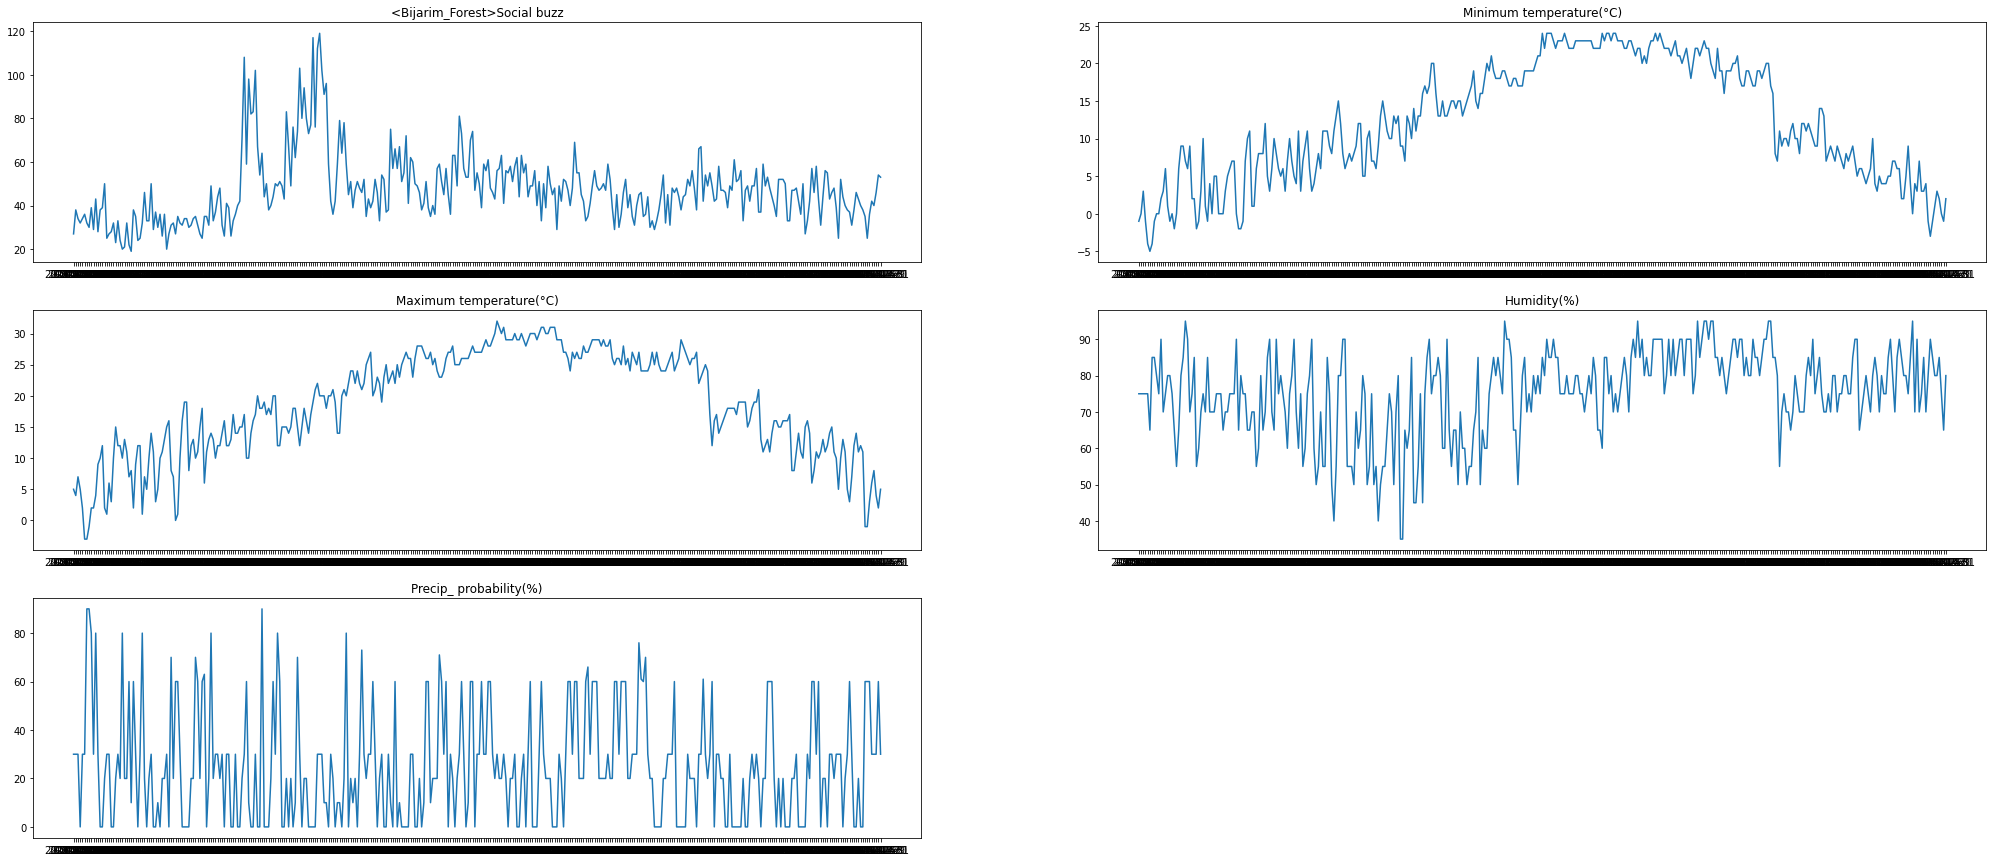

KeyboardInterrupt: ignored

In [5]:
# for문을 이용해 파일을 불러와 poi별로 plot이 그려짐.
for i in os.listdir(project_path+'modeling_dataset/'):
    df = pd.read_csv(project_path+'modeling_dataset/'+i)
################ .ipynb_checkpoints 때문에 에러가 날 경우, 삭제하고 다시 실행 해주세요 #############################
    
# 날짜에 따른 변수들의 변화 시각화
    plt.figure(figsize=(35, 15))
    name = i.split('.')[0]

    plt.subplot(321)
    plt.plot(df['date'], df['social_buzz'],label='social_buzz')
    plt.title('<'+name+'>' 'Social buzz')

    plt.subplot(322)
    plt.plot(df['date'], df['minimum temperature(°C)'],label='minimum temperature(°C)')
    plt.title('Minimum temperature(°C)')

    plt.subplot(323)
    plt.plot(df['date'], df['maximum temperature(°C)'],label='maximum temperature(°C)')
    plt.title('Maximum temperature(°C)')

    plt.subplot(324)
    plt.plot(df['date'], df['humidity(%)'],label='humidity(%)')
    plt.title('Humidity(%)')

    plt.subplot(325)
    plt.plot(df['date'], df['precip_prob(%)'],label='precip_prob(%)')
    plt.title('Precip_ probability(%)')

    plt.show()

In [ ]:
# GPU 설정하기
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# LSTM 네트워크 구성하기
class LSTM1(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM1, self).__init__()
    # 클래스 개수
    self.num_classes = num_classes 
    #layer 개수
    self.num_layers = num_layers 
    #input 사이즈
    self.input_size = input_size 
    #hidden state
    self.hidden_size = hidden_size 
    #sequence 길이
    self.seq_length = seq_length 

    #LSTM
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                      num_layers=num_layers, batch_first=True) 
    # fully connected 
    self.fc_1 =  nn.Linear(hidden_size, 128) 
    # fully connected 마지막 layer
    self.fc = nn.Linear(128, num_classes) 
    # activation function : ReLU
    self.relu = nn.ReLU() 

  # Forward propagate 
  def forward(self,x):
    # hidden state
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) 
    # internal state
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)   

    output, (hn, cn) = self.lstm(x, (h_0, c_0)) 
   
    # lstm에 맞게 data shape 변경
    hn = hn.view(-1, self.hidden_size) 
    out = self.relu(hn)
    # 첫번째 Dense
    out = self.fc_1(out)
    out = self.relu(out)
    # 최종 output
    out = self.fc(out) 
   
    return out 

In [ ]:
# CNN LSTM 네트워크 구성하기
class CNN_LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(CNN_LSTM, self).__init__()
        # CNN 1D layer 
        self.conv1d_1 = nn.Conv1d(in_channels=input_size,
                                out_channels=16,
                                kernel_size=3,
                                stride=1,
                                padding=1)
        self.conv1d_2 = nn.Conv1d(in_channels=16,
                                out_channels=32,
                                kernel_size=3,
                                stride=1,
                                padding=1)
        
        # LSTM
        self.lstm = nn.LSTM(input_size=32,
                            hidden_size=64,
                            num_layers=1,
                            bias=True,
                            bidirectional=False,
                            batch_first=True)
        
        self.dropout = nn.Dropout(0.1)

        self.dense1 = nn.Linear(64, 32)
        self.dense2 = nn.Linear(32, 16)

        # fully connected layer 1
        self.fc_layer1 = nn.Sequential(
            nn.Linear(64, 32),
            # activation function : LeakyReLU
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p = 0.1)
        )
        # fully connected layer 2
        self.fc_layer2 = nn.Sequential(
            nn.Linear(32, 1),
            # activation function : LeakyReLU
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p = 0.1)
        )

    # Forward propagate 
    def forward(self, x):
  	# Raw x shape : (B, S, F) -> (B, 10, 3)
        
        # Shape : (B, F, S) -> (B, 3, 10)
        x = x.transpose(1, 2)
        # Shape : (B, F, S) == (B, C, S) // C = channel -> (B, 16, 10)
        x = self.conv1d_1(x)
        # Shape : (B, C, S) -> (B, 32, 10)
        x = self.conv1d_2(x)
        # Shape : (B, S, C) == (B, S, F) -> (B, 10, 32)
        x = x.transpose(1, 2)
        
        self.lstm.flatten_parameters()
        # Shape : (B, S, H) // H = hidden_size -> (B, 10, 50)
        _, (hidden, _) = self.lstm(x)
        # Shape : (B, H) // -1 means the last sequence -> (B, 50)
        x = hidden[-1]
        # Shape : (B, H) -> (B, 50)
        x = self.dropout(x)
        
        # Shape : (B, 32)
        x = self.fc_layer1(x)
        # 최종 output
        x = self.fc_layer2(x)

        return x

In [ ]:
# MSE 값 넣기 위해 리스트 생성
lstm_temp = []
cnn_temp = []
rmse = pd.DataFrame()

Epoch: 0, loss: 0.49894
Epoch: 100, loss: 0.03319
Epoch: 200, loss: 0.02936
Epoch: 300, loss: 0.02621
Epoch: 400, loss: 0.02456
Epoch: 500, loss: 0.02315
Epoch: 600, loss: 0.02240
Epoch: 700, loss: 0.02181
Epoch: 800, loss: 0.02117
Epoch: 900, loss: 0.02019
Epoch: 1000, loss: 0.01934
Epoch: 1100, loss: 0.01851
Epoch: 1200, loss: 0.01791
Epoch: 1300, loss: 0.01751
Epoch: 1400, loss: 0.01721
Epoch: 1500, loss: 0.01686
Epoch: 1600, loss: 0.01658
Epoch: 1700, loss: 0.01634
Epoch: 1800, loss: 0.01607
Epoch: 1900, loss: 0.01589
Epoch: 2000, loss: 0.01568
Epoch: 2100, loss: 0.01547
Epoch: 2200, loss: 0.01526
Epoch: 2300, loss: 0.01505
Epoch: 2400, loss: 0.01483
Epoch: 2500, loss: 0.01422
Epoch: 2600, loss: 0.01387
Epoch: 2700, loss: 0.01363
Epoch: 2800, loss: 0.01341
Epoch: 2900, loss: 0.01324
Epoch: 3000, loss: 0.01297
Epoch: 3100, loss: 0.01282
Epoch: 3200, loss: 0.01258
Epoch: 3300, loss: 0.01246
Epoch: 3400, loss: 0.01234
Epoch: 3500, loss: 0.01222
Epoch: 3600, loss: 0.01213
Epoch: 3700, 

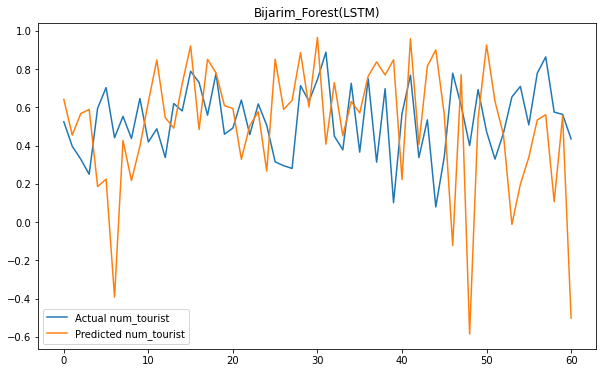

RMSE: 0.10510300869897705
Epoch: 0, loss: 0.31717
Epoch: 100, loss: 0.07028
Epoch: 200, loss: 0.06388
Epoch: 300, loss: 0.06390
Epoch: 400, loss: 0.05159
Epoch: 500, loss: 0.05433
Epoch: 600, loss: 0.05486
Epoch: 700, loss: 0.03403
Epoch: 800, loss: 0.04715
Epoch: 900, loss: 0.02835
Epoch: 1000, loss: 0.04044
Epoch: 1100, loss: 0.02898
Epoch: 1200, loss: 0.03725
Epoch: 1300, loss: 0.03459
Epoch: 1400, loss: 0.03396
Epoch: 1500, loss: 0.03835
Epoch: 1600, loss: 0.02512
Epoch: 1700, loss: 0.02602
Epoch: 1800, loss: 0.03521
Epoch: 1900, loss: 0.04204
Epoch: 2000, loss: 0.05383
Epoch: 2100, loss: 0.02786
Epoch: 2200, loss: 0.03601
Epoch: 2300, loss: 0.03795
Epoch: 2400, loss: 0.02871
Epoch: 2500, loss: 0.03825
Epoch: 2600, loss: 0.03984
Epoch: 2700, loss: 0.03040
Epoch: 2800, loss: 0.03291
Epoch: 2900, loss: 0.03420
Epoch: 3000, loss: 0.03348
Epoch: 3100, loss: 0.03269
Epoch: 3200, loss: 0.02740
Epoch: 3300, loss: 0.02964
Epoch: 3400, loss: 0.03656
Epoch: 3500, loss: 0.03297
Epoch: 3600, l

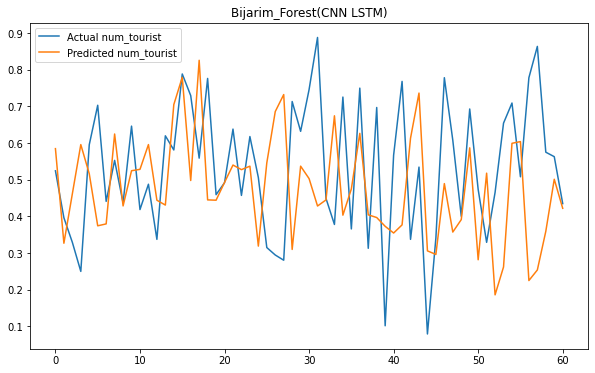

RMSE: 0.2176786481583792
Epoch: 0, loss: 0.18979
Epoch: 100, loss: 0.03109
Epoch: 200, loss: 0.02544
Epoch: 300, loss: 0.02176
Epoch: 400, loss: 0.01959
Epoch: 500, loss: 0.01762
Epoch: 600, loss: 0.01653
Epoch: 700, loss: 0.01568
Epoch: 800, loss: 0.01488
Epoch: 900, loss: 0.01406
Epoch: 1000, loss: 0.01320
Epoch: 1100, loss: 0.01262
Epoch: 1200, loss: 0.01216
Epoch: 1300, loss: 0.01175
Epoch: 1400, loss: 0.01142
Epoch: 1500, loss: 0.01122
Epoch: 1600, loss: 0.01098
Epoch: 1700, loss: 0.01078
Epoch: 1800, loss: 0.01068
Epoch: 1900, loss: 0.01048
Epoch: 2000, loss: 0.01034
Epoch: 2100, loss: 0.01014
Epoch: 2200, loss: 0.01012
Epoch: 2300, loss: 0.00992
Epoch: 2400, loss: 0.00985
Epoch: 2500, loss: 0.00978
Epoch: 2600, loss: 0.00971
Epoch: 2700, loss: 0.00965
Epoch: 2800, loss: 0.00961
Epoch: 2900, loss: 0.00959
Epoch: 3000, loss: 0.00963
Epoch: 3100, loss: 0.00952
Epoch: 3200, loss: 0.00947
Epoch: 3300, loss: 0.00944
Epoch: 3400, loss: 0.00945
Epoch: 3500, loss: 0.00941
Epoch: 3600, lo

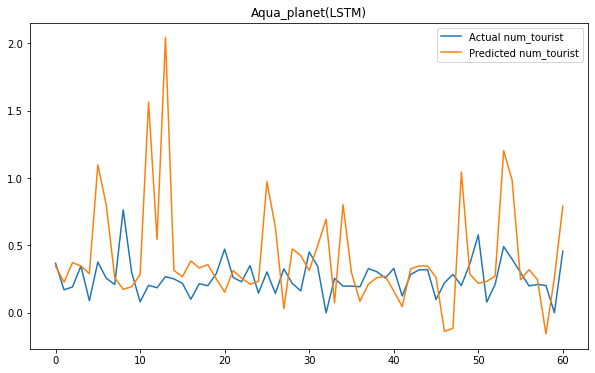

RMSE: 0.09103037014819881
Epoch: 0, loss: 0.13557
Epoch: 100, loss: 0.04152
Epoch: 200, loss: 0.03895
Epoch: 300, loss: 0.03890
Epoch: 400, loss: 0.03332
Epoch: 500, loss: 0.02542
Epoch: 600, loss: 0.02074
Epoch: 700, loss: 0.01779
Epoch: 800, loss: 0.01670
Epoch: 900, loss: 0.01797
Epoch: 1000, loss: 0.01787
Epoch: 1100, loss: 0.01521
Epoch: 1200, loss: 0.01852
Epoch: 1300, loss: 0.01019
Epoch: 1400, loss: 0.00998
Epoch: 1500, loss: 0.01360
Epoch: 1600, loss: 0.01922
Epoch: 1700, loss: 0.02369
Epoch: 1800, loss: 0.01323
Epoch: 1900, loss: 0.01638
Epoch: 2000, loss: 0.01984
Epoch: 2100, loss: 0.01414
Epoch: 2200, loss: 0.02166
Epoch: 2300, loss: 0.01281
Epoch: 2400, loss: 0.01513
Epoch: 2500, loss: 0.01389
Epoch: 2600, loss: 0.01321
Epoch: 2700, loss: 0.01693
Epoch: 2800, loss: 0.01427
Epoch: 2900, loss: 0.00745
Epoch: 3000, loss: 0.01781
Epoch: 3100, loss: 0.01557
Epoch: 3200, loss: 0.01231
Epoch: 3300, loss: 0.01529
Epoch: 3400, loss: 0.01858
Epoch: 3500, loss: 0.01121
Epoch: 3600, l

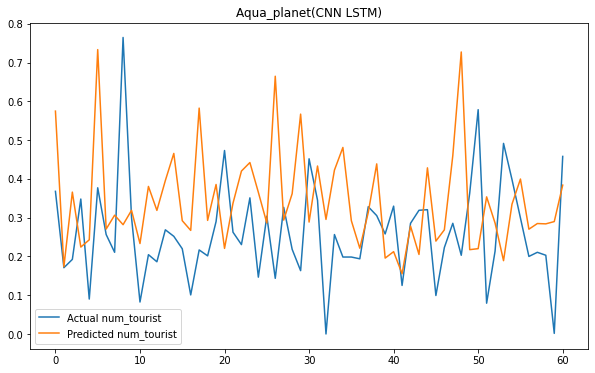

RMSE: 0.13305990932544293
Epoch: 0, loss: 0.14881
Epoch: 100, loss: 0.02272
Epoch: 200, loss: 0.01703
Epoch: 300, loss: 0.01542
Epoch: 400, loss: 0.01475
Epoch: 500, loss: 0.01437
Epoch: 600, loss: 0.01399
Epoch: 700, loss: 0.01358
Epoch: 800, loss: 0.01325
Epoch: 900, loss: 0.01293
Epoch: 1000, loss: 0.01254
Epoch: 1100, loss: 0.01212
Epoch: 1200, loss: 0.01163
Epoch: 1300, loss: 0.01104
Epoch: 1400, loss: 0.01054
Epoch: 1500, loss: 0.01022
Epoch: 1600, loss: 0.01004
Epoch: 1700, loss: 0.00987
Epoch: 1800, loss: 0.00978
Epoch: 1900, loss: 0.00971
Epoch: 2000, loss: 0.00963
Epoch: 2100, loss: 0.00953
Epoch: 2200, loss: 0.00945
Epoch: 2300, loss: 0.00951
Epoch: 2400, loss: 0.00933
Epoch: 2500, loss: 0.00926
Epoch: 2600, loss: 0.00921
Epoch: 2700, loss: 0.00915
Epoch: 2800, loss: 0.00917
Epoch: 2900, loss: 0.00902
Epoch: 3000, loss: 0.00901
Epoch: 3100, loss: 0.00892
Epoch: 3200, loss: 0.00889
Epoch: 3300, loss: 0.00879
Epoch: 3400, loss: 0.00873
Epoch: 3500, loss: 0.00872
Epoch: 3600, l

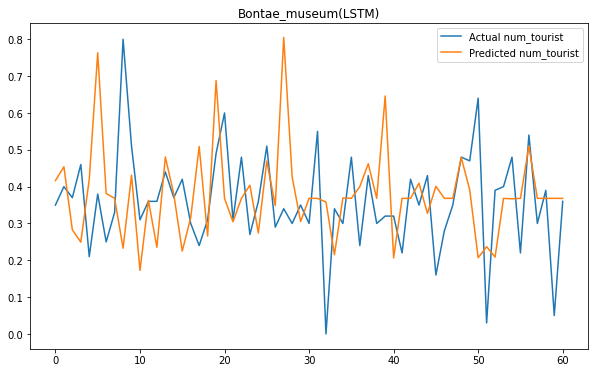

RMSE: 0.08617222223877655
Epoch: 0, loss: 0.16651
Epoch: 100, loss: 0.03730
Epoch: 200, loss: 0.03239
Epoch: 300, loss: 0.03322
Epoch: 400, loss: 0.03041
Epoch: 500, loss: 0.02507
Epoch: 600, loss: 0.01844
Epoch: 700, loss: 0.02173
Epoch: 800, loss: 0.02562
Epoch: 900, loss: 0.01451
Epoch: 1000, loss: 0.01920
Epoch: 1100, loss: 0.01739
Epoch: 1200, loss: 0.01249
Epoch: 1300, loss: 0.02127
Epoch: 1400, loss: 0.02303
Epoch: 1500, loss: 0.01964
Epoch: 1600, loss: 0.01539
Epoch: 1700, loss: 0.01696
Epoch: 1800, loss: 0.02092
Epoch: 1900, loss: 0.02257
Epoch: 2000, loss: 0.02250
Epoch: 2100, loss: 0.01733
Epoch: 2200, loss: 0.01829
Epoch: 2300, loss: 0.01597
Epoch: 2400, loss: 0.01284
Epoch: 2500, loss: 0.02405
Epoch: 2600, loss: 0.02181
Epoch: 2700, loss: 0.02060
Epoch: 2800, loss: 0.01892
Epoch: 2900, loss: 0.02037
Epoch: 3000, loss: 0.01705
Epoch: 3100, loss: 0.01727
Epoch: 3200, loss: 0.01175
Epoch: 3300, loss: 0.01642
Epoch: 3400, loss: 0.01853
Epoch: 3500, loss: 0.02248
Epoch: 3600, l

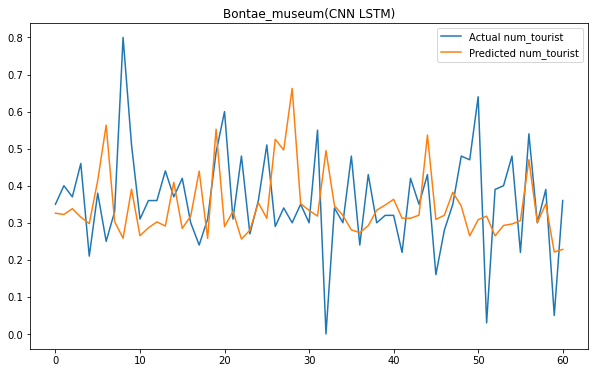

RMSE: 0.13102421413375925
Epoch: 0, loss: 0.20762
Epoch: 100, loss: 0.04791
Epoch: 200, loss: 0.04140
Epoch: 300, loss: 0.03679
Epoch: 400, loss: 0.03459
Epoch: 500, loss: 0.03221
Epoch: 600, loss: 0.02950
Epoch: 700, loss: 0.02698
Epoch: 800, loss: 0.02592
Epoch: 900, loss: 0.02521
Epoch: 1000, loss: 0.02469
Epoch: 1100, loss: 0.02409
Epoch: 1200, loss: 0.02354
Epoch: 1300, loss: 0.02318
Epoch: 1400, loss: 0.02258
Epoch: 1500, loss: 0.02225
Epoch: 1600, loss: 0.02179
Epoch: 1700, loss: 0.02147
Epoch: 1800, loss: 0.02113
Epoch: 1900, loss: 0.02080
Epoch: 2000, loss: 0.02057
Epoch: 2100, loss: 0.02036
Epoch: 2200, loss: 0.02017
Epoch: 2300, loss: 0.02001
Epoch: 2400, loss: 0.01968
Epoch: 2500, loss: 0.01954
Epoch: 2600, loss: 0.01943
Epoch: 2700, loss: 0.01936
Epoch: 2800, loss: 0.01937
Epoch: 2900, loss: 0.01912
Epoch: 3000, loss: 0.01891
Epoch: 3100, loss: 0.01879
Epoch: 3200, loss: 0.01867
Epoch: 3300, loss: 0.01855
Epoch: 3400, loss: 0.01837
Epoch: 3500, loss: 0.01818
Epoch: 3600, l

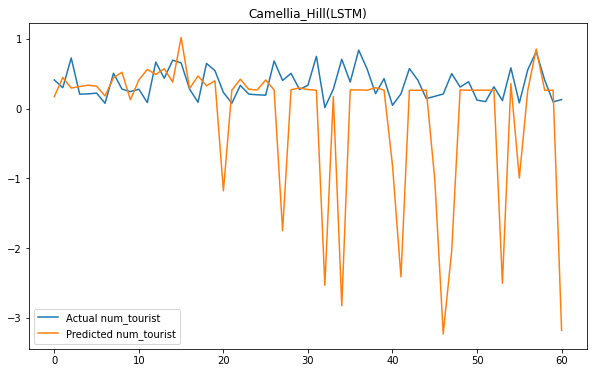

RMSE: 0.1149888210655231
Epoch: 0, loss: 0.19911
Epoch: 100, loss: 0.06924
Epoch: 200, loss: 0.06953
Epoch: 300, loss: 0.06186
Epoch: 400, loss: 0.04826
Epoch: 500, loss: 0.03311
Epoch: 600, loss: 0.03850
Epoch: 700, loss: 0.01813
Epoch: 800, loss: 0.02202
Epoch: 900, loss: 0.02409
Epoch: 1000, loss: 0.02727
Epoch: 1100, loss: 0.02134
Epoch: 1200, loss: 0.01630
Epoch: 1300, loss: 0.01609
Epoch: 1400, loss: 0.02020
Epoch: 1500, loss: 0.01884
Epoch: 1600, loss: 0.01752
Epoch: 1700, loss: 0.02187
Epoch: 1800, loss: 0.01620
Epoch: 1900, loss: 0.01672
Epoch: 2000, loss: 0.02213
Epoch: 2100, loss: 0.02184
Epoch: 2200, loss: 0.01767
Epoch: 2300, loss: 0.02173
Epoch: 2400, loss: 0.02145
Epoch: 2500, loss: 0.01970
Epoch: 2600, loss: 0.01628
Epoch: 2700, loss: 0.01829
Epoch: 2800, loss: 0.02392
Epoch: 2900, loss: 0.02657
Epoch: 3000, loss: 0.02681
Epoch: 3100, loss: 0.03507
Epoch: 3200, loss: 0.02485
Epoch: 3300, loss: 0.02512
Epoch: 3400, loss: 0.02061
Epoch: 3500, loss: 0.02443
Epoch: 3600, lo

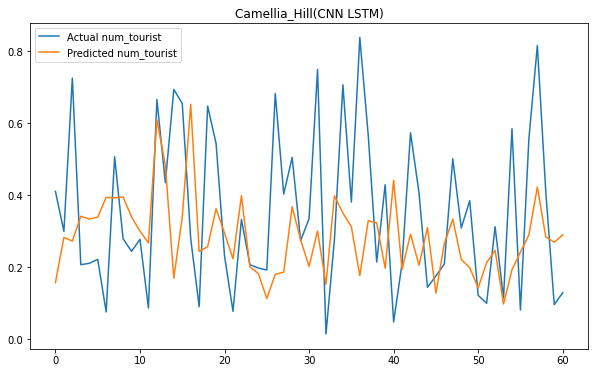

RMSE: 0.11707737039363329
Epoch: 0, loss: 0.20299
Epoch: 100, loss: 0.02822
Epoch: 200, loss: 0.02597
Epoch: 300, loss: 0.02258
Epoch: 400, loss: 0.01983
Epoch: 500, loss: 0.01806
Epoch: 600, loss: 0.01602
Epoch: 700, loss: 0.01464
Epoch: 800, loss: 0.01385
Epoch: 900, loss: 0.01323
Epoch: 1000, loss: 0.01281
Epoch: 1100, loss: 0.01242
Epoch: 1200, loss: 0.01207
Epoch: 1300, loss: 0.01183
Epoch: 1400, loss: 0.01169
Epoch: 1500, loss: 0.01157
Epoch: 1600, loss: 0.01131
Epoch: 1700, loss: 0.01105
Epoch: 1800, loss: 0.01091
Epoch: 1900, loss: 0.01085
Epoch: 2000, loss: 0.01063
Epoch: 2100, loss: 0.01052
Epoch: 2200, loss: 0.01042
Epoch: 2300, loss: 0.01032
Epoch: 2400, loss: 0.01020
Epoch: 2500, loss: 0.01005
Epoch: 2600, loss: 0.01007
Epoch: 2700, loss: 0.01002
Epoch: 2800, loss: 0.00984
Epoch: 2900, loss: 0.00979
Epoch: 3000, loss: 0.00974
Epoch: 3100, loss: 0.00971
Epoch: 3200, loss: 0.00963
Epoch: 3300, loss: 0.00962
Epoch: 3400, loss: 0.00955
Epoch: 3500, loss: 0.00961
Epoch: 3600, l

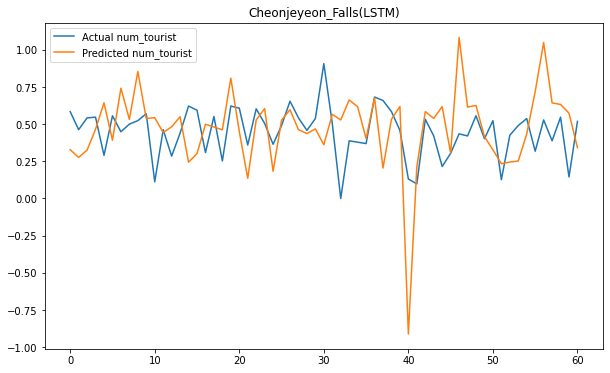

RMSE: 0.08781558383077862
Epoch: 0, loss: 0.23287
Epoch: 100, loss: 0.04590
Epoch: 200, loss: 0.05337
Epoch: 300, loss: 0.04877
Epoch: 400, loss: 0.03973
Epoch: 500, loss: 0.04659
Epoch: 600, loss: 0.03151
Epoch: 700, loss: 0.04059
Epoch: 800, loss: 0.04001
Epoch: 900, loss: 0.03283
Epoch: 1000, loss: 0.02862
Epoch: 1100, loss: 0.03534
Epoch: 1200, loss: 0.02126
Epoch: 1300, loss: 0.02930
Epoch: 1400, loss: 0.03284
Epoch: 1500, loss: 0.01775
Epoch: 1600, loss: 0.02316
Epoch: 1700, loss: 0.01922
Epoch: 1800, loss: 0.02383
Epoch: 1900, loss: 0.02835
Epoch: 2000, loss: 0.02651
Epoch: 2100, loss: 0.02376
Epoch: 2200, loss: 0.01980
Epoch: 2300, loss: 0.01896
Epoch: 2400, loss: 0.02481
Epoch: 2500, loss: 0.02965
Epoch: 2600, loss: 0.02408
Epoch: 2700, loss: 0.01876
Epoch: 2800, loss: 0.02619
Epoch: 2900, loss: 0.01404
Epoch: 3000, loss: 0.02426
Epoch: 3100, loss: 0.01928
Epoch: 3200, loss: 0.02606
Epoch: 3300, loss: 0.02276
Epoch: 3400, loss: 0.02458
Epoch: 3500, loss: 0.02419
Epoch: 3600, l

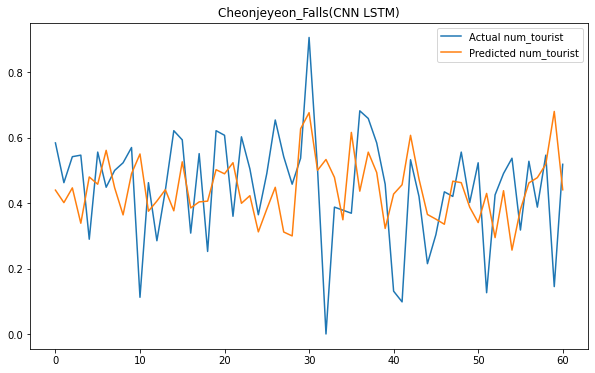

RMSE: 0.16589979731229482
Epoch: 0, loss: 0.24420
Epoch: 100, loss: 0.03575
Epoch: 200, loss: 0.03207
Epoch: 300, loss: 0.02764
Epoch: 400, loss: 0.02311
Epoch: 500, loss: 0.02180
Epoch: 600, loss: 0.02103
Epoch: 700, loss: 0.02011
Epoch: 800, loss: 0.01933
Epoch: 900, loss: 0.01860
Epoch: 1000, loss: 0.01802
Epoch: 1100, loss: 0.01741
Epoch: 1200, loss: 0.01682
Epoch: 1300, loss: 0.01628
Epoch: 1400, loss: 0.01586
Epoch: 1500, loss: 0.01539
Epoch: 1600, loss: 0.01506
Epoch: 1700, loss: 0.01476
Epoch: 1800, loss: 0.01452
Epoch: 1900, loss: 0.01430
Epoch: 2000, loss: 0.01403
Epoch: 2100, loss: 0.01384
Epoch: 2200, loss: 0.01361
Epoch: 2300, loss: 0.01344
Epoch: 2400, loss: 0.01337
Epoch: 2500, loss: 0.01324
Epoch: 2600, loss: 0.01307
Epoch: 2700, loss: 0.01305
Epoch: 2800, loss: 0.01290
Epoch: 2900, loss: 0.01281
Epoch: 3000, loss: 0.01272
Epoch: 3100, loss: 0.01265
Epoch: 3200, loss: 0.01263
Epoch: 3300, loss: 0.01256
Epoch: 3400, loss: 0.01242
Epoch: 3500, loss: 0.01228
Epoch: 3600, l

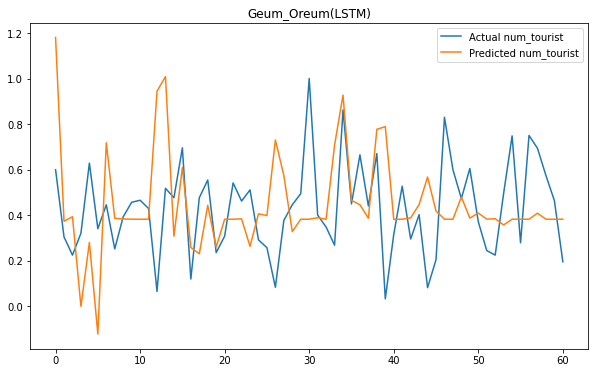

RMSE: 0.10442916805805655
Epoch: 0, loss: 0.18527
Epoch: 100, loss: 0.05841
Epoch: 200, loss: 0.04205
Epoch: 300, loss: 0.03733
Epoch: 400, loss: 0.03274
Epoch: 500, loss: 0.02275
Epoch: 600, loss: 0.02295
Epoch: 700, loss: 0.01780
Epoch: 800, loss: 0.02826
Epoch: 900, loss: 0.03055
Epoch: 1000, loss: 0.01983
Epoch: 1100, loss: 0.02756
Epoch: 1200, loss: 0.02408
Epoch: 1300, loss: 0.01895
Epoch: 1400, loss: 0.02378
Epoch: 1500, loss: 0.02379
Epoch: 1600, loss: 0.01798
Epoch: 1700, loss: 0.01428
Epoch: 1800, loss: 0.02107
Epoch: 1900, loss: 0.01789
Epoch: 2000, loss: 0.02243
Epoch: 2100, loss: 0.01982
Epoch: 2200, loss: 0.02591
Epoch: 2300, loss: 0.01778
Epoch: 2400, loss: 0.02149
Epoch: 2500, loss: 0.03434
Epoch: 2600, loss: 0.02364
Epoch: 2700, loss: 0.02255
Epoch: 2800, loss: 0.02315
Epoch: 2900, loss: 0.02338
Epoch: 3000, loss: 0.02822
Epoch: 3100, loss: 0.02600
Epoch: 3200, loss: 0.01653
Epoch: 3300, loss: 0.01273
Epoch: 3400, loss: 0.01881
Epoch: 3500, loss: 0.01854
Epoch: 3600, l

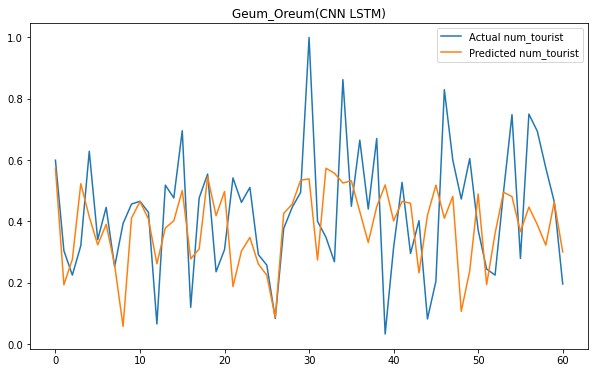

RMSE: 0.17232374651032523
Epoch: 0, loss: 0.12170
Epoch: 100, loss: 0.03178
Epoch: 200, loss: 0.02587
Epoch: 300, loss: 0.02071
Epoch: 400, loss: 0.01847
Epoch: 500, loss: 0.01658
Epoch: 600, loss: 0.01482
Epoch: 700, loss: 0.01415
Epoch: 800, loss: 0.01353
Epoch: 900, loss: 0.01293
Epoch: 1000, loss: 0.01200
Epoch: 1100, loss: 0.01123
Epoch: 1200, loss: 0.01076
Epoch: 1300, loss: 0.01025
Epoch: 1400, loss: 0.00981
Epoch: 1500, loss: 0.00939
Epoch: 1600, loss: 0.00910
Epoch: 1700, loss: 0.00879
Epoch: 1800, loss: 0.00845
Epoch: 1900, loss: 0.00816
Epoch: 2000, loss: 0.00797
Epoch: 2100, loss: 0.00787
Epoch: 2200, loss: 0.00765
Epoch: 2300, loss: 0.00747
Epoch: 2400, loss: 0.00730
Epoch: 2500, loss: 0.00712
Epoch: 2600, loss: 0.00696
Epoch: 2700, loss: 0.00720
Epoch: 2800, loss: 0.00693
Epoch: 2900, loss: 0.00658
Epoch: 3000, loss: 0.00648
Epoch: 3100, loss: 0.00671
Epoch: 3200, loss: 0.00627
Epoch: 3300, loss: 0.00616
Epoch: 3400, loss: 0.00607
Epoch: 3500, loss: 0.00595
Epoch: 3600, l

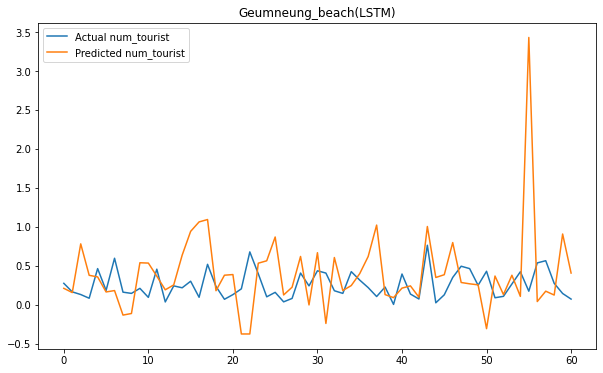

RMSE: 0.05449249633236674
Epoch: 0, loss: 0.09611
Epoch: 100, loss: 0.03867
Epoch: 200, loss: 0.03156
Epoch: 300, loss: 0.02850
Epoch: 400, loss: 0.02355
Epoch: 500, loss: 0.02055
Epoch: 600, loss: 0.01804
Epoch: 700, loss: 0.02244
Epoch: 800, loss: 0.01361
Epoch: 900, loss: 0.01482
Epoch: 1000, loss: 0.01409
Epoch: 1100, loss: 0.01293
Epoch: 1200, loss: 0.01789
Epoch: 1300, loss: 0.00915
Epoch: 1400, loss: 0.01139
Epoch: 1500, loss: 0.01023
Epoch: 1600, loss: 0.01196
Epoch: 1700, loss: 0.01483
Epoch: 1800, loss: 0.01463
Epoch: 1900, loss: 0.01196
Epoch: 2000, loss: 0.01143
Epoch: 2100, loss: 0.01022
Epoch: 2200, loss: 0.01249
Epoch: 2300, loss: 0.01336
Epoch: 2400, loss: 0.01327
Epoch: 2500, loss: 0.01296
Epoch: 2600, loss: 0.01801
Epoch: 2700, loss: 0.02132
Epoch: 2800, loss: 0.01271
Epoch: 2900, loss: 0.01308
Epoch: 3000, loss: 0.01260
Epoch: 3100, loss: 0.01322
Epoch: 3200, loss: 0.01384
Epoch: 3300, loss: 0.01686
Epoch: 3400, loss: 0.01087
Epoch: 3500, loss: 0.00994
Epoch: 3600, l

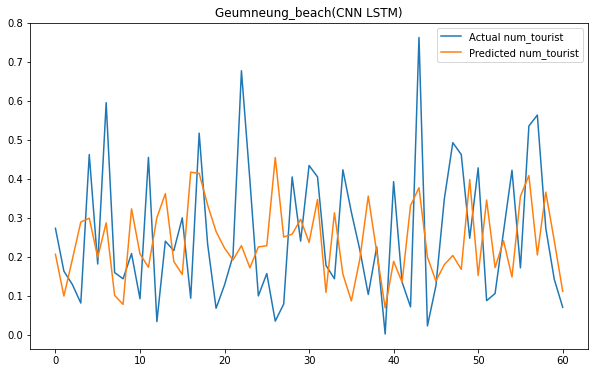

RMSE: 0.10220076750447989
Epoch: 0, loss: 0.22978
Epoch: 100, loss: 0.03512
Epoch: 200, loss: 0.03026
Epoch: 300, loss: 0.02762
Epoch: 400, loss: 0.02600
Epoch: 500, loss: 0.02500
Epoch: 600, loss: 0.02395
Epoch: 700, loss: 0.02241
Epoch: 800, loss: 0.01940
Epoch: 900, loss: 0.01760
Epoch: 1000, loss: 0.01663
Epoch: 1100, loss: 0.01583
Epoch: 1200, loss: 0.01525
Epoch: 1300, loss: 0.01430
Epoch: 1400, loss: 0.01354
Epoch: 1500, loss: 0.01300
Epoch: 1600, loss: 0.01266
Epoch: 1700, loss: 0.01238
Epoch: 1800, loss: 0.01219
Epoch: 1900, loss: 0.01199
Epoch: 2000, loss: 0.01181
Epoch: 2100, loss: 0.01173
Epoch: 2200, loss: 0.01164
Epoch: 2300, loss: 0.01159
Epoch: 2400, loss: 0.01140
Epoch: 2500, loss: 0.01133
Epoch: 2600, loss: 0.01128
Epoch: 2700, loss: 0.01113
Epoch: 2800, loss: 0.01099
Epoch: 2900, loss: 0.01089
Epoch: 3000, loss: 0.01077
Epoch: 3100, loss: 0.01068
Epoch: 3200, loss: 0.01069
Epoch: 3300, loss: 0.01055
Epoch: 3400, loss: 0.01049
Epoch: 3500, loss: 0.01046
Epoch: 3600, l

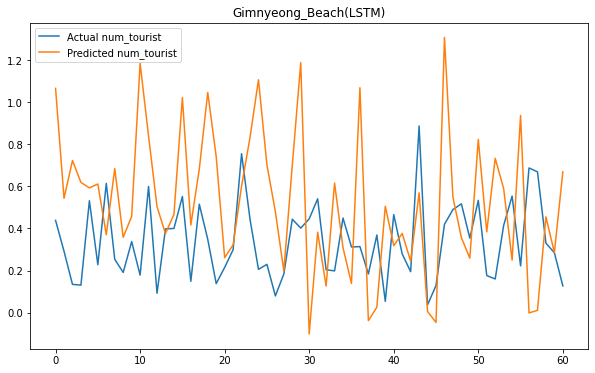

RMSE: 0.08872797825429368
Epoch: 0, loss: 0.15561
Epoch: 100, loss: 0.05460
Epoch: 200, loss: 0.04592
Epoch: 300, loss: 0.04539
Epoch: 400, loss: 0.04088
Epoch: 500, loss: 0.02748
Epoch: 600, loss: 0.02630
Epoch: 700, loss: 0.02884
Epoch: 800, loss: 0.02491
Epoch: 900, loss: 0.01817
Epoch: 1000, loss: 0.02293
Epoch: 1100, loss: 0.02288
Epoch: 1200, loss: 0.02096
Epoch: 1300, loss: 0.02149
Epoch: 1400, loss: 0.01862
Epoch: 1500, loss: 0.02439
Epoch: 1600, loss: 0.01983
Epoch: 1700, loss: 0.01372
Epoch: 1800, loss: 0.01633
Epoch: 1900, loss: 0.01511
Epoch: 2000, loss: 0.01455
Epoch: 2100, loss: 0.02021
Epoch: 2200, loss: 0.01478
Epoch: 2300, loss: 0.01532
Epoch: 2400, loss: 0.02470
Epoch: 2500, loss: 0.02471
Epoch: 2600, loss: 0.01408
Epoch: 2700, loss: 0.02655
Epoch: 2800, loss: 0.01869
Epoch: 2900, loss: 0.01436
Epoch: 3000, loss: 0.02090
Epoch: 3100, loss: 0.01660
Epoch: 3200, loss: 0.02118
Epoch: 3300, loss: 0.01979
Epoch: 3400, loss: 0.00971
Epoch: 3500, loss: 0.01759
Epoch: 3600, l

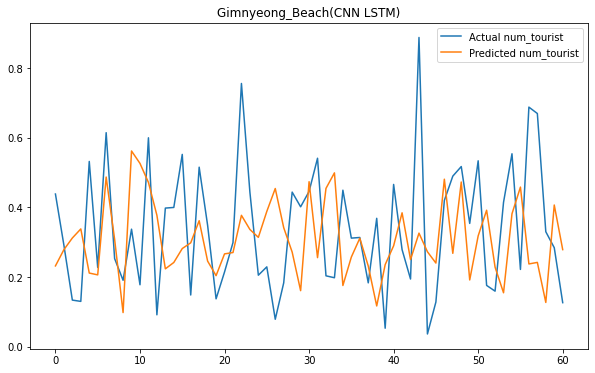

RMSE: 0.13883236879121125
Epoch: 0, loss: 0.42083
Epoch: 100, loss: 0.02371
Epoch: 200, loss: 0.02223
Epoch: 300, loss: 0.02025
Epoch: 400, loss: 0.01914
Epoch: 500, loss: 0.01838
Epoch: 600, loss: 0.01791
Epoch: 700, loss: 0.01746
Epoch: 800, loss: 0.01696
Epoch: 900, loss: 0.01597
Epoch: 1000, loss: 0.01527
Epoch: 1100, loss: 0.01475
Epoch: 1200, loss: 0.01402
Epoch: 1300, loss: 0.01324
Epoch: 1400, loss: 0.01248
Epoch: 1500, loss: 0.01182
Epoch: 1600, loss: 0.01133
Epoch: 1700, loss: 0.01081
Epoch: 1800, loss: 0.01034
Epoch: 1900, loss: 0.01004
Epoch: 2000, loss: 0.00980
Epoch: 2100, loss: 0.00957
Epoch: 2200, loss: 0.00939
Epoch: 2300, loss: 0.00926
Epoch: 2400, loss: 0.00913
Epoch: 2500, loss: 0.00903
Epoch: 2600, loss: 0.00890
Epoch: 2700, loss: 0.00870
Epoch: 2800, loss: 0.00854
Epoch: 2900, loss: 0.00841
Epoch: 3000, loss: 0.00833
Epoch: 3100, loss: 0.00828
Epoch: 3200, loss: 0.00827
Epoch: 3300, loss: 0.00820
Epoch: 3400, loss: 0.00823
Epoch: 3500, loss: 0.00811
Epoch: 3600, l

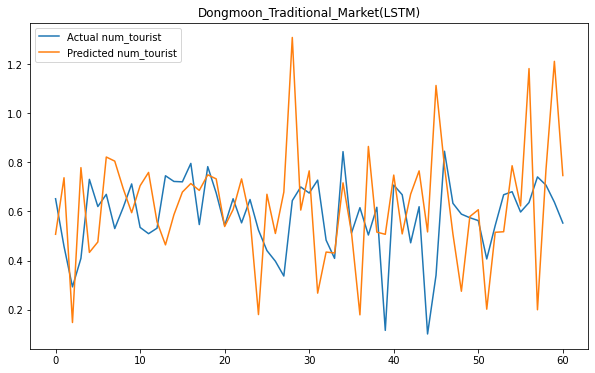

RMSE: 0.08351748454608181
Epoch: 0, loss: 0.36558
Epoch: 100, loss: 0.05634
Epoch: 200, loss: 0.06064
Epoch: 300, loss: 0.05277
Epoch: 400, loss: 0.05352
Epoch: 500, loss: 0.05131
Epoch: 600, loss: 0.06063
Epoch: 700, loss: 0.06144
Epoch: 800, loss: 0.04787
Epoch: 900, loss: 0.04983
Epoch: 1000, loss: 0.03826
Epoch: 1100, loss: 0.04618
Epoch: 1200, loss: 0.04063
Epoch: 1300, loss: 0.03906
Epoch: 1400, loss: 0.03033
Epoch: 1500, loss: 0.04480
Epoch: 1600, loss: 0.04758
Epoch: 1700, loss: 0.03071
Epoch: 1800, loss: 0.03338
Epoch: 1900, loss: 0.04355
Epoch: 2000, loss: 0.04412
Epoch: 2100, loss: 0.03925
Epoch: 2200, loss: 0.04654
Epoch: 2300, loss: 0.03073
Epoch: 2400, loss: 0.03109
Epoch: 2500, loss: 0.04990
Epoch: 2600, loss: 0.03361
Epoch: 2700, loss: 0.04206
Epoch: 2800, loss: 0.03602
Epoch: 2900, loss: 0.04019
Epoch: 3000, loss: 0.04222
Epoch: 3100, loss: 0.04198
Epoch: 3200, loss: 0.04269
Epoch: 3300, loss: 0.03224
Epoch: 3400, loss: 0.03722
Epoch: 3500, loss: 0.03334
Epoch: 3600, l

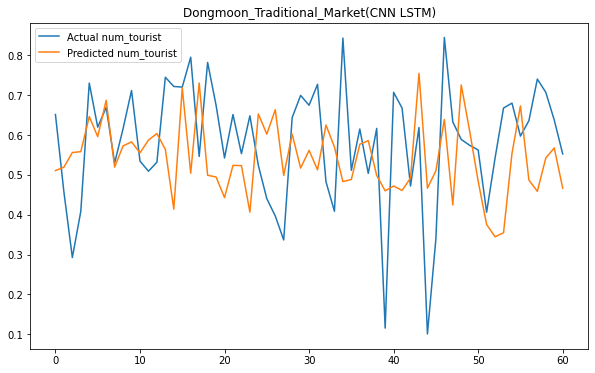

RMSE: 0.19751225530047806
Epoch: 0, loss: 0.08921
Epoch: 100, loss: 0.02805
Epoch: 200, loss: 0.02330
Epoch: 300, loss: 0.01952
Epoch: 400, loss: 0.01758
Epoch: 500, loss: 0.01689
Epoch: 600, loss: 0.01611
Epoch: 700, loss: 0.01520
Epoch: 800, loss: 0.01431
Epoch: 900, loss: 0.01353
Epoch: 1000, loss: 0.01285
Epoch: 1100, loss: 0.01236
Epoch: 1200, loss: 0.01179
Epoch: 1300, loss: 0.01131
Epoch: 1400, loss: 0.01097
Epoch: 1500, loss: 0.01068
Epoch: 1600, loss: 0.01069
Epoch: 1700, loss: 0.01019
Epoch: 1800, loss: 0.01025
Epoch: 1900, loss: 0.00997
Epoch: 2000, loss: 0.00992
Epoch: 2100, loss: 0.00976
Epoch: 2200, loss: 0.00964
Epoch: 2300, loss: 0.00962
Epoch: 2400, loss: 0.00946
Epoch: 2500, loss: 0.00953
Epoch: 2600, loss: 0.00929
Epoch: 2700, loss: 0.00929
Epoch: 2800, loss: 0.00920
Epoch: 2900, loss: 0.00916
Epoch: 3000, loss: 0.00906
Epoch: 3100, loss: 0.00911
Epoch: 3200, loss: 0.00903
Epoch: 3300, loss: 0.00896
Epoch: 3400, loss: 0.00890
Epoch: 3500, loss: 0.00894
Epoch: 3600, l

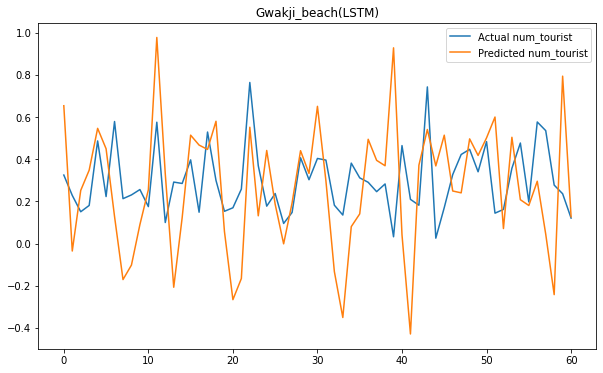

RMSE: 0.0890689749204475
Epoch: 0, loss: 0.12214
Epoch: 100, loss: 0.03880
Epoch: 200, loss: 0.04014
Epoch: 300, loss: 0.03822
Epoch: 400, loss: 0.03329
Epoch: 500, loss: 0.02751
Epoch: 600, loss: 0.02675
Epoch: 700, loss: 0.02775
Epoch: 800, loss: 0.01668
Epoch: 900, loss: 0.02104
Epoch: 1000, loss: 0.01745
Epoch: 1100, loss: 0.01571
Epoch: 1200, loss: 0.01186
Epoch: 1300, loss: 0.01528
Epoch: 1400, loss: 0.02520
Epoch: 1500, loss: 0.01864
Epoch: 1600, loss: 0.01324
Epoch: 1700, loss: 0.01810
Epoch: 1800, loss: 0.02169
Epoch: 1900, loss: 0.00981
Epoch: 2000, loss: 0.01280
Epoch: 2100, loss: 0.00982
Epoch: 2200, loss: 0.01357
Epoch: 2300, loss: 0.01314
Epoch: 2400, loss: 0.01657
Epoch: 2500, loss: 0.01304
Epoch: 2600, loss: 0.01292
Epoch: 2700, loss: 0.01856
Epoch: 2800, loss: 0.01550
Epoch: 2900, loss: 0.01018
Epoch: 3000, loss: 0.00896
Epoch: 3100, loss: 0.01477
Epoch: 3200, loss: 0.01261
Epoch: 3300, loss: 0.01363
Epoch: 3400, loss: 0.01704
Epoch: 3500, loss: 0.01353
Epoch: 3600, lo

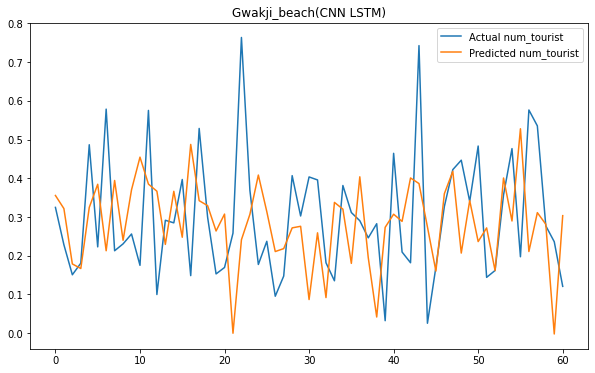

RMSE: 0.10454214541783768
Epoch: 0, loss: 0.40444
Epoch: 100, loss: 0.03139
Epoch: 200, loss: 0.02886
Epoch: 300, loss: 0.02481
Epoch: 400, loss: 0.02141
Epoch: 500, loss: 0.01963
Epoch: 600, loss: 0.01875
Epoch: 700, loss: 0.01810
Epoch: 800, loss: 0.01701
Epoch: 900, loss: 0.01611
Epoch: 1000, loss: 0.01535
Epoch: 1100, loss: 0.01468
Epoch: 1200, loss: 0.01413
Epoch: 1300, loss: 0.01368
Epoch: 1400, loss: 0.01348
Epoch: 1500, loss: 0.01328
Epoch: 1600, loss: 0.01304
Epoch: 1700, loss: 0.01291
Epoch: 1800, loss: 0.01265
Epoch: 1900, loss: 0.01232
Epoch: 2000, loss: 0.01206
Epoch: 2100, loss: 0.01170
Epoch: 2200, loss: 0.01149
Epoch: 2300, loss: 0.01139
Epoch: 2400, loss: 0.01119
Epoch: 2500, loss: 0.01105
Epoch: 2600, loss: 0.01092
Epoch: 2700, loss: 0.01078
Epoch: 2800, loss: 0.01070
Epoch: 2900, loss: 0.01058
Epoch: 3000, loss: 0.01050
Epoch: 3100, loss: 0.01042
Epoch: 3200, loss: 0.01036
Epoch: 3300, loss: 0.01022
Epoch: 3400, loss: 0.01010
Epoch: 3500, loss: 0.01004
Epoch: 3600, l

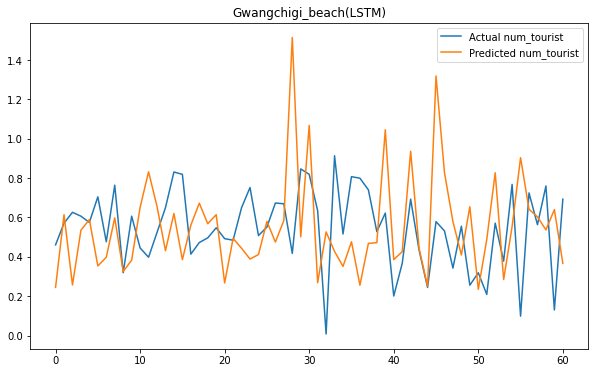

RMSE: 0.08902294008150352
Epoch: 0, loss: 0.30940
Epoch: 100, loss: 0.06162
Epoch: 200, loss: 0.05906
Epoch: 300, loss: 0.06647
Epoch: 400, loss: 0.05705
Epoch: 500, loss: 0.05884
Epoch: 600, loss: 0.04530
Epoch: 700, loss: 0.04427
Epoch: 800, loss: 0.03501
Epoch: 900, loss: 0.02588
Epoch: 1000, loss: 0.04109
Epoch: 1100, loss: 0.03835
Epoch: 1200, loss: 0.03819
Epoch: 1300, loss: 0.03730
Epoch: 1400, loss: 0.02900
Epoch: 1500, loss: 0.02369
Epoch: 1600, loss: 0.03149
Epoch: 1700, loss: 0.03275
Epoch: 1800, loss: 0.03545
Epoch: 1900, loss: 0.03745
Epoch: 2000, loss: 0.03038
Epoch: 2100, loss: 0.03037
Epoch: 2200, loss: 0.04247
Epoch: 2300, loss: 0.03848
Epoch: 2400, loss: 0.04113
Epoch: 2500, loss: 0.02741
Epoch: 2600, loss: 0.03343
Epoch: 2700, loss: 0.02824
Epoch: 2800, loss: 0.04107
Epoch: 2900, loss: 0.03071
Epoch: 3000, loss: 0.02957
Epoch: 3100, loss: 0.03550
Epoch: 3200, loss: 0.04141
Epoch: 3300, loss: 0.03914
Epoch: 3400, loss: 0.03347
Epoch: 3500, loss: 0.03456
Epoch: 3600, l

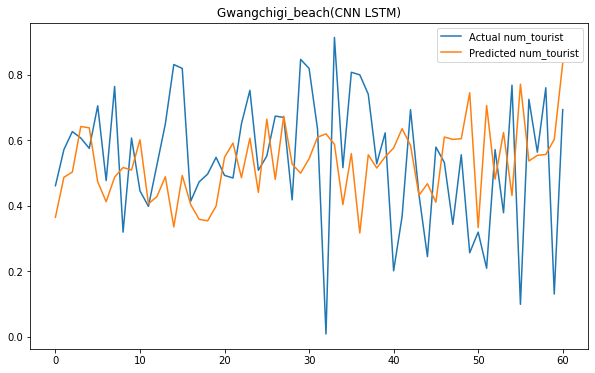

RMSE: 0.15964431470826276
Epoch: 0, loss: 0.06042
Epoch: 100, loss: 0.02066
Epoch: 200, loss: 0.01579
Epoch: 300, loss: 0.01201
Epoch: 400, loss: 0.01072
Epoch: 500, loss: 0.00973
Epoch: 600, loss: 0.00876
Epoch: 700, loss: 0.00805
Epoch: 800, loss: 0.00779
Epoch: 900, loss: 0.00750
Epoch: 1000, loss: 0.00730
Epoch: 1100, loss: 0.00694
Epoch: 1200, loss: 0.00658
Epoch: 1300, loss: 0.00633
Epoch: 1400, loss: 0.00617
Epoch: 1500, loss: 0.00604
Epoch: 1600, loss: 0.00601
Epoch: 1700, loss: 0.00578
Epoch: 1800, loss: 0.00564
Epoch: 1900, loss: 0.00540
Epoch: 2000, loss: 0.00523
Epoch: 2100, loss: 0.00517
Epoch: 2200, loss: 0.00510
Epoch: 2300, loss: 0.00493
Epoch: 2400, loss: 0.00484
Epoch: 2500, loss: 0.00499
Epoch: 2600, loss: 0.00476
Epoch: 2700, loss: 0.00468
Epoch: 2800, loss: 0.00468
Epoch: 2900, loss: 0.00459
Epoch: 3000, loss: 0.00451
Epoch: 3100, loss: 0.00449
Epoch: 3200, loss: 0.00442
Epoch: 3300, loss: 0.00435
Epoch: 3400, loss: 0.00432
Epoch: 3500, loss: 0.00431
Epoch: 3600, l

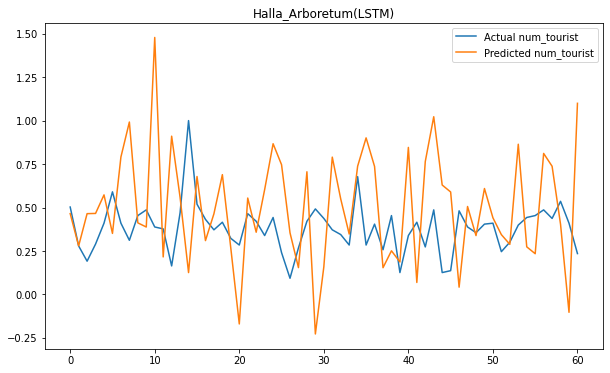

RMSE: 0.05288429055393435
Epoch: 0, loss: 0.11831
Epoch: 100, loss: 0.03951
Epoch: 200, loss: 0.03283
Epoch: 300, loss: 0.02254
Epoch: 400, loss: 0.02356
Epoch: 500, loss: 0.01826
Epoch: 600, loss: 0.01921
Epoch: 700, loss: 0.01581
Epoch: 800, loss: 0.01813
Epoch: 900, loss: 0.01385
Epoch: 1000, loss: 0.01823
Epoch: 1100, loss: 0.01574
Epoch: 1200, loss: 0.01842
Epoch: 1300, loss: 0.01826
Epoch: 1400, loss: 0.01342
Epoch: 1500, loss: 0.02395
Epoch: 1600, loss: 0.01709
Epoch: 1700, loss: 0.01794
Epoch: 1800, loss: 0.01672
Epoch: 1900, loss: 0.01855
Epoch: 2000, loss: 0.02214
Epoch: 2100, loss: 0.01857
Epoch: 2200, loss: 0.02527
Epoch: 2300, loss: 0.02330
Epoch: 2400, loss: 0.01835
Epoch: 2500, loss: 0.01391
Epoch: 2600, loss: 0.02014
Epoch: 2700, loss: 0.01458
Epoch: 2800, loss: 0.01397
Epoch: 2900, loss: 0.01705
Epoch: 3000, loss: 0.01663
Epoch: 3100, loss: 0.02426
Epoch: 3200, loss: 0.01610
Epoch: 3300, loss: 0.01482
Epoch: 3400, loss: 0.01247
Epoch: 3500, loss: 0.01617
Epoch: 3600, l

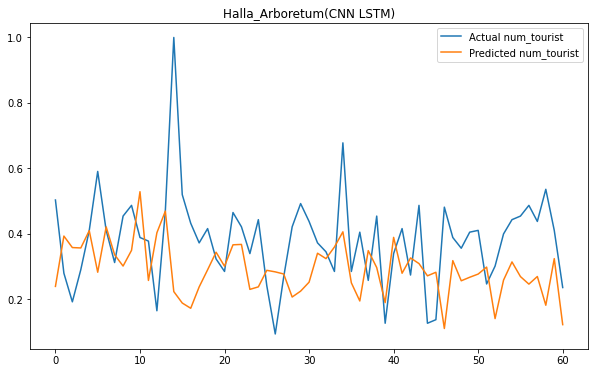

RMSE: 0.11740708837978951
Epoch: 0, loss: 0.16556
Epoch: 100, loss: 0.02527
Epoch: 200, loss: 0.02360
Epoch: 300, loss: 0.02092
Epoch: 400, loss: 0.01665
Epoch: 500, loss: 0.01425
Epoch: 600, loss: 0.01230
Epoch: 700, loss: 0.01085
Epoch: 800, loss: 0.00988
Epoch: 900, loss: 0.00927
Epoch: 1000, loss: 0.00896
Epoch: 1100, loss: 0.00863
Epoch: 1200, loss: 0.00826
Epoch: 1300, loss: 0.00800
Epoch: 1400, loss: 0.00780
Epoch: 1500, loss: 0.00765
Epoch: 1600, loss: 0.00751
Epoch: 1700, loss: 0.00742
Epoch: 1800, loss: 0.00731
Epoch: 1900, loss: 0.00723
Epoch: 2000, loss: 0.00719
Epoch: 2100, loss: 0.00722
Epoch: 2200, loss: 0.00713
Epoch: 2300, loss: 0.00705
Epoch: 2400, loss: 0.00700
Epoch: 2500, loss: 0.00699
Epoch: 2600, loss: 0.00696
Epoch: 2700, loss: 0.00692
Epoch: 2800, loss: 0.00688
Epoch: 2900, loss: 0.00689
Epoch: 3000, loss: 0.00683
Epoch: 3100, loss: 0.00680
Epoch: 3200, loss: 0.00677
Epoch: 3300, loss: 0.00679
Epoch: 3400, loss: 0.00672
Epoch: 3500, loss: 0.00673
Epoch: 3600, l

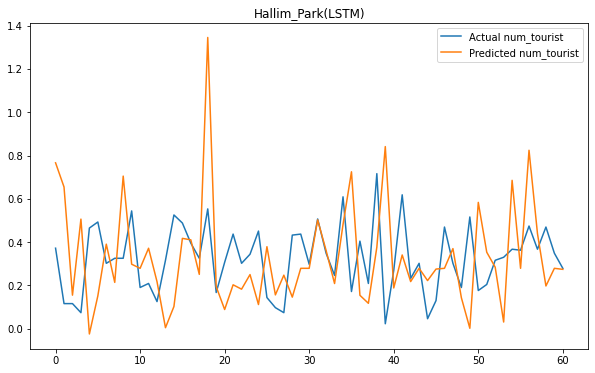

RMSE: 0.0759305922776869
Epoch: 0, loss: 0.08680
Epoch: 100, loss: 0.03256
Epoch: 200, loss: 0.03017
Epoch: 300, loss: 0.02534
Epoch: 400, loss: 0.01908
Epoch: 500, loss: 0.01564
Epoch: 600, loss: 0.01916
Epoch: 700, loss: 0.01392
Epoch: 800, loss: 0.02008
Epoch: 900, loss: 0.01631
Epoch: 1000, loss: 0.01517
Epoch: 1100, loss: 0.01767
Epoch: 1200, loss: 0.01607
Epoch: 1300, loss: 0.01352
Epoch: 1400, loss: 0.01541
Epoch: 1500, loss: 0.01226
Epoch: 1600, loss: 0.00988
Epoch: 1700, loss: 0.01625
Epoch: 1800, loss: 0.01378
Epoch: 1900, loss: 0.01543
Epoch: 2000, loss: 0.02435
Epoch: 2100, loss: 0.01395
Epoch: 2200, loss: 0.01140
Epoch: 2300, loss: 0.01499
Epoch: 2400, loss: 0.01138
Epoch: 2500, loss: 0.01722
Epoch: 2600, loss: 0.01504
Epoch: 2700, loss: 0.01708
Epoch: 2800, loss: 0.01565
Epoch: 2900, loss: 0.01201
Epoch: 3000, loss: 0.01331
Epoch: 3100, loss: 0.01413
Epoch: 3200, loss: 0.01528
Epoch: 3300, loss: 0.00982
Epoch: 3400, loss: 0.02125
Epoch: 3500, loss: 0.01639
Epoch: 3600, lo

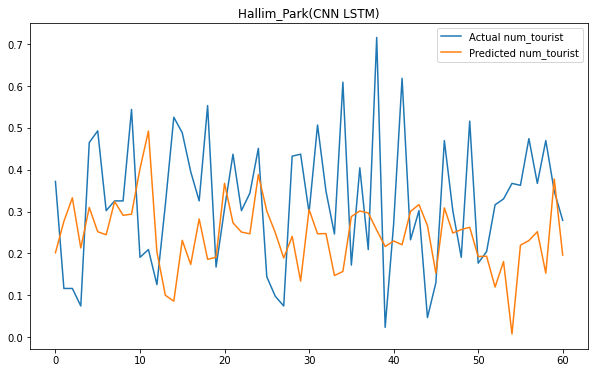

RMSE: 0.13917730794580666
Epoch: 0, loss: 0.26970
Epoch: 100, loss: 0.03171
Epoch: 200, loss: 0.02829
Epoch: 300, loss: 0.02589
Epoch: 400, loss: 0.02341
Epoch: 500, loss: 0.02171
Epoch: 600, loss: 0.02028
Epoch: 700, loss: 0.01950
Epoch: 800, loss: 0.01881
Epoch: 900, loss: 0.01780
Epoch: 1000, loss: 0.01699
Epoch: 1100, loss: 0.01650
Epoch: 1200, loss: 0.01609
Epoch: 1300, loss: 0.01573
Epoch: 1400, loss: 0.01541
Epoch: 1500, loss: 0.01510
Epoch: 1600, loss: 0.01484
Epoch: 1700, loss: 0.01457
Epoch: 1800, loss: 0.01435
Epoch: 1900, loss: 0.01415
Epoch: 2000, loss: 0.01397
Epoch: 2100, loss: 0.01379
Epoch: 2200, loss: 0.01369
Epoch: 2300, loss: 0.01351
Epoch: 2400, loss: 0.01340
Epoch: 2500, loss: 0.01325
Epoch: 2600, loss: 0.01314
Epoch: 2700, loss: 0.01309
Epoch: 2800, loss: 0.01285
Epoch: 2900, loss: 0.01277
Epoch: 3000, loss: 0.01265
Epoch: 3100, loss: 0.01257
Epoch: 3200, loss: 0.01240
Epoch: 3300, loss: 0.01222
Epoch: 3400, loss: 0.01202
Epoch: 3500, loss: 0.01184
Epoch: 3600, l

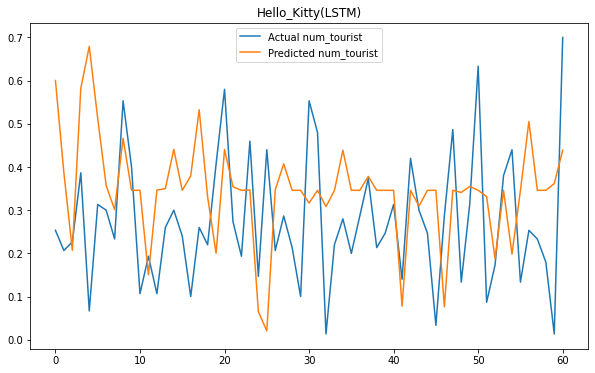

RMSE: 0.09824283383500006
Epoch: 0, loss: 0.14543
Epoch: 100, loss: 0.04368
Epoch: 200, loss: 0.04176
Epoch: 300, loss: 0.04203
Epoch: 400, loss: 0.03866
Epoch: 500, loss: 0.03738
Epoch: 600, loss: 0.03163
Epoch: 700, loss: 0.02801
Epoch: 800, loss: 0.01866
Epoch: 900, loss: 0.01880
Epoch: 1000, loss: 0.02177
Epoch: 1100, loss: 0.01915
Epoch: 1200, loss: 0.01804
Epoch: 1300, loss: 0.01557
Epoch: 1400, loss: 0.01538
Epoch: 1500, loss: 0.01939
Epoch: 1600, loss: 0.01246
Epoch: 1700, loss: 0.01905
Epoch: 1800, loss: 0.01313
Epoch: 1900, loss: 0.01607
Epoch: 2000, loss: 0.01843
Epoch: 2100, loss: 0.01783
Epoch: 2200, loss: 0.00952
Epoch: 2300, loss: 0.01796
Epoch: 2400, loss: 0.01700
Epoch: 2500, loss: 0.01437
Epoch: 2600, loss: 0.02216
Epoch: 2700, loss: 0.01631
Epoch: 2800, loss: 0.01913
Epoch: 2900, loss: 0.01616
Epoch: 3000, loss: 0.01343
Epoch: 3100, loss: 0.01361
Epoch: 3200, loss: 0.01314
Epoch: 3300, loss: 0.01790
Epoch: 3400, loss: 0.01796
Epoch: 3500, loss: 0.01499
Epoch: 3600, l

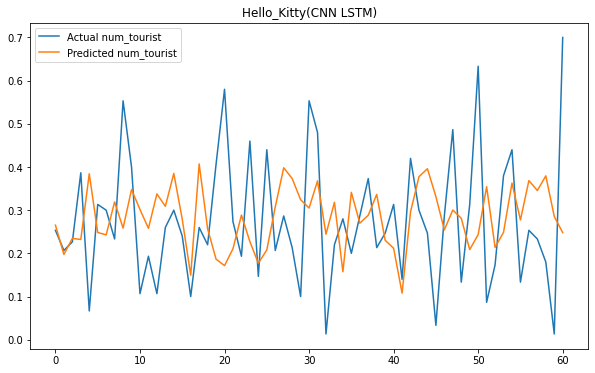

RMSE: 0.13035461235879617
Epoch: 0, loss: 0.48227
Epoch: 100, loss: 0.03452
Epoch: 200, loss: 0.03174
Epoch: 300, loss: 0.02902
Epoch: 400, loss: 0.02811
Epoch: 500, loss: 0.02695
Epoch: 600, loss: 0.02564
Epoch: 700, loss: 0.02464
Epoch: 800, loss: 0.02408
Epoch: 900, loss: 0.02357
Epoch: 1000, loss: 0.02301
Epoch: 1100, loss: 0.02231
Epoch: 1200, loss: 0.02156
Epoch: 1300, loss: 0.02095
Epoch: 1400, loss: 0.02038
Epoch: 1500, loss: 0.01938
Epoch: 1600, loss: 0.01832
Epoch: 1700, loss: 0.01735
Epoch: 1800, loss: 0.01659
Epoch: 1900, loss: 0.01606
Epoch: 2000, loss: 0.01568
Epoch: 2100, loss: 0.01530
Epoch: 2200, loss: 0.01511
Epoch: 2300, loss: 0.01486
Epoch: 2400, loss: 0.01482
Epoch: 2500, loss: 0.01458
Epoch: 2600, loss: 0.01440
Epoch: 2700, loss: 0.01413
Epoch: 2800, loss: 0.01382
Epoch: 2900, loss: 0.01335
Epoch: 3000, loss: 0.01303
Epoch: 3100, loss: 0.01298
Epoch: 3200, loss: 0.01252
Epoch: 3300, loss: 0.01226
Epoch: 3400, loss: 0.01209
Epoch: 3500, loss: 0.01193
Epoch: 3600, l

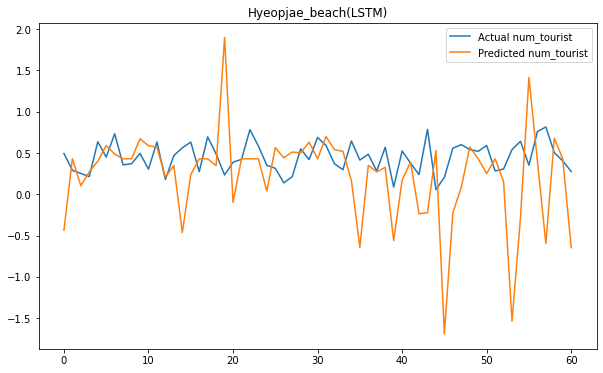

RMSE: 0.0997277612834501
Epoch: 0, loss: 0.15097
Epoch: 100, loss: 0.05993
Epoch: 200, loss: 0.05112
Epoch: 300, loss: 0.04254
Epoch: 400, loss: 0.04586
Epoch: 500, loss: 0.04381
Epoch: 600, loss: 0.02612
Epoch: 700, loss: 0.03364
Epoch: 800, loss: 0.03054
Epoch: 900, loss: 0.02989
Epoch: 1000, loss: 0.03028
Epoch: 1100, loss: 0.03346
Epoch: 1200, loss: 0.04088
Epoch: 1300, loss: 0.03778
Epoch: 1400, loss: 0.03847
Epoch: 1500, loss: 0.01859
Epoch: 1600, loss: 0.02615
Epoch: 1700, loss: 0.02494
Epoch: 1800, loss: 0.02085
Epoch: 1900, loss: 0.02671
Epoch: 2000, loss: 0.03100
Epoch: 2100, loss: 0.02505
Epoch: 2200, loss: 0.01815
Epoch: 2300, loss: 0.02573
Epoch: 2400, loss: 0.03783
Epoch: 2500, loss: 0.02502
Epoch: 2600, loss: 0.02970
Epoch: 2700, loss: 0.02723
Epoch: 2800, loss: 0.01437
Epoch: 2900, loss: 0.02894
Epoch: 3000, loss: 0.02842
Epoch: 3100, loss: 0.01931
Epoch: 3200, loss: 0.02559
Epoch: 3300, loss: 0.02416
Epoch: 3400, loss: 0.02374
Epoch: 3500, loss: 0.01803
Epoch: 3600, lo

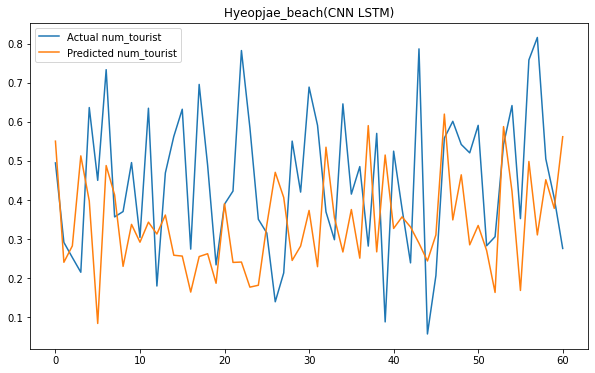

RMSE: 0.14710064001582734
Epoch: 0, loss: 0.40620
Epoch: 100, loss: 0.02378
Epoch: 200, loss: 0.02205
Epoch: 300, loss: 0.02075
Epoch: 400, loss: 0.01979
Epoch: 500, loss: 0.01906
Epoch: 600, loss: 0.01818
Epoch: 700, loss: 0.01699
Epoch: 800, loss: 0.01534
Epoch: 900, loss: 0.01423
Epoch: 1000, loss: 0.01372
Epoch: 1100, loss: 0.01327
Epoch: 1200, loss: 0.01294
Epoch: 1300, loss: 0.01266
Epoch: 1400, loss: 0.01237
Epoch: 1500, loss: 0.01207
Epoch: 1600, loss: 0.01166
Epoch: 1700, loss: 0.01134
Epoch: 1800, loss: 0.01089
Epoch: 1900, loss: 0.01056
Epoch: 2000, loss: 0.01031
Epoch: 2100, loss: 0.01016
Epoch: 2200, loss: 0.01003
Epoch: 2300, loss: 0.00991
Epoch: 2400, loss: 0.00978
Epoch: 2500, loss: 0.00970
Epoch: 2600, loss: 0.00950
Epoch: 2700, loss: 0.00945
Epoch: 2800, loss: 0.00939
Epoch: 2900, loss: 0.00931
Epoch: 3000, loss: 0.00926
Epoch: 3100, loss: 0.00931
Epoch: 3200, loss: 0.00919
Epoch: 3300, loss: 0.00915
Epoch: 3400, loss: 0.00913
Epoch: 3500, loss: 0.00908
Epoch: 3600, l

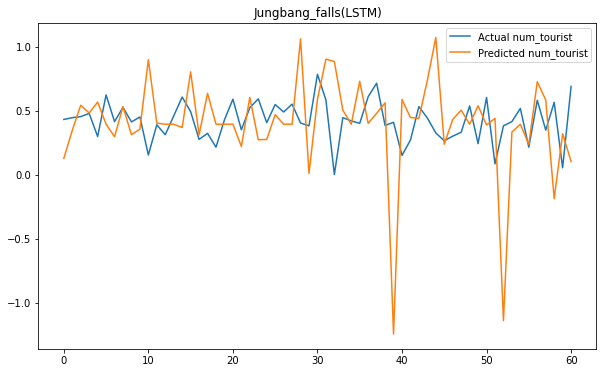

RMSE: 0.09030792327028717
Epoch: 0, loss: 0.12032
Epoch: 100, loss: 0.03972
Epoch: 200, loss: 0.03580
Epoch: 300, loss: 0.02683
Epoch: 400, loss: 0.03001
Epoch: 500, loss: 0.02386
Epoch: 600, loss: 0.02350
Epoch: 700, loss: 0.03022
Epoch: 800, loss: 0.02434
Epoch: 900, loss: 0.01940
Epoch: 1000, loss: 0.01680
Epoch: 1100, loss: 0.02139
Epoch: 1200, loss: 0.01743
Epoch: 1300, loss: 0.01959
Epoch: 1400, loss: 0.02460
Epoch: 1500, loss: 0.02519
Epoch: 1600, loss: 0.02550
Epoch: 1700, loss: 0.01972
Epoch: 1800, loss: 0.02153
Epoch: 1900, loss: 0.02355
Epoch: 2000, loss: 0.02011
Epoch: 2100, loss: 0.01767
Epoch: 2200, loss: 0.01856
Epoch: 2300, loss: 0.02377
Epoch: 2400, loss: 0.02032
Epoch: 2500, loss: 0.02022
Epoch: 2600, loss: 0.02846
Epoch: 2700, loss: 0.01685
Epoch: 2800, loss: 0.01886
Epoch: 2900, loss: 0.02124
Epoch: 3000, loss: 0.02278
Epoch: 3100, loss: 0.01987
Epoch: 3200, loss: 0.01744
Epoch: 3300, loss: 0.02121
Epoch: 3400, loss: 0.01817
Epoch: 3500, loss: 0.01280
Epoch: 3600, l

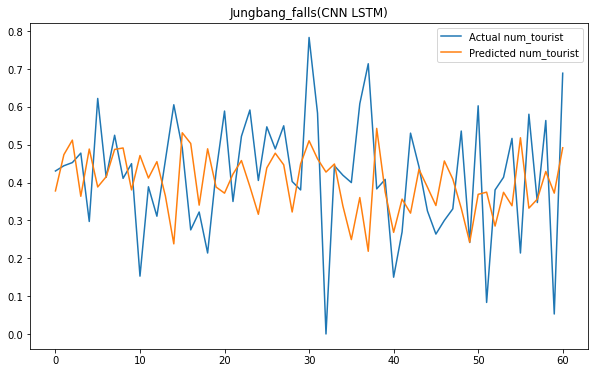

RMSE: 0.1614306096660455
Epoch: 0, loss: 0.29404
Epoch: 100, loss: 0.02979
Epoch: 200, loss: 0.02549
Epoch: 300, loss: 0.02292
Epoch: 400, loss: 0.02144
Epoch: 500, loss: 0.02053
Epoch: 600, loss: 0.02015
Epoch: 700, loss: 0.01992
Epoch: 800, loss: 0.01980
Epoch: 900, loss: 0.01971
Epoch: 1000, loss: 0.01963
Epoch: 1100, loss: 0.01954
Epoch: 1200, loss: 0.01938
Epoch: 1300, loss: 0.01912
Epoch: 1400, loss: 0.01887
Epoch: 1500, loss: 0.01859
Epoch: 1600, loss: 0.01835
Epoch: 1700, loss: 0.01790
Epoch: 1800, loss: 0.01752
Epoch: 1900, loss: 0.01700
Epoch: 2000, loss: 0.01665
Epoch: 2100, loss: 0.01650
Epoch: 2200, loss: 0.01641
Epoch: 2300, loss: 0.01630
Epoch: 2400, loss: 0.01609
Epoch: 2500, loss: 0.01592
Epoch: 2600, loss: 0.01581
Epoch: 2700, loss: 0.01573
Epoch: 2800, loss: 0.01560
Epoch: 2900, loss: 0.01551
Epoch: 3000, loss: 0.01544
Epoch: 3100, loss: 0.01537
Epoch: 3200, loss: 0.01535
Epoch: 3300, loss: 0.01524
Epoch: 3400, loss: 0.01518
Epoch: 3500, loss: 0.01512
Epoch: 3600, lo

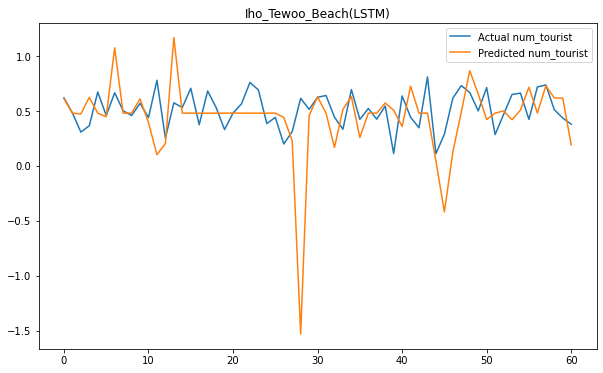

RMSE: 0.11640291625247934
Epoch: 0, loss: 0.18787
Epoch: 100, loss: 0.05820
Epoch: 200, loss: 0.05856
Epoch: 300, loss: 0.05295
Epoch: 400, loss: 0.04572
Epoch: 500, loss: 0.03439
Epoch: 600, loss: 0.02909
Epoch: 700, loss: 0.02906
Epoch: 800, loss: 0.03539
Epoch: 900, loss: 0.03377
Epoch: 1000, loss: 0.02836
Epoch: 1100, loss: 0.03604
Epoch: 1200, loss: 0.04568
Epoch: 1300, loss: 0.02932
Epoch: 1400, loss: 0.03536
Epoch: 1500, loss: 0.03662
Epoch: 1600, loss: 0.02573
Epoch: 1700, loss: 0.03692
Epoch: 1800, loss: 0.02576
Epoch: 1900, loss: 0.03181
Epoch: 2000, loss: 0.02356
Epoch: 2100, loss: 0.03085
Epoch: 2200, loss: 0.04545
Epoch: 2300, loss: 0.02258
Epoch: 2400, loss: 0.02230
Epoch: 2500, loss: 0.02711
Epoch: 2600, loss: 0.02800
Epoch: 2700, loss: 0.04010
Epoch: 2800, loss: 0.02911
Epoch: 2900, loss: 0.03194
Epoch: 3000, loss: 0.02932
Epoch: 3100, loss: 0.03622
Epoch: 3200, loss: 0.02931
Epoch: 3300, loss: 0.03168
Epoch: 3400, loss: 0.04216
Epoch: 3500, loss: 0.03436
Epoch: 3600, l

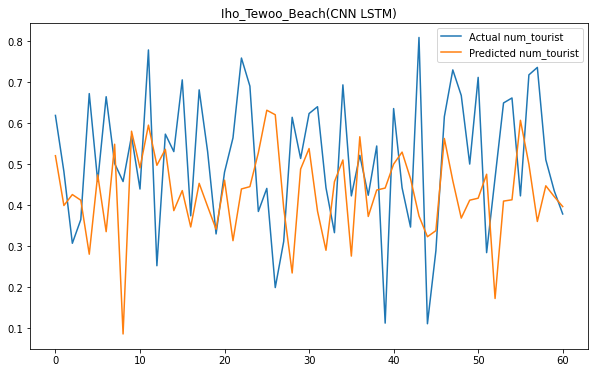

RMSE: 0.21270077665962409
Epoch: 0, loss: 0.35911
Epoch: 100, loss: 0.02655
Epoch: 200, loss: 0.02489
Epoch: 300, loss: 0.02227
Epoch: 400, loss: 0.02058
Epoch: 500, loss: 0.01942
Epoch: 600, loss: 0.01820
Epoch: 700, loss: 0.01778
Epoch: 800, loss: 0.01758
Epoch: 900, loss: 0.01749
Epoch: 1000, loss: 0.01738
Epoch: 1100, loss: 0.01729
Epoch: 1200, loss: 0.01714
Epoch: 1300, loss: 0.01705
Epoch: 1400, loss: 0.01696
Epoch: 1500, loss: 0.01688
Epoch: 1600, loss: 0.01678
Epoch: 1700, loss: 0.01669
Epoch: 1800, loss: 0.01656
Epoch: 1900, loss: 0.01642
Epoch: 2000, loss: 0.01625
Epoch: 2100, loss: 0.01611
Epoch: 2200, loss: 0.01599
Epoch: 2300, loss: 0.01576
Epoch: 2400, loss: 0.01562
Epoch: 2500, loss: 0.01545
Epoch: 2600, loss: 0.01529
Epoch: 2700, loss: 0.01512
Epoch: 2800, loss: 0.01487
Epoch: 2900, loss: 0.01461
Epoch: 3000, loss: 0.01427
Epoch: 3100, loss: 0.01387
Epoch: 3200, loss: 0.01330
Epoch: 3300, loss: 0.01285
Epoch: 3400, loss: 0.01253
Epoch: 3500, loss: 0.01230
Epoch: 3600, l

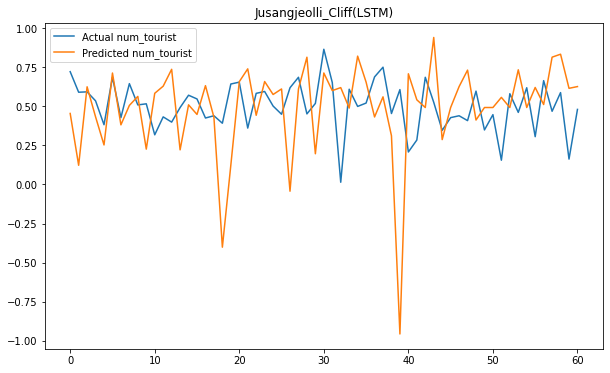

RMSE: 0.09922344579623184
Epoch: 0, loss: 0.28814
Epoch: 100, loss: 0.05053
Epoch: 200, loss: 0.05647
Epoch: 300, loss: 0.04196
Epoch: 400, loss: 0.05381
Epoch: 500, loss: 0.04774
Epoch: 600, loss: 0.05255
Epoch: 700, loss: 0.04280
Epoch: 800, loss: 0.04020
Epoch: 900, loss: 0.03672
Epoch: 1000, loss: 0.03362
Epoch: 1100, loss: 0.03234
Epoch: 1200, loss: 0.03008
Epoch: 1300, loss: 0.02985
Epoch: 1400, loss: 0.03820
Epoch: 1500, loss: 0.02982
Epoch: 1600, loss: 0.03630
Epoch: 1700, loss: 0.02665
Epoch: 1800, loss: 0.03443
Epoch: 1900, loss: 0.03778
Epoch: 2000, loss: 0.03528
Epoch: 2100, loss: 0.03459
Epoch: 2200, loss: 0.03789
Epoch: 2300, loss: 0.02242
Epoch: 2400, loss: 0.03601
Epoch: 2500, loss: 0.02394
Epoch: 2600, loss: 0.02717
Epoch: 2700, loss: 0.03529
Epoch: 2800, loss: 0.02607
Epoch: 2900, loss: 0.02463
Epoch: 3000, loss: 0.03264
Epoch: 3100, loss: 0.02856
Epoch: 3200, loss: 0.02449
Epoch: 3300, loss: 0.02777
Epoch: 3400, loss: 0.02800
Epoch: 3500, loss: 0.03068
Epoch: 3600, l

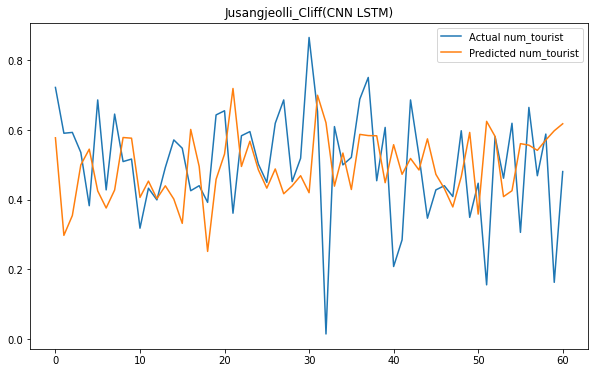

RMSE: 0.1917207430834649
Epoch: 0, loss: 0.30842
Epoch: 100, loss: 0.02914
Epoch: 200, loss: 0.02541
Epoch: 300, loss: 0.02289
Epoch: 400, loss: 0.02089
Epoch: 500, loss: 0.01903
Epoch: 600, loss: 0.01792
Epoch: 700, loss: 0.01734
Epoch: 800, loss: 0.01671
Epoch: 900, loss: 0.01621
Epoch: 1000, loss: 0.01573
Epoch: 1100, loss: 0.01528
Epoch: 1200, loss: 0.01493
Epoch: 1300, loss: 0.01474
Epoch: 1400, loss: 0.01455
Epoch: 1500, loss: 0.01445
Epoch: 1600, loss: 0.01425
Epoch: 1700, loss: 0.01416
Epoch: 1800, loss: 0.01407
Epoch: 1900, loss: 0.01393
Epoch: 2000, loss: 0.01387
Epoch: 2100, loss: 0.01383
Epoch: 2200, loss: 0.01371
Epoch: 2300, loss: 0.01363
Epoch: 2400, loss: 0.01358
Epoch: 2500, loss: 0.01352
Epoch: 2600, loss: 0.01347
Epoch: 2700, loss: 0.01349
Epoch: 2800, loss: 0.01341
Epoch: 2900, loss: 0.01334
Epoch: 3000, loss: 0.01330
Epoch: 3100, loss: 0.01331
Epoch: 3200, loss: 0.01327
Epoch: 3300, loss: 0.01326
Epoch: 3400, loss: 0.01320
Epoch: 3500, loss: 0.01316
Epoch: 3600, lo

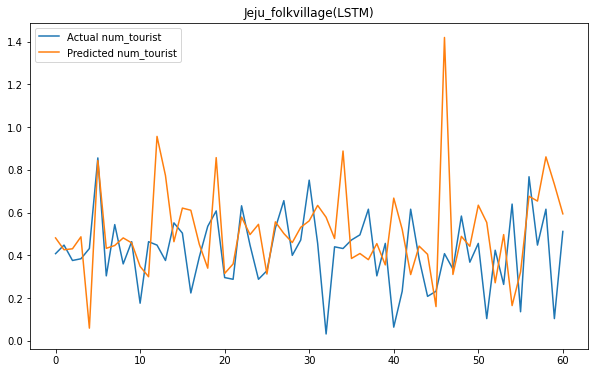

RMSE: 0.09705126765530968
Epoch: 0, loss: 0.21658
Epoch: 100, loss: 0.04935
Epoch: 200, loss: 0.04736
Epoch: 300, loss: 0.04912
Epoch: 400, loss: 0.04690
Epoch: 500, loss: 0.03000
Epoch: 600, loss: 0.02931
Epoch: 700, loss: 0.02704
Epoch: 800, loss: 0.03083
Epoch: 900, loss: 0.02055
Epoch: 1000, loss: 0.03338
Epoch: 1100, loss: 0.03101
Epoch: 1200, loss: 0.02809
Epoch: 1300, loss: 0.02179
Epoch: 1400, loss: 0.03602
Epoch: 1500, loss: 0.03238
Epoch: 1600, loss: 0.02940
Epoch: 1700, loss: 0.02243
Epoch: 1800, loss: 0.02233
Epoch: 1900, loss: 0.02376
Epoch: 2000, loss: 0.03568
Epoch: 2100, loss: 0.01968
Epoch: 2200, loss: 0.03000
Epoch: 2300, loss: 0.02988
Epoch: 2400, loss: 0.02756
Epoch: 2500, loss: 0.02300
Epoch: 2600, loss: 0.01826
Epoch: 2700, loss: 0.01847
Epoch: 2800, loss: 0.03111
Epoch: 2900, loss: 0.02389
Epoch: 3000, loss: 0.02126
Epoch: 3100, loss: 0.02844
Epoch: 3200, loss: 0.01858
Epoch: 3300, loss: 0.02840
Epoch: 3400, loss: 0.02385
Epoch: 3500, loss: 0.02370
Epoch: 3600, l

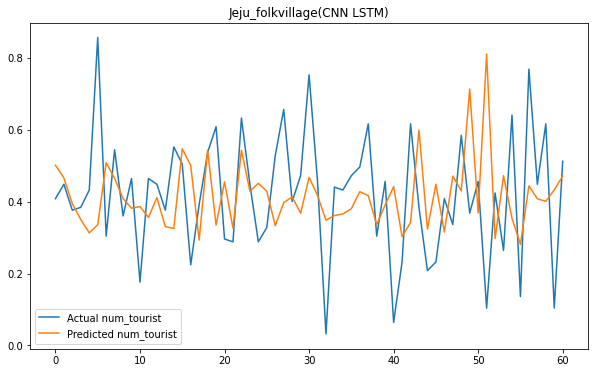

RMSE: 0.16749219603115678
Epoch: 0, loss: 0.11615
Epoch: 100, loss: 0.02806
Epoch: 200, loss: 0.02367
Epoch: 300, loss: 0.02156
Epoch: 400, loss: 0.02012
Epoch: 500, loss: 0.01872
Epoch: 600, loss: 0.01780
Epoch: 700, loss: 0.01684
Epoch: 800, loss: 0.01564
Epoch: 900, loss: 0.01449
Epoch: 1000, loss: 0.01343
Epoch: 1100, loss: 0.01253
Epoch: 1200, loss: 0.01183
Epoch: 1300, loss: 0.01125
Epoch: 1400, loss: 0.01064
Epoch: 1500, loss: 0.01005
Epoch: 1600, loss: 0.00955
Epoch: 1700, loss: 0.00918
Epoch: 1800, loss: 0.00866
Epoch: 1900, loss: 0.00839
Epoch: 2000, loss: 0.00812
Epoch: 2100, loss: 0.00781
Epoch: 2200, loss: 0.00757
Epoch: 2300, loss: 0.00746
Epoch: 2400, loss: 0.00720
Epoch: 2500, loss: 0.00708
Epoch: 2600, loss: 0.00697
Epoch: 2700, loss: 0.00702
Epoch: 2800, loss: 0.00667
Epoch: 2900, loss: 0.00657
Epoch: 3000, loss: 0.00645
Epoch: 3100, loss: 0.00641
Epoch: 3200, loss: 0.00635
Epoch: 3300, loss: 0.00628
Epoch: 3400, loss: 0.00626
Epoch: 3500, loss: 0.00612
Epoch: 3600, l

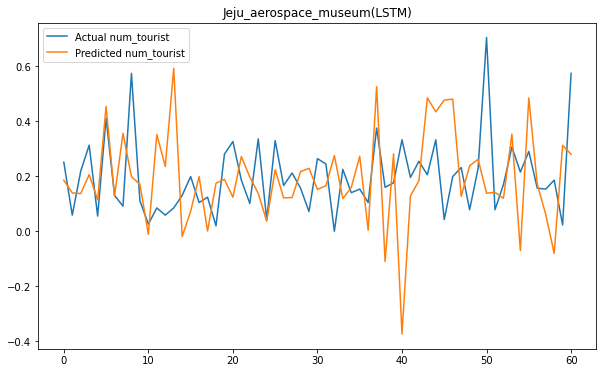

RMSE: 0.06536735583247552
Epoch: 0, loss: 0.03865
Epoch: 100, loss: 0.03117
Epoch: 200, loss: 0.02353
Epoch: 300, loss: 0.02158
Epoch: 400, loss: 0.01830
Epoch: 500, loss: 0.01681
Epoch: 600, loss: 0.01293
Epoch: 700, loss: 0.01582
Epoch: 800, loss: 0.01539
Epoch: 900, loss: 0.01150
Epoch: 1000, loss: 0.01097
Epoch: 1100, loss: 0.01414
Epoch: 1200, loss: 0.00862
Epoch: 1300, loss: 0.00798
Epoch: 1400, loss: 0.01356
Epoch: 1500, loss: 0.00679
Epoch: 1600, loss: 0.00804
Epoch: 1700, loss: 0.01058
Epoch: 1800, loss: 0.00777
Epoch: 1900, loss: 0.01092
Epoch: 2000, loss: 0.00873
Epoch: 2100, loss: 0.01102
Epoch: 2200, loss: 0.01158
Epoch: 2300, loss: 0.01090
Epoch: 2400, loss: 0.00854
Epoch: 2500, loss: 0.00602
Epoch: 2600, loss: 0.01194
Epoch: 2700, loss: 0.01282
Epoch: 2800, loss: 0.01213
Epoch: 2900, loss: 0.01056
Epoch: 3000, loss: 0.01092
Epoch: 3100, loss: 0.00869
Epoch: 3200, loss: 0.01032
Epoch: 3300, loss: 0.01071
Epoch: 3400, loss: 0.00791
Epoch: 3500, loss: 0.01182
Epoch: 3600, l

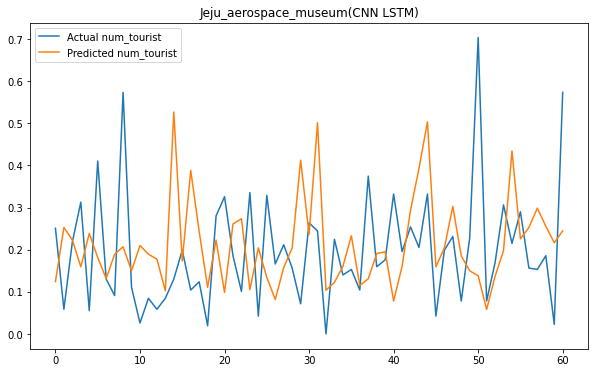

RMSE: 0.09906514472619983
Epoch: 0, loss: 0.29564
Epoch: 100, loss: 0.02623
Epoch: 200, loss: 0.02470
Epoch: 300, loss: 0.02288
Epoch: 400, loss: 0.02112
Epoch: 500, loss: 0.01933
Epoch: 600, loss: 0.01660
Epoch: 700, loss: 0.01515
Epoch: 800, loss: 0.01417
Epoch: 900, loss: 0.01358
Epoch: 1000, loss: 0.01307
Epoch: 1100, loss: 0.01257
Epoch: 1200, loss: 0.01208
Epoch: 1300, loss: 0.01174
Epoch: 1400, loss: 0.01132
Epoch: 1500, loss: 0.01102
Epoch: 1600, loss: 0.01075
Epoch: 1700, loss: 0.01037
Epoch: 1800, loss: 0.01009
Epoch: 1900, loss: 0.00988
Epoch: 2000, loss: 0.00965
Epoch: 2100, loss: 0.00949
Epoch: 2200, loss: 0.00938
Epoch: 2300, loss: 0.00922
Epoch: 2400, loss: 0.00906
Epoch: 2500, loss: 0.00890
Epoch: 2600, loss: 0.00885
Epoch: 2700, loss: 0.00880
Epoch: 2800, loss: 0.00894
Epoch: 2900, loss: 0.00860
Epoch: 3000, loss: 0.00868
Epoch: 3100, loss: 0.00847
Epoch: 3200, loss: 0.00829
Epoch: 3300, loss: 0.00814
Epoch: 3400, loss: 0.00804
Epoch: 3500, loss: 0.00796
Epoch: 3600, l

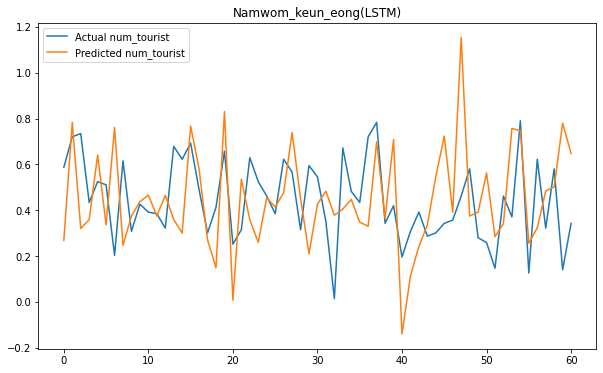

RMSE: 0.07157851922239551
Epoch: 0, loss: 0.21262
Epoch: 100, loss: 0.04609
Epoch: 200, loss: 0.04674
Epoch: 300, loss: 0.03796
Epoch: 400, loss: 0.04344
Epoch: 500, loss: 0.04513
Epoch: 600, loss: 0.03172
Epoch: 700, loss: 0.02948
Epoch: 800, loss: 0.02901
Epoch: 900, loss: 0.03090
Epoch: 1000, loss: 0.02390
Epoch: 1100, loss: 0.02372
Epoch: 1200, loss: 0.01332
Epoch: 1300, loss: 0.01844
Epoch: 1400, loss: 0.02638
Epoch: 1500, loss: 0.02011
Epoch: 1600, loss: 0.02164
Epoch: 1700, loss: 0.02963
Epoch: 1800, loss: 0.02238
Epoch: 1900, loss: 0.02505
Epoch: 2000, loss: 0.02875
Epoch: 2100, loss: 0.02070
Epoch: 2200, loss: 0.01809
Epoch: 2300, loss: 0.02374
Epoch: 2400, loss: 0.01881
Epoch: 2500, loss: 0.01694
Epoch: 2600, loss: 0.02363
Epoch: 2700, loss: 0.02410
Epoch: 2800, loss: 0.02004
Epoch: 2900, loss: 0.02031
Epoch: 3000, loss: 0.02828
Epoch: 3100, loss: 0.01905
Epoch: 3200, loss: 0.01689
Epoch: 3300, loss: 0.01509
Epoch: 3400, loss: 0.02512
Epoch: 3500, loss: 0.02191
Epoch: 3600, l

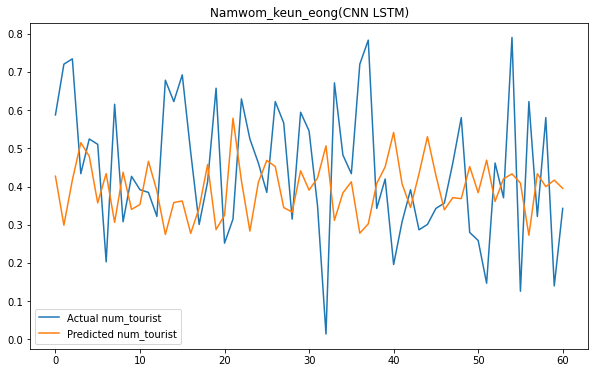

RMSE: 0.1556207563116581
Epoch: 0, loss: 0.65069
Epoch: 100, loss: 0.02244
Epoch: 200, loss: 0.02073
Epoch: 300, loss: 0.01863
Epoch: 400, loss: 0.01768
Epoch: 500, loss: 0.01715
Epoch: 600, loss: 0.01671
Epoch: 700, loss: 0.01624
Epoch: 800, loss: 0.01584
Epoch: 900, loss: 0.01549
Epoch: 1000, loss: 0.01508
Epoch: 1100, loss: 0.01462
Epoch: 1200, loss: 0.01430
Epoch: 1300, loss: 0.01407
Epoch: 1400, loss: 0.01385
Epoch: 1500, loss: 0.01368
Epoch: 1600, loss: 0.01354
Epoch: 1700, loss: 0.01343
Epoch: 1800, loss: 0.01335
Epoch: 1900, loss: 0.01327
Epoch: 2000, loss: 0.01316
Epoch: 2100, loss: 0.01302
Epoch: 2200, loss: 0.01280
Epoch: 2300, loss: 0.01268
Epoch: 2400, loss: 0.01255
Epoch: 2500, loss: 0.01245
Epoch: 2600, loss: 0.01236
Epoch: 2700, loss: 0.01228
Epoch: 2800, loss: 0.01222
Epoch: 2900, loss: 0.01215
Epoch: 3000, loss: 0.01209
Epoch: 3100, loss: 0.01204
Epoch: 3200, loss: 0.01195
Epoch: 3300, loss: 0.01186
Epoch: 3400, loss: 0.01181
Epoch: 3500, loss: 0.01173
Epoch: 3600, lo

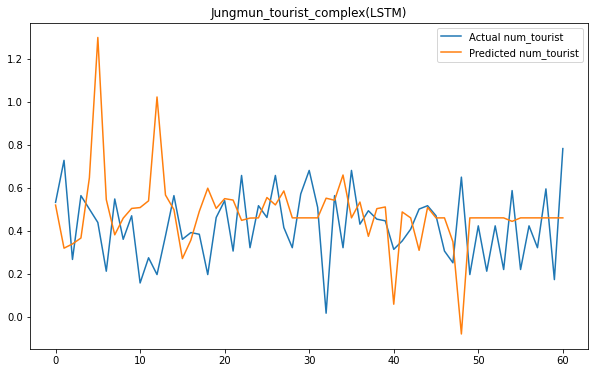

RMSE: 0.09924068658981
Epoch: 0, loss: 0.22254
Epoch: 100, loss: 0.04070
Epoch: 200, loss: 0.04895
Epoch: 300, loss: 0.03944
Epoch: 400, loss: 0.03879
Epoch: 500, loss: 0.02381
Epoch: 600, loss: 0.02787
Epoch: 700, loss: 0.03425
Epoch: 800, loss: 0.03333
Epoch: 900, loss: 0.02644
Epoch: 1000, loss: 0.02735
Epoch: 1100, loss: 0.02282
Epoch: 1200, loss: 0.03390
Epoch: 1300, loss: 0.02218
Epoch: 1400, loss: 0.02480
Epoch: 1500, loss: 0.02767
Epoch: 1600, loss: 0.03072
Epoch: 1700, loss: 0.02248
Epoch: 1800, loss: 0.02694
Epoch: 1900, loss: 0.02156
Epoch: 2000, loss: 0.01449
Epoch: 2100, loss: 0.02854
Epoch: 2200, loss: 0.02698
Epoch: 2300, loss: 0.01751
Epoch: 2400, loss: 0.02001
Epoch: 2500, loss: 0.02414
Epoch: 2600, loss: 0.01730
Epoch: 2700, loss: 0.02540
Epoch: 2800, loss: 0.01965
Epoch: 2900, loss: 0.01913
Epoch: 3000, loss: 0.02748
Epoch: 3100, loss: 0.02212
Epoch: 3200, loss: 0.02786
Epoch: 3300, loss: 0.01600
Epoch: 3400, loss: 0.02542
Epoch: 3500, loss: 0.03318
Epoch: 3600, loss

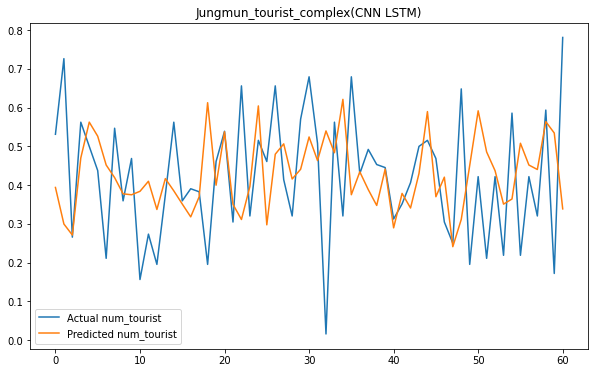

RMSE: 0.16755919649687387
Epoch: 0, loss: 0.30280
Epoch: 100, loss: 0.02985
Epoch: 200, loss: 0.02645
Epoch: 300, loss: 0.02370
Epoch: 400, loss: 0.02127
Epoch: 500, loss: 0.02057
Epoch: 600, loss: 0.02019
Epoch: 700, loss: 0.01978
Epoch: 800, loss: 0.01935
Epoch: 900, loss: 0.01883
Epoch: 1000, loss: 0.01842
Epoch: 1100, loss: 0.01793
Epoch: 1200, loss: 0.01732
Epoch: 1300, loss: 0.01682
Epoch: 1400, loss: 0.01648
Epoch: 1500, loss: 0.01624
Epoch: 1600, loss: 0.01608
Epoch: 1700, loss: 0.01597
Epoch: 1800, loss: 0.01587
Epoch: 1900, loss: 0.01578
Epoch: 2000, loss: 0.01566
Epoch: 2100, loss: 0.01557
Epoch: 2200, loss: 0.01552
Epoch: 2300, loss: 0.01543
Epoch: 2400, loss: 0.01535
Epoch: 2500, loss: 0.01527
Epoch: 2600, loss: 0.01521
Epoch: 2700, loss: 0.01521
Epoch: 2800, loss: 0.01512
Epoch: 2900, loss: 0.01509
Epoch: 3000, loss: 0.01505
Epoch: 3100, loss: 0.01503
Epoch: 3200, loss: 0.01501
Epoch: 3300, loss: 0.01498
Epoch: 3400, loss: 0.01497
Epoch: 3500, loss: 0.01498
Epoch: 3600, l

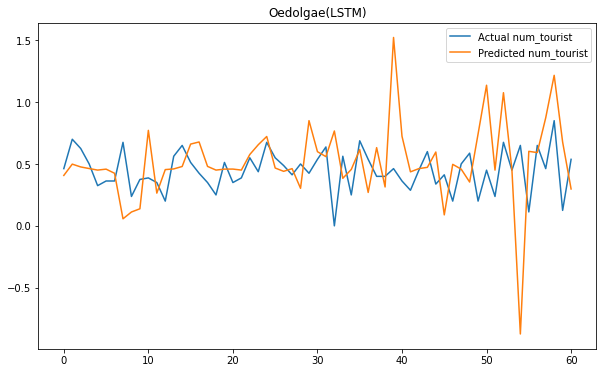

RMSE: 0.1192119025592527
Epoch: 0, loss: 0.24596
Epoch: 100, loss: 0.05650
Epoch: 200, loss: 0.05216
Epoch: 300, loss: 0.05003
Epoch: 400, loss: 0.05063
Epoch: 500, loss: 0.03754
Epoch: 600, loss: 0.03666
Epoch: 700, loss: 0.04042
Epoch: 800, loss: 0.04316
Epoch: 900, loss: 0.03865
Epoch: 1000, loss: 0.03619
Epoch: 1100, loss: 0.03255
Epoch: 1200, loss: 0.02499
Epoch: 1300, loss: 0.03700
Epoch: 1400, loss: 0.02025
Epoch: 1500, loss: 0.02459
Epoch: 1600, loss: 0.03117
Epoch: 1700, loss: 0.03084
Epoch: 1800, loss: 0.02297
Epoch: 1900, loss: 0.03040
Epoch: 2000, loss: 0.03172
Epoch: 2100, loss: 0.02683
Epoch: 2200, loss: 0.02817
Epoch: 2300, loss: 0.02991
Epoch: 2400, loss: 0.04548
Epoch: 2500, loss: 0.02754
Epoch: 2600, loss: 0.01821
Epoch: 2700, loss: 0.02934
Epoch: 2800, loss: 0.01586
Epoch: 2900, loss: 0.02799
Epoch: 3000, loss: 0.02558
Epoch: 3100, loss: 0.02313
Epoch: 3200, loss: 0.03603
Epoch: 3300, loss: 0.02287
Epoch: 3400, loss: 0.03153
Epoch: 3500, loss: 0.02369
Epoch: 3600, lo

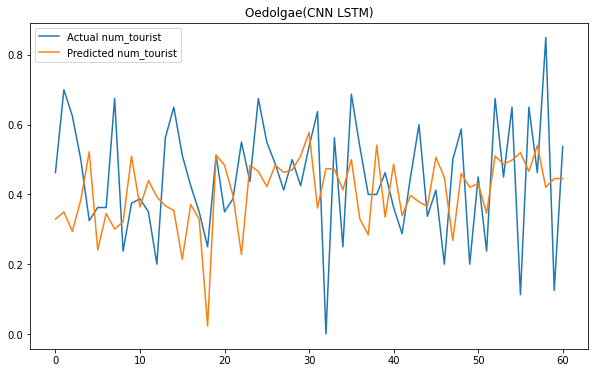

RMSE: 0.15858237996239105
Epoch: 0, loss: 0.16816
Epoch: 100, loss: 0.02841
Epoch: 200, loss: 0.02559
Epoch: 300, loss: 0.02432
Epoch: 400, loss: 0.02239
Epoch: 500, loss: 0.02073
Epoch: 600, loss: 0.01961
Epoch: 700, loss: 0.01884
Epoch: 800, loss: 0.01830
Epoch: 900, loss: 0.01790
Epoch: 1000, loss: 0.01765
Epoch: 1100, loss: 0.01748
Epoch: 1200, loss: 0.01736
Epoch: 1300, loss: 0.01725
Epoch: 1400, loss: 0.01717
Epoch: 1500, loss: 0.01710
Epoch: 1600, loss: 0.01703
Epoch: 1700, loss: 0.01695
Epoch: 1800, loss: 0.01686
Epoch: 1900, loss: 0.01670
Epoch: 2000, loss: 0.01643
Epoch: 2100, loss: 0.01636
Epoch: 2200, loss: 0.01632
Epoch: 2300, loss: 0.01628
Epoch: 2400, loss: 0.01625
Epoch: 2500, loss: 0.01623
Epoch: 2600, loss: 0.01625
Epoch: 2700, loss: 0.01620
Epoch: 2800, loss: 0.01618
Epoch: 2900, loss: 0.01617
Epoch: 3000, loss: 0.01619
Epoch: 3100, loss: 0.01617
Epoch: 3200, loss: 0.01614
Epoch: 3300, loss: 0.01614
Epoch: 3400, loss: 0.01616
Epoch: 3500, loss: 0.01613
Epoch: 3600, l

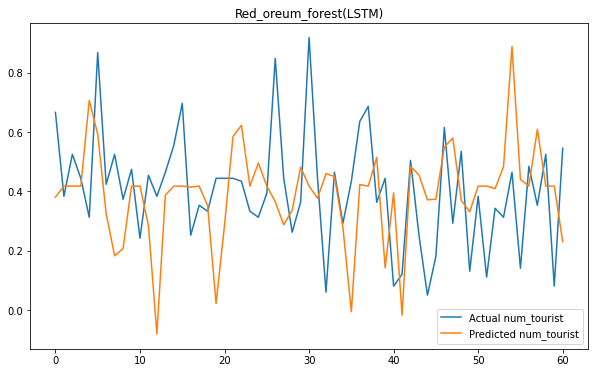

RMSE: 0.12360810399043956
Epoch: 0, loss: 0.09759
Epoch: 100, loss: 0.04707
Epoch: 200, loss: 0.04530
Epoch: 300, loss: 0.03745
Epoch: 400, loss: 0.03744
Epoch: 500, loss: 0.03041
Epoch: 600, loss: 0.02257
Epoch: 700, loss: 0.02855
Epoch: 800, loss: 0.01594
Epoch: 900, loss: 0.02827
Epoch: 1000, loss: 0.02635
Epoch: 1100, loss: 0.02148
Epoch: 1200, loss: 0.01729
Epoch: 1300, loss: 0.01833
Epoch: 1400, loss: 0.03330
Epoch: 1500, loss: 0.02064
Epoch: 1600, loss: 0.01203
Epoch: 1700, loss: 0.01801
Epoch: 1800, loss: 0.02525
Epoch: 1900, loss: 0.02186
Epoch: 2000, loss: 0.02066
Epoch: 2100, loss: 0.01940
Epoch: 2200, loss: 0.02061
Epoch: 2300, loss: 0.01484
Epoch: 2400, loss: 0.01773
Epoch: 2500, loss: 0.02716
Epoch: 2600, loss: 0.02109
Epoch: 2700, loss: 0.02613
Epoch: 2800, loss: 0.02132
Epoch: 2900, loss: 0.02660
Epoch: 3000, loss: 0.01704
Epoch: 3100, loss: 0.02568
Epoch: 3200, loss: 0.01759
Epoch: 3300, loss: 0.01774
Epoch: 3400, loss: 0.01870
Epoch: 3500, loss: 0.02240
Epoch: 3600, l

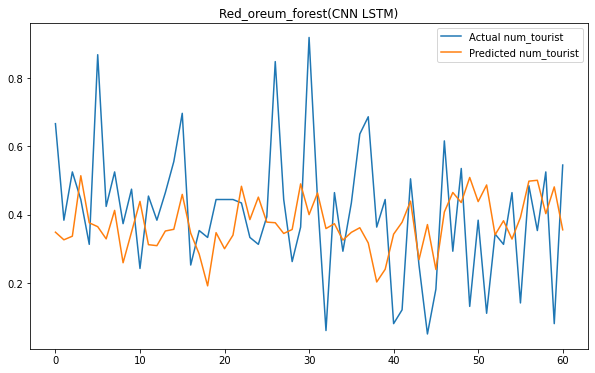

RMSE: 0.14012683607603396
Epoch: 0, loss: 0.05180
Epoch: 100, loss: 0.02133
Epoch: 200, loss: 0.01572
Epoch: 300, loss: 0.01446
Epoch: 400, loss: 0.01342
Epoch: 500, loss: 0.01219
Epoch: 600, loss: 0.01174
Epoch: 700, loss: 0.01143
Epoch: 800, loss: 0.01117
Epoch: 900, loss: 0.01094
Epoch: 1000, loss: 0.01082
Epoch: 1100, loss: 0.01056
Epoch: 1200, loss: 0.01038
Epoch: 1300, loss: 0.01017
Epoch: 1400, loss: 0.01010
Epoch: 1500, loss: 0.00989
Epoch: 1600, loss: 0.00973
Epoch: 1700, loss: 0.00960
Epoch: 1800, loss: 0.00945
Epoch: 1900, loss: 0.00938
Epoch: 2000, loss: 0.00922
Epoch: 2100, loss: 0.00911
Epoch: 2200, loss: 0.00909
Epoch: 2300, loss: 0.00903
Epoch: 2400, loss: 0.00896
Epoch: 2500, loss: 0.00882
Epoch: 2600, loss: 0.00860
Epoch: 2700, loss: 0.00845
Epoch: 2800, loss: 0.00840
Epoch: 2900, loss: 0.00834
Epoch: 3000, loss: 0.00822
Epoch: 3100, loss: 0.00810
Epoch: 3200, loss: 0.00805
Epoch: 3300, loss: 0.00801
Epoch: 3400, loss: 0.00794
Epoch: 3500, loss: 0.00781
Epoch: 3600, l

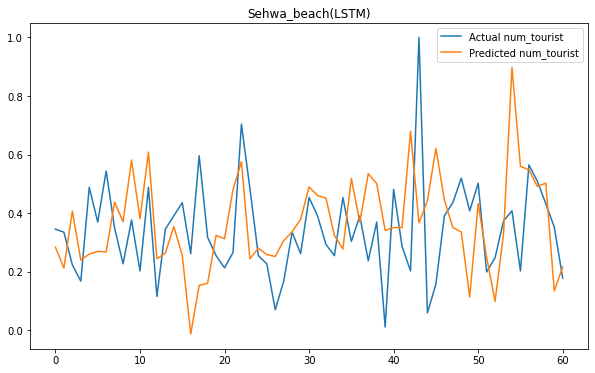

RMSE: 0.07957792485397519
Epoch: 0, loss: 0.11912
Epoch: 100, loss: 0.03543
Epoch: 200, loss: 0.03478
Epoch: 300, loss: 0.02845
Epoch: 400, loss: 0.02472
Epoch: 500, loss: 0.01851
Epoch: 600, loss: 0.01850
Epoch: 700, loss: 0.01521
Epoch: 800, loss: 0.01661
Epoch: 900, loss: 0.01800
Epoch: 1000, loss: 0.01383
Epoch: 1100, loss: 0.01674
Epoch: 1200, loss: 0.01187
Epoch: 1300, loss: 0.01437
Epoch: 1400, loss: 0.01098
Epoch: 1500, loss: 0.01304
Epoch: 1600, loss: 0.01390
Epoch: 1700, loss: 0.01272
Epoch: 1800, loss: 0.01487
Epoch: 1900, loss: 0.01836
Epoch: 2000, loss: 0.01358
Epoch: 2100, loss: 0.01307
Epoch: 2200, loss: 0.01287
Epoch: 2300, loss: 0.00974
Epoch: 2400, loss: 0.01900
Epoch: 2500, loss: 0.01355
Epoch: 2600, loss: 0.01103
Epoch: 2700, loss: 0.01389
Epoch: 2800, loss: 0.01737
Epoch: 2900, loss: 0.01198
Epoch: 3000, loss: 0.01593
Epoch: 3100, loss: 0.01801
Epoch: 3200, loss: 0.01635
Epoch: 3300, loss: 0.01253
Epoch: 3400, loss: 0.00963
Epoch: 3500, loss: 0.01490
Epoch: 3600, l

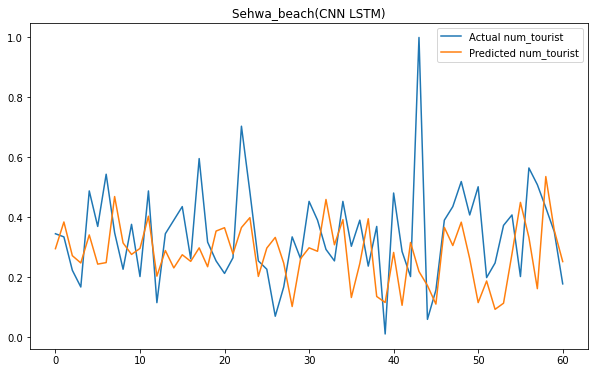

RMSE: 0.1395928532345509
Epoch: 0, loss: 0.04485
Epoch: 100, loss: 0.02959
Epoch: 200, loss: 0.02474
Epoch: 300, loss: 0.02174
Epoch: 400, loss: 0.02022
Epoch: 500, loss: 0.01879
Epoch: 600, loss: 0.01800
Epoch: 700, loss: 0.01754
Epoch: 800, loss: 0.01704
Epoch: 900, loss: 0.01653
Epoch: 1000, loss: 0.01621
Epoch: 1100, loss: 0.01551
Epoch: 1200, loss: 0.01517
Epoch: 1300, loss: 0.01478
Epoch: 1400, loss: 0.01459
Epoch: 1500, loss: 0.01423
Epoch: 1600, loss: 0.01394
Epoch: 1700, loss: 0.01367
Epoch: 1800, loss: 0.01350
Epoch: 1900, loss: 0.01332
Epoch: 2000, loss: 0.01313
Epoch: 2100, loss: 0.01295
Epoch: 2200, loss: 0.01281
Epoch: 2300, loss: 0.01269
Epoch: 2400, loss: 0.01272
Epoch: 2500, loss: 0.01250
Epoch: 2600, loss: 0.01239
Epoch: 2700, loss: 0.01232
Epoch: 2800, loss: 0.01215
Epoch: 2900, loss: 0.01202
Epoch: 3000, loss: 0.01198
Epoch: 3100, loss: 0.01188
Epoch: 3200, loss: 0.01177
Epoch: 3300, loss: 0.01171
Epoch: 3400, loss: 0.01162
Epoch: 3500, loss: 0.01153
Epoch: 3600, lo

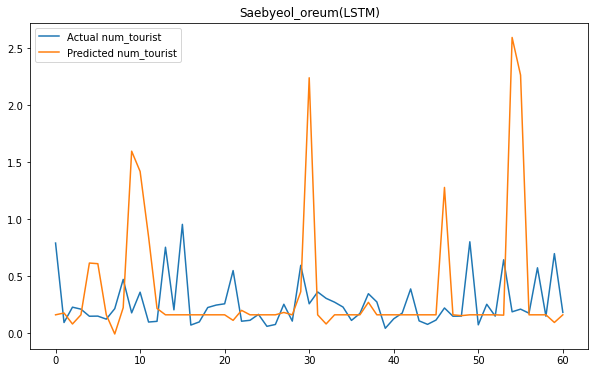

RMSE: 0.08918046229122414
Epoch: 0, loss: 0.08209
Epoch: 100, loss: 0.04104
Epoch: 200, loss: 0.02907
Epoch: 300, loss: 0.02939
Epoch: 400, loss: 0.02573
Epoch: 500, loss: 0.01817
Epoch: 600, loss: 0.01721
Epoch: 700, loss: 0.01809
Epoch: 800, loss: 0.01261
Epoch: 900, loss: 0.01412
Epoch: 1000, loss: 0.02249
Epoch: 1100, loss: 0.00964
Epoch: 1200, loss: 0.01355
Epoch: 1300, loss: 0.01221
Epoch: 1400, loss: 0.01387
Epoch: 1500, loss: 0.00838
Epoch: 1600, loss: 0.01313
Epoch: 1700, loss: 0.00521
Epoch: 1800, loss: 0.00928
Epoch: 1900, loss: 0.01197
Epoch: 2000, loss: 0.01420
Epoch: 2100, loss: 0.00737
Epoch: 2200, loss: 0.00872
Epoch: 2300, loss: 0.01291
Epoch: 2400, loss: 0.01331
Epoch: 2500, loss: 0.01944
Epoch: 2600, loss: 0.01237
Epoch: 2700, loss: 0.01224
Epoch: 2800, loss: 0.00937
Epoch: 2900, loss: 0.01332
Epoch: 3000, loss: 0.00775
Epoch: 3100, loss: 0.01386
Epoch: 3200, loss: 0.01308
Epoch: 3300, loss: 0.01595
Epoch: 3400, loss: 0.01311
Epoch: 3500, loss: 0.01791
Epoch: 3600, l

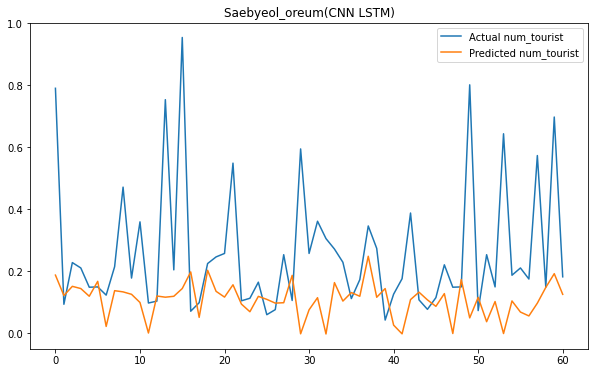

RMSE: 0.09745533779929327
Epoch: 0, loss: 0.20355
Epoch: 100, loss: 0.01848
Epoch: 200, loss: 0.01620
Epoch: 300, loss: 0.01312
Epoch: 400, loss: 0.01205
Epoch: 500, loss: 0.01067
Epoch: 600, loss: 0.00912
Epoch: 700, loss: 0.00780
Epoch: 800, loss: 0.00681
Epoch: 900, loss: 0.00639
Epoch: 1000, loss: 0.00588
Epoch: 1100, loss: 0.00550
Epoch: 1200, loss: 0.00527
Epoch: 1300, loss: 0.00494
Epoch: 1400, loss: 0.00483
Epoch: 1500, loss: 0.00461
Epoch: 1600, loss: 0.00444
Epoch: 1700, loss: 0.00431
Epoch: 1800, loss: 0.00422
Epoch: 1900, loss: 0.00413
Epoch: 2000, loss: 0.00409
Epoch: 2100, loss: 0.00395
Epoch: 2200, loss: 0.00385
Epoch: 2300, loss: 0.00383
Epoch: 2400, loss: 0.00372
Epoch: 2500, loss: 0.00366
Epoch: 2600, loss: 0.00362
Epoch: 2700, loss: 0.00357
Epoch: 2800, loss: 0.00351
Epoch: 2900, loss: 0.00354
Epoch: 3000, loss: 0.00359
Epoch: 3100, loss: 0.00339
Epoch: 3200, loss: 0.00338
Epoch: 3300, loss: 0.00342
Epoch: 3400, loss: 0.00330
Epoch: 3500, loss: 0.00328
Epoch: 3600, l

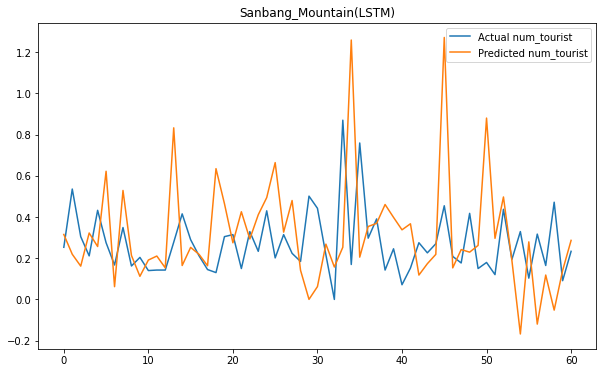

RMSE: 0.044694173112884775
Epoch: 0, loss: 0.08481
Epoch: 100, loss: 0.02664
Epoch: 200, loss: 0.02185
Epoch: 300, loss: 0.01857
Epoch: 400, loss: 0.01793
Epoch: 500, loss: 0.01266
Epoch: 600, loss: 0.01377
Epoch: 700, loss: 0.01388
Epoch: 800, loss: 0.01240
Epoch: 900, loss: 0.01422
Epoch: 1000, loss: 0.00794
Epoch: 1100, loss: 0.01315
Epoch: 1200, loss: 0.00867
Epoch: 1300, loss: 0.00633
Epoch: 1400, loss: 0.01597
Epoch: 1500, loss: 0.01014
Epoch: 1600, loss: 0.00954
Epoch: 1700, loss: 0.01187
Epoch: 1800, loss: 0.01127
Epoch: 1900, loss: 0.01016
Epoch: 2000, loss: 0.00680
Epoch: 2100, loss: 0.00777
Epoch: 2200, loss: 0.00958
Epoch: 2300, loss: 0.00904
Epoch: 2400, loss: 0.01505
Epoch: 2500, loss: 0.00766
Epoch: 2600, loss: 0.01297
Epoch: 2700, loss: 0.01400
Epoch: 2800, loss: 0.01025
Epoch: 2900, loss: 0.01092
Epoch: 3000, loss: 0.01004
Epoch: 3100, loss: 0.00981
Epoch: 3200, loss: 0.01519
Epoch: 3300, loss: 0.01041
Epoch: 3400, loss: 0.00910
Epoch: 3500, loss: 0.00634
Epoch: 3600, 

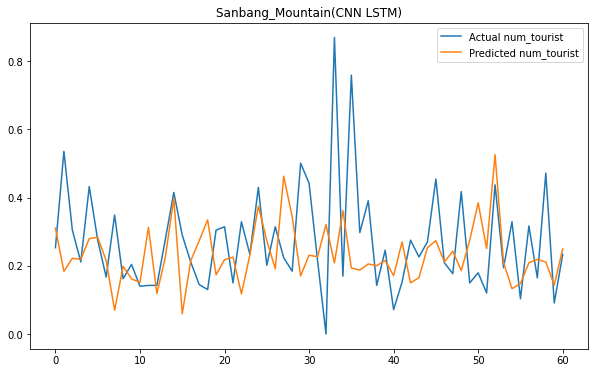

RMSE: 0.11227202977232378
Epoch: 0, loss: 0.08510
Epoch: 100, loss: 0.02678
Epoch: 200, loss: 0.02250
Epoch: 300, loss: 0.01965
Epoch: 400, loss: 0.01790
Epoch: 500, loss: 0.01695
Epoch: 600, loss: 0.01637
Epoch: 700, loss: 0.01569
Epoch: 800, loss: 0.01495
Epoch: 900, loss: 0.01442
Epoch: 1000, loss: 0.01408
Epoch: 1100, loss: 0.01370
Epoch: 1200, loss: 0.01349
Epoch: 1300, loss: 0.01328
Epoch: 1400, loss: 0.01297
Epoch: 1500, loss: 0.01283
Epoch: 1600, loss: 0.01269
Epoch: 1700, loss: 0.01259
Epoch: 1800, loss: 0.01250
Epoch: 1900, loss: 0.01245
Epoch: 2000, loss: 0.01241
Epoch: 2100, loss: 0.01233
Epoch: 2200, loss: 0.01228
Epoch: 2300, loss: 0.01225
Epoch: 2400, loss: 0.01220
Epoch: 2500, loss: 0.01217
Epoch: 2600, loss: 0.01230
Epoch: 2700, loss: 0.01209
Epoch: 2800, loss: 0.01258
Epoch: 2900, loss: 0.01216
Epoch: 3000, loss: 0.01210
Epoch: 3100, loss: 0.01203
Epoch: 3200, loss: 0.01194
Epoch: 3300, loss: 0.01197
Epoch: 3400, loss: 0.01191
Epoch: 3500, loss: 0.01200
Epoch: 3600, l

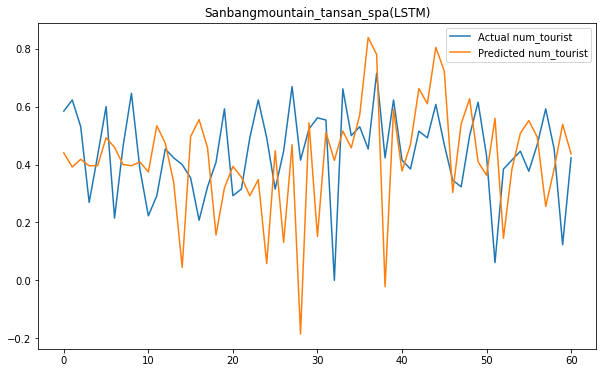

RMSE: 0.10154998225318063
Epoch: 0, loss: 0.26406
Epoch: 100, loss: 0.05911
Epoch: 200, loss: 0.05854
Epoch: 300, loss: 0.04447
Epoch: 400, loss: 0.04702
Epoch: 500, loss: 0.05021
Epoch: 600, loss: 0.04589
Epoch: 700, loss: 0.03837
Epoch: 800, loss: 0.04050
Epoch: 900, loss: 0.03291
Epoch: 1000, loss: 0.03059
Epoch: 1100, loss: 0.03710
Epoch: 1200, loss: 0.02823
Epoch: 1300, loss: 0.03685
Epoch: 1400, loss: 0.03511
Epoch: 1500, loss: 0.03034
Epoch: 1600, loss: 0.02854
Epoch: 1700, loss: 0.02433
Epoch: 1800, loss: 0.03709
Epoch: 1900, loss: 0.01870
Epoch: 2000, loss: 0.03160
Epoch: 2100, loss: 0.02778
Epoch: 2200, loss: 0.03294
Epoch: 2300, loss: 0.03078
Epoch: 2400, loss: 0.02256
Epoch: 2500, loss: 0.02945
Epoch: 2600, loss: 0.02811
Epoch: 2700, loss: 0.02440
Epoch: 2800, loss: 0.03200
Epoch: 2900, loss: 0.02799
Epoch: 3000, loss: 0.02848
Epoch: 3100, loss: 0.02470
Epoch: 3200, loss: 0.02090
Epoch: 3300, loss: 0.02973
Epoch: 3400, loss: 0.02106
Epoch: 3500, loss: 0.02104
Epoch: 3600, l

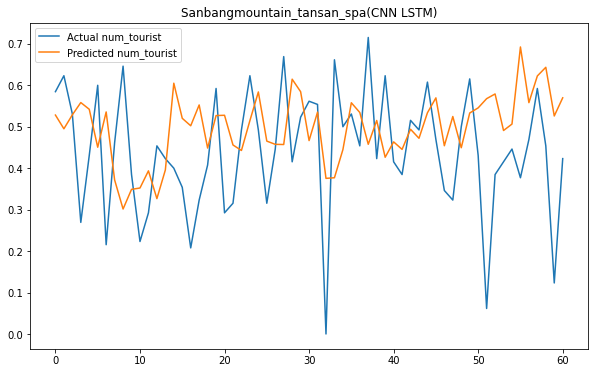

RMSE: 0.15953487133395686
Epoch: 0, loss: 0.18239
Epoch: 100, loss: 0.03086
Epoch: 200, loss: 0.02740
Epoch: 300, loss: 0.02140
Epoch: 400, loss: 0.01971
Epoch: 500, loss: 0.01858
Epoch: 600, loss: 0.01737
Epoch: 700, loss: 0.01576
Epoch: 800, loss: 0.01476
Epoch: 900, loss: 0.01404
Epoch: 1000, loss: 0.01344
Epoch: 1100, loss: 0.01300
Epoch: 1200, loss: 0.01235
Epoch: 1300, loss: 0.01189
Epoch: 1400, loss: 0.01148
Epoch: 1500, loss: 0.01107
Epoch: 1600, loss: 0.01066
Epoch: 1700, loss: 0.01005
Epoch: 1800, loss: 0.00981
Epoch: 1900, loss: 0.00954
Epoch: 2000, loss: 0.00941
Epoch: 2100, loss: 0.00917
Epoch: 2200, loss: 0.00912
Epoch: 2300, loss: 0.00895
Epoch: 2400, loss: 0.00879
Epoch: 2500, loss: 0.00866
Epoch: 2600, loss: 0.00853
Epoch: 2700, loss: 0.00826
Epoch: 2800, loss: 0.00810
Epoch: 2900, loss: 0.00790
Epoch: 3000, loss: 0.00773
Epoch: 3100, loss: 0.00759
Epoch: 3200, loss: 0.00748
Epoch: 3300, loss: 0.00746
Epoch: 3400, loss: 0.00732
Epoch: 3500, loss: 0.00717
Epoch: 3600, l

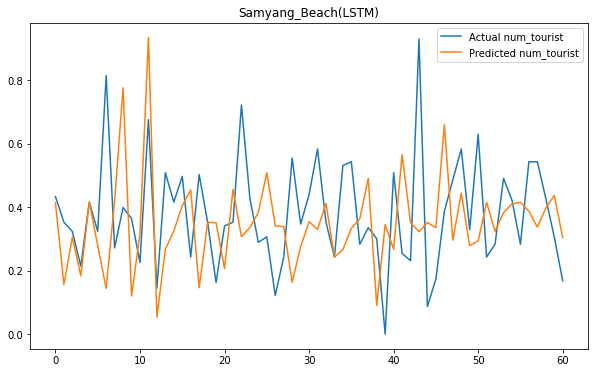

RMSE: 0.06550003298433762
Epoch: 0, loss: 0.17558
Epoch: 100, loss: 0.04348
Epoch: 200, loss: 0.04478
Epoch: 300, loss: 0.05331
Epoch: 400, loss: 0.04028
Epoch: 500, loss: 0.03239
Epoch: 600, loss: 0.03093
Epoch: 700, loss: 0.02960
Epoch: 800, loss: 0.02349
Epoch: 900, loss: 0.02288
Epoch: 1000, loss: 0.02631
Epoch: 1100, loss: 0.02198
Epoch: 1200, loss: 0.02054
Epoch: 1300, loss: 0.02362
Epoch: 1400, loss: 0.02507
Epoch: 1500, loss: 0.02333
Epoch: 1600, loss: 0.01608
Epoch: 1700, loss: 0.02025
Epoch: 1800, loss: 0.01781
Epoch: 1900, loss: 0.01707
Epoch: 2000, loss: 0.01979
Epoch: 2100, loss: 0.02079
Epoch: 2200, loss: 0.01802
Epoch: 2300, loss: 0.02066
Epoch: 2400, loss: 0.01941
Epoch: 2500, loss: 0.02110
Epoch: 2600, loss: 0.01684
Epoch: 2700, loss: 0.01765
Epoch: 2800, loss: 0.01516
Epoch: 2900, loss: 0.02212
Epoch: 3000, loss: 0.01929
Epoch: 3100, loss: 0.02071
Epoch: 3200, loss: 0.01801
Epoch: 3300, loss: 0.01658
Epoch: 3400, loss: 0.01355
Epoch: 3500, loss: 0.01446
Epoch: 3600, l

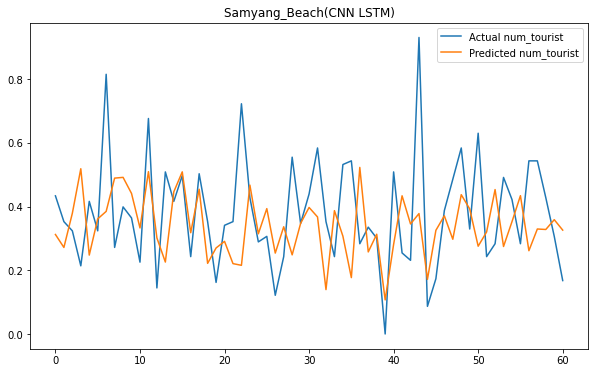

RMSE: 0.1418742940586861
Epoch: 0, loss: 0.47356
Epoch: 100, loss: 0.02447
Epoch: 200, loss: 0.02369
Epoch: 300, loss: 0.02247
Epoch: 400, loss: 0.02122
Epoch: 500, loss: 0.02050
Epoch: 600, loss: 0.02011
Epoch: 700, loss: 0.01985
Epoch: 800, loss: 0.01958
Epoch: 900, loss: 0.01910
Epoch: 1000, loss: 0.01779
Epoch: 1100, loss: 0.01720
Epoch: 1200, loss: 0.01664
Epoch: 1300, loss: 0.01596
Epoch: 1400, loss: 0.01541
Epoch: 1500, loss: 0.01502
Epoch: 1600, loss: 0.01470
Epoch: 1700, loss: 0.01441
Epoch: 1800, loss: 0.01402
Epoch: 1900, loss: 0.01363
Epoch: 2000, loss: 0.01339
Epoch: 2100, loss: 0.01311
Epoch: 2200, loss: 0.01261
Epoch: 2300, loss: 0.01245
Epoch: 2400, loss: 0.01224
Epoch: 2500, loss: 0.01206
Epoch: 2600, loss: 0.01194
Epoch: 2700, loss: 0.01182
Epoch: 2800, loss: 0.01166
Epoch: 2900, loss: 0.01154
Epoch: 3000, loss: 0.01141
Epoch: 3100, loss: 0.01134
Epoch: 3200, loss: 0.01130
Epoch: 3300, loss: 0.01125
Epoch: 3400, loss: 0.01121
Epoch: 3500, loss: 0.01114
Epoch: 3600, lo

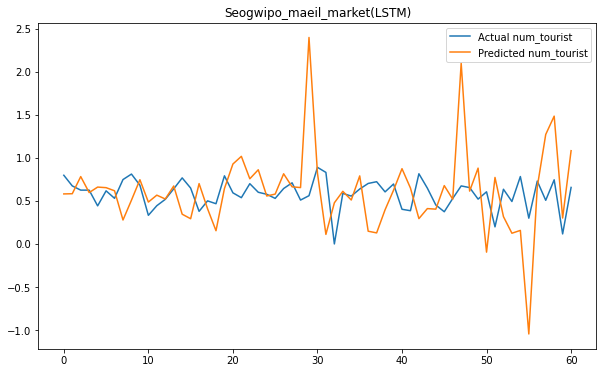

RMSE: 0.09891150071156236
Epoch: 0, loss: 0.40180
Epoch: 100, loss: 0.08544
Epoch: 200, loss: 0.09355
Epoch: 300, loss: 0.06262
Epoch: 400, loss: 0.05736
Epoch: 500, loss: 0.05740
Epoch: 600, loss: 0.04729
Epoch: 700, loss: 0.05647
Epoch: 800, loss: 0.05101
Epoch: 900, loss: 0.06194
Epoch: 1000, loss: 0.04654
Epoch: 1100, loss: 0.06270
Epoch: 1200, loss: 0.05273
Epoch: 1300, loss: 0.05266
Epoch: 1400, loss: 0.04725
Epoch: 1500, loss: 0.03895
Epoch: 1600, loss: 0.03135
Epoch: 1700, loss: 0.04591
Epoch: 1800, loss: 0.04911
Epoch: 1900, loss: 0.04736
Epoch: 2000, loss: 0.03712
Epoch: 2100, loss: 0.03940
Epoch: 2200, loss: 0.04834
Epoch: 2300, loss: 0.03843
Epoch: 2400, loss: 0.02955
Epoch: 2500, loss: 0.04613
Epoch: 2600, loss: 0.05120
Epoch: 2700, loss: 0.05241
Epoch: 2800, loss: 0.04768
Epoch: 2900, loss: 0.03217
Epoch: 3000, loss: 0.03476
Epoch: 3100, loss: 0.05445
Epoch: 3200, loss: 0.04485
Epoch: 3300, loss: 0.07090
Epoch: 3400, loss: 0.05866
Epoch: 3500, loss: 0.04378
Epoch: 3600, l

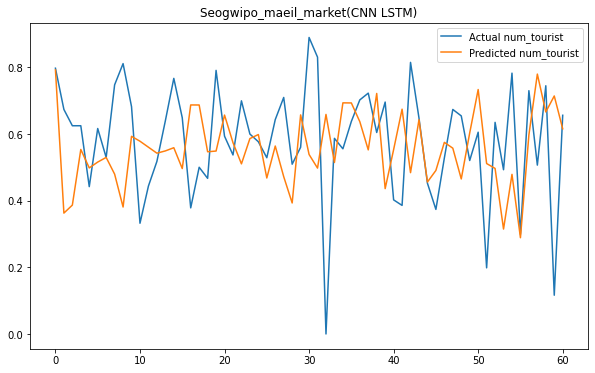

RMSE: 0.20800676479881666
Epoch: 0, loss: 0.10709
Epoch: 100, loss: 0.03109
Epoch: 200, loss: 0.02501
Epoch: 300, loss: 0.02195
Epoch: 400, loss: 0.02050
Epoch: 500, loss: 0.01944
Epoch: 600, loss: 0.01864
Epoch: 700, loss: 0.01775
Epoch: 800, loss: 0.01719
Epoch: 900, loss: 0.01678
Epoch: 1000, loss: 0.01644
Epoch: 1100, loss: 0.01619
Epoch: 1200, loss: 0.01588
Epoch: 1300, loss: 0.01569
Epoch: 1400, loss: 0.01557
Epoch: 1500, loss: 0.01530
Epoch: 1600, loss: 0.01500
Epoch: 1700, loss: 0.01475
Epoch: 1800, loss: 0.01450
Epoch: 1900, loss: 0.01430
Epoch: 2000, loss: 0.01413
Epoch: 2100, loss: 0.01376
Epoch: 2200, loss: 0.01358
Epoch: 2300, loss: 0.01349
Epoch: 2400, loss: 0.01324
Epoch: 2500, loss: 0.01309
Epoch: 2600, loss: 0.01297
Epoch: 2700, loss: 0.01282
Epoch: 2800, loss: 0.01264
Epoch: 2900, loss: 0.01254
Epoch: 3000, loss: 0.01280
Epoch: 3100, loss: 0.01229
Epoch: 3200, loss: 0.01220
Epoch: 3300, loss: 0.01207
Epoch: 3400, loss: 0.01202
Epoch: 3500, loss: 0.01189
Epoch: 3600, l

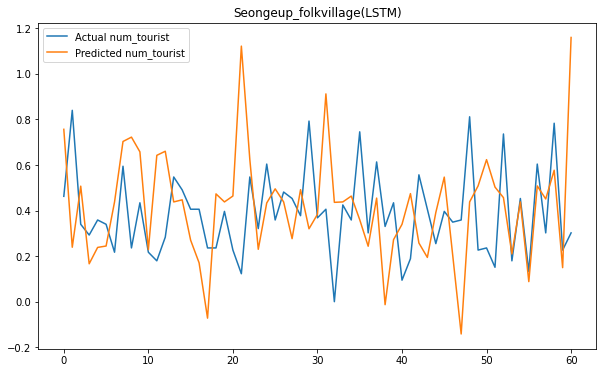

RMSE: 0.09810022521241027
Epoch: 0, loss: 0.14765
Epoch: 100, loss: 0.04274
Epoch: 200, loss: 0.04763
Epoch: 300, loss: 0.03999
Epoch: 400, loss: 0.03445
Epoch: 500, loss: 0.02397
Epoch: 600, loss: 0.01639
Epoch: 700, loss: 0.02614
Epoch: 800, loss: 0.01320
Epoch: 900, loss: 0.02155
Epoch: 1000, loss: 0.01788
Epoch: 1100, loss: 0.02645
Epoch: 1200, loss: 0.01434
Epoch: 1300, loss: 0.01636
Epoch: 1400, loss: 0.01868
Epoch: 1500, loss: 0.01542
Epoch: 1600, loss: 0.02226
Epoch: 1700, loss: 0.01706
Epoch: 1800, loss: 0.02132
Epoch: 1900, loss: 0.02336
Epoch: 2000, loss: 0.01061
Epoch: 2100, loss: 0.02141
Epoch: 2200, loss: 0.02687
Epoch: 2300, loss: 0.00974
Epoch: 2400, loss: 0.02102
Epoch: 2500, loss: 0.01538
Epoch: 2600, loss: 0.01997
Epoch: 2700, loss: 0.02466
Epoch: 2800, loss: 0.01637
Epoch: 2900, loss: 0.01514
Epoch: 3000, loss: 0.01909
Epoch: 3100, loss: 0.01694
Epoch: 3200, loss: 0.01254
Epoch: 3300, loss: 0.02348
Epoch: 3400, loss: 0.02537
Epoch: 3500, loss: 0.01724
Epoch: 3600, l

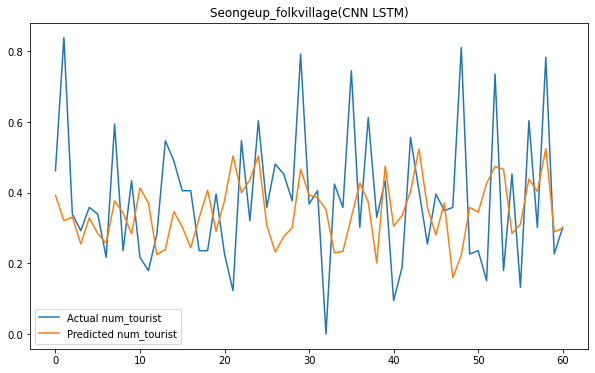

RMSE: 0.13050492521835516
Epoch: 0, loss: 0.21374
Epoch: 100, loss: 0.02512
Epoch: 200, loss: 0.02119
Epoch: 300, loss: 0.01677
Epoch: 400, loss: 0.01567
Epoch: 500, loss: 0.01521
Epoch: 600, loss: 0.01499
Epoch: 700, loss: 0.01473
Epoch: 800, loss: 0.01451
Epoch: 900, loss: 0.01381
Epoch: 1000, loss: 0.01305
Epoch: 1100, loss: 0.01255
Epoch: 1200, loss: 0.01222
Epoch: 1300, loss: 0.01200
Epoch: 1400, loss: 0.01179
Epoch: 1500, loss: 0.01168
Epoch: 1600, loss: 0.01150
Epoch: 1700, loss: 0.01135
Epoch: 1800, loss: 0.01113
Epoch: 1900, loss: 0.01096
Epoch: 2000, loss: 0.01083
Epoch: 2100, loss: 0.01072
Epoch: 2200, loss: 0.01063
Epoch: 2300, loss: 0.01056
Epoch: 2400, loss: 0.01048
Epoch: 2500, loss: 0.01041
Epoch: 2600, loss: 0.01037
Epoch: 2700, loss: 0.01024
Epoch: 2800, loss: 0.01022
Epoch: 2900, loss: 0.01011
Epoch: 3000, loss: 0.01002
Epoch: 3100, loss: 0.00995
Epoch: 3200, loss: 0.00990
Epoch: 3300, loss: 0.00979
Epoch: 3400, loss: 0.00973
Epoch: 3500, loss: 0.00969
Epoch: 3600, l

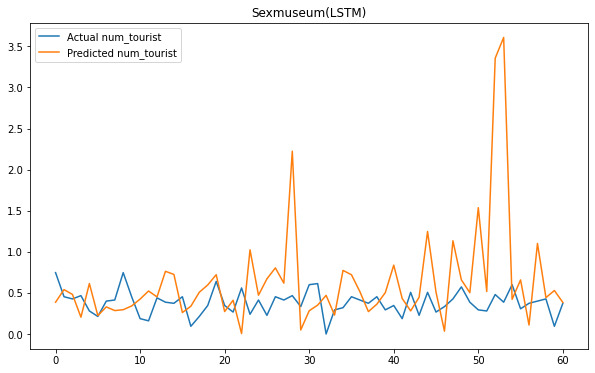

RMSE: 0.0833710269194012
Epoch: 0, loss: 0.21988
Epoch: 100, loss: 0.04857
Epoch: 200, loss: 0.04880
Epoch: 300, loss: 0.04705
Epoch: 400, loss: 0.03977
Epoch: 500, loss: 0.03521
Epoch: 600, loss: 0.03317
Epoch: 700, loss: 0.04158
Epoch: 800, loss: 0.03458
Epoch: 900, loss: 0.02755
Epoch: 1000, loss: 0.02943
Epoch: 1100, loss: 0.01948
Epoch: 1200, loss: 0.01564
Epoch: 1300, loss: 0.02867
Epoch: 1400, loss: 0.02666
Epoch: 1500, loss: 0.02234
Epoch: 1600, loss: 0.01861
Epoch: 1700, loss: 0.02406
Epoch: 1800, loss: 0.01962
Epoch: 1900, loss: 0.02148
Epoch: 2000, loss: 0.03235
Epoch: 2100, loss: 0.02048
Epoch: 2200, loss: 0.02826
Epoch: 2300, loss: 0.02537
Epoch: 2400, loss: 0.01324
Epoch: 2500, loss: 0.02366
Epoch: 2600, loss: 0.03053
Epoch: 2700, loss: 0.03191
Epoch: 2800, loss: 0.01624
Epoch: 2900, loss: 0.02907
Epoch: 3000, loss: 0.01972
Epoch: 3100, loss: 0.02786
Epoch: 3200, loss: 0.01734
Epoch: 3300, loss: 0.02831
Epoch: 3400, loss: 0.02441
Epoch: 3500, loss: 0.02430
Epoch: 3600, lo

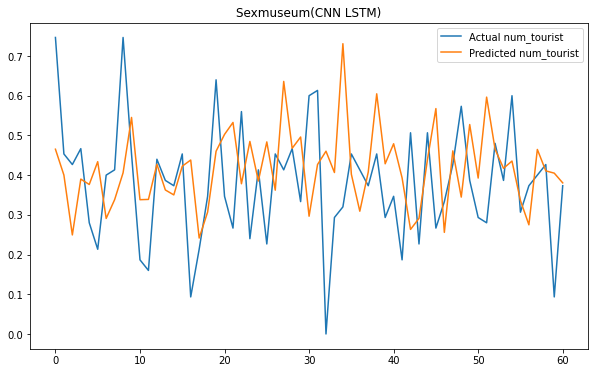

RMSE: 0.12719096133374933
Epoch: 0, loss: 0.13503
Epoch: 100, loss: 0.02791
Epoch: 200, loss: 0.02573
Epoch: 300, loss: 0.02294
Epoch: 400, loss: 0.02133
Epoch: 500, loss: 0.02007
Epoch: 600, loss: 0.01869
Epoch: 700, loss: 0.01766
Epoch: 800, loss: 0.01677
Epoch: 900, loss: 0.01619
Epoch: 1000, loss: 0.01571
Epoch: 1100, loss: 0.01512
Epoch: 1200, loss: 0.01476
Epoch: 1300, loss: 0.01441
Epoch: 1400, loss: 0.01398
Epoch: 1500, loss: 0.01358
Epoch: 1600, loss: 0.01331
Epoch: 1700, loss: 0.01304
Epoch: 1800, loss: 0.01260
Epoch: 1900, loss: 0.01244
Epoch: 2000, loss: 0.01221
Epoch: 2100, loss: 0.01204
Epoch: 2200, loss: 0.01213
Epoch: 2300, loss: 0.01192
Epoch: 2400, loss: 0.01170
Epoch: 2500, loss: 0.01164
Epoch: 2600, loss: 0.01146
Epoch: 2700, loss: 0.01128
Epoch: 2800, loss: 0.01125
Epoch: 2900, loss: 0.01120
Epoch: 3000, loss: 0.01096
Epoch: 3100, loss: 0.01108
Epoch: 3200, loss: 0.01099
Epoch: 3300, loss: 0.01090
Epoch: 3400, loss: 0.01084
Epoch: 3500, loss: 0.01096
Epoch: 3600, l

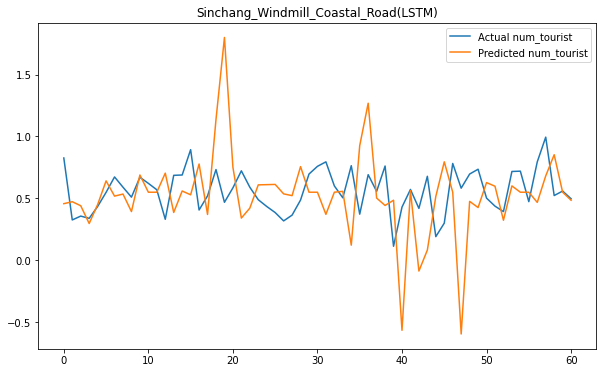

RMSE: 0.09526379622896604
Epoch: 0, loss: 0.27873
Epoch: 100, loss: 0.06120
Epoch: 200, loss: 0.05963
Epoch: 300, loss: 0.05073
Epoch: 400, loss: 0.04885
Epoch: 500, loss: 0.04431
Epoch: 600, loss: 0.04095
Epoch: 700, loss: 0.04567
Epoch: 800, loss: 0.03938
Epoch: 900, loss: 0.04582
Epoch: 1000, loss: 0.02827
Epoch: 1100, loss: 0.02350
Epoch: 1200, loss: 0.03760
Epoch: 1300, loss: 0.03125
Epoch: 1400, loss: 0.03449
Epoch: 1500, loss: 0.03505
Epoch: 1600, loss: 0.04372
Epoch: 1700, loss: 0.02445
Epoch: 1800, loss: 0.04133
Epoch: 1900, loss: 0.04545
Epoch: 2000, loss: 0.03310
Epoch: 2100, loss: 0.03664
Epoch: 2200, loss: 0.03041
Epoch: 2300, loss: 0.02212
Epoch: 2400, loss: 0.04092
Epoch: 2500, loss: 0.02579
Epoch: 2600, loss: 0.04113
Epoch: 2700, loss: 0.02722
Epoch: 2800, loss: 0.03480
Epoch: 2900, loss: 0.02163
Epoch: 3000, loss: 0.03353
Epoch: 3100, loss: 0.03639
Epoch: 3200, loss: 0.03047
Epoch: 3300, loss: 0.03850
Epoch: 3400, loss: 0.04247
Epoch: 3500, loss: 0.03173
Epoch: 3600, l

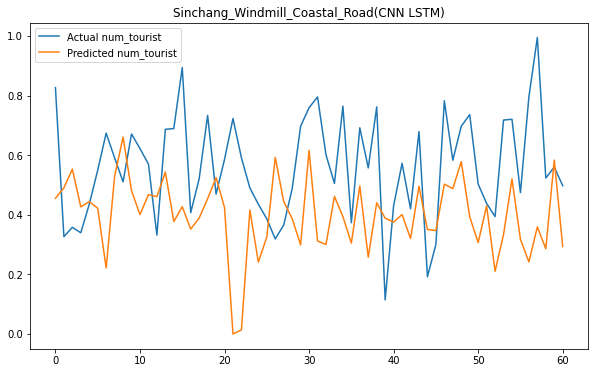

RMSE: 0.18911854212854862
Epoch: 0, loss: 0.13198
Epoch: 100, loss: 0.03519
Epoch: 200, loss: 0.03310
Epoch: 300, loss: 0.03200
Epoch: 400, loss: 0.03032
Epoch: 500, loss: 0.02859
Epoch: 600, loss: 0.02678
Epoch: 700, loss: 0.02621
Epoch: 800, loss: 0.02564
Epoch: 900, loss: 0.02371
Epoch: 1000, loss: 0.02334
Epoch: 1100, loss: 0.02317
Epoch: 1200, loss: 0.02299
Epoch: 1300, loss: 0.02268
Epoch: 1400, loss: 0.02228
Epoch: 1500, loss: 0.02196
Epoch: 1600, loss: 0.02176
Epoch: 1700, loss: 0.02162
Epoch: 1800, loss: 0.02140
Epoch: 1900, loss: 0.02126
Epoch: 2000, loss: 0.02108
Epoch: 2100, loss: 0.02087
Epoch: 2200, loss: 0.02067
Epoch: 2300, loss: 0.02053
Epoch: 2400, loss: 0.02041
Epoch: 2500, loss: 0.02037
Epoch: 2600, loss: 0.02019
Epoch: 2700, loss: 0.02009
Epoch: 2800, loss: 0.02002
Epoch: 2900, loss: 0.02002
Epoch: 3000, loss: 0.01986
Epoch: 3100, loss: 0.01979
Epoch: 3200, loss: 0.01968
Epoch: 3300, loss: 0.01958
Epoch: 3400, loss: 0.01948
Epoch: 3500, loss: 0.01942
Epoch: 3600, l

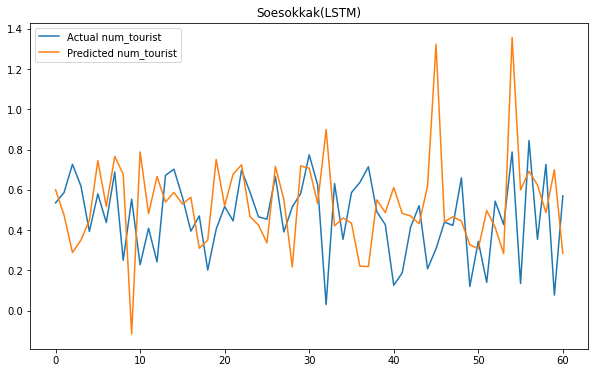

RMSE: 0.1330942923092995
Epoch: 0, loss: 0.22082
Epoch: 100, loss: 0.05620
Epoch: 200, loss: 0.05384
Epoch: 300, loss: 0.04602
Epoch: 400, loss: 0.04135
Epoch: 500, loss: 0.04342
Epoch: 600, loss: 0.03028
Epoch: 700, loss: 0.04289
Epoch: 800, loss: 0.02580
Epoch: 900, loss: 0.02329
Epoch: 1000, loss: 0.04020
Epoch: 1100, loss: 0.02504
Epoch: 1200, loss: 0.03017
Epoch: 1300, loss: 0.02559
Epoch: 1400, loss: 0.01935
Epoch: 1500, loss: 0.02701
Epoch: 1600, loss: 0.02811
Epoch: 1700, loss: 0.02237
Epoch: 1800, loss: 0.03492
Epoch: 1900, loss: 0.02393
Epoch: 2000, loss: 0.03058
Epoch: 2100, loss: 0.02101
Epoch: 2200, loss: 0.02296
Epoch: 2300, loss: 0.02657
Epoch: 2400, loss: 0.02403
Epoch: 2500, loss: 0.01767
Epoch: 2600, loss: 0.02828
Epoch: 2700, loss: 0.02501
Epoch: 2800, loss: 0.02684
Epoch: 2900, loss: 0.02653
Epoch: 3000, loss: 0.02138
Epoch: 3100, loss: 0.02684
Epoch: 3200, loss: 0.02824
Epoch: 3300, loss: 0.02023
Epoch: 3400, loss: 0.01857
Epoch: 3500, loss: 0.02851
Epoch: 3600, lo

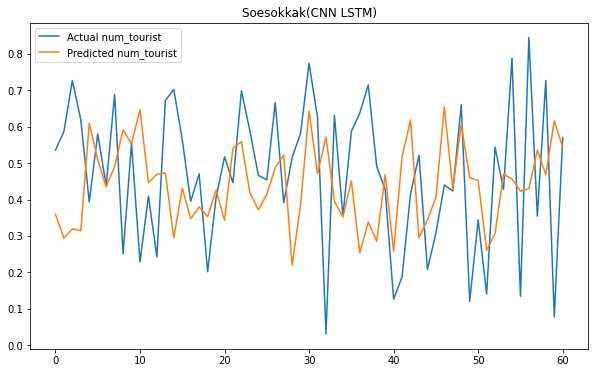

RMSE: 0.1539075926417154
Epoch: 0, loss: 0.31651
Epoch: 100, loss: 0.02483
Epoch: 200, loss: 0.01956
Epoch: 300, loss: 0.01698
Epoch: 400, loss: 0.01591
Epoch: 500, loss: 0.01491
Epoch: 600, loss: 0.01398
Epoch: 700, loss: 0.01334
Epoch: 800, loss: 0.01287
Epoch: 900, loss: 0.01250
Epoch: 1000, loss: 0.01231
Epoch: 1100, loss: 0.01215
Epoch: 1200, loss: 0.01202
Epoch: 1300, loss: 0.01186
Epoch: 1400, loss: 0.01166
Epoch: 1500, loss: 0.01150
Epoch: 1600, loss: 0.01135
Epoch: 1700, loss: 0.01119
Epoch: 1800, loss: 0.01091
Epoch: 1900, loss: 0.01067
Epoch: 2000, loss: 0.01044
Epoch: 2100, loss: 0.01027
Epoch: 2200, loss: 0.01009
Epoch: 2300, loss: 0.00990
Epoch: 2400, loss: 0.00978
Epoch: 2500, loss: 0.00965
Epoch: 2600, loss: 0.00969
Epoch: 2700, loss: 0.00938
Epoch: 2800, loss: 0.00911
Epoch: 2900, loss: 0.00891
Epoch: 3000, loss: 0.00868
Epoch: 3100, loss: 0.00857
Epoch: 3200, loss: 0.00824
Epoch: 3300, loss: 0.00807
Epoch: 3400, loss: 0.00786
Epoch: 3500, loss: 0.00768
Epoch: 3600, lo

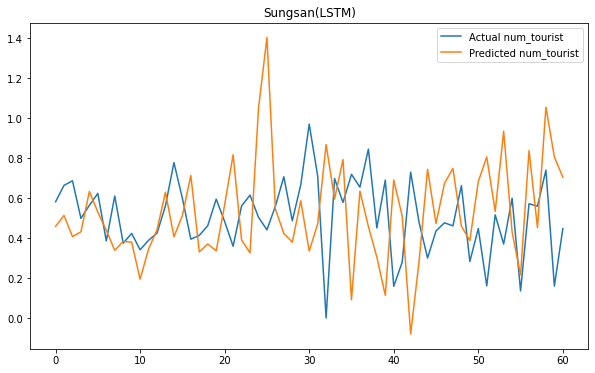

RMSE: 0.057232339261482926
Epoch: 0, loss: 0.26483
Epoch: 100, loss: 0.05202
Epoch: 200, loss: 0.06446
Epoch: 300, loss: 0.03862
Epoch: 400, loss: 0.03606
Epoch: 500, loss: 0.05241
Epoch: 600, loss: 0.04387
Epoch: 700, loss: 0.04365
Epoch: 800, loss: 0.03182
Epoch: 900, loss: 0.02441
Epoch: 1000, loss: 0.02705
Epoch: 1100, loss: 0.03339
Epoch: 1200, loss: 0.03712
Epoch: 1300, loss: 0.02961
Epoch: 1400, loss: 0.02945
Epoch: 1500, loss: 0.02484
Epoch: 1600, loss: 0.03405
Epoch: 1700, loss: 0.03041
Epoch: 1800, loss: 0.03619
Epoch: 1900, loss: 0.02514
Epoch: 2000, loss: 0.02757
Epoch: 2100, loss: 0.02984
Epoch: 2200, loss: 0.02313
Epoch: 2300, loss: 0.03521
Epoch: 2400, loss: 0.02462
Epoch: 2500, loss: 0.04239
Epoch: 2600, loss: 0.02805
Epoch: 2700, loss: 0.02941
Epoch: 2800, loss: 0.03292
Epoch: 2900, loss: 0.03053
Epoch: 3000, loss: 0.02546
Epoch: 3100, loss: 0.02209
Epoch: 3200, loss: 0.02930
Epoch: 3300, loss: 0.03483
Epoch: 3400, loss: 0.03362
Epoch: 3500, loss: 0.02280
Epoch: 3600, 

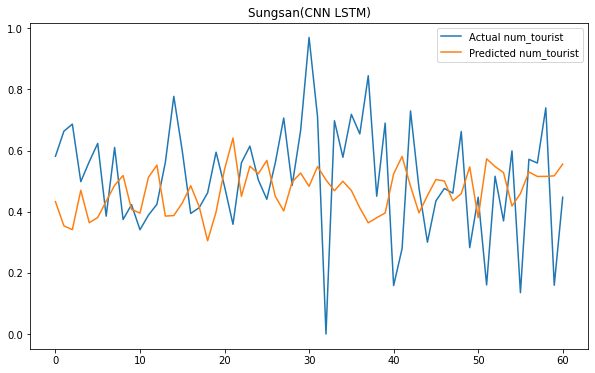

RMSE: 0.1549241497875034
Epoch: 0, loss: 0.37435
Epoch: 100, loss: 0.02799
Epoch: 200, loss: 0.02596
Epoch: 300, loss: 0.02414
Epoch: 400, loss: 0.02155
Epoch: 500, loss: 0.01891
Epoch: 600, loss: 0.01631
Epoch: 700, loss: 0.01485
Epoch: 800, loss: 0.01345
Epoch: 900, loss: 0.01258
Epoch: 1000, loss: 0.01215
Epoch: 1100, loss: 0.01165
Epoch: 1200, loss: 0.01134
Epoch: 1300, loss: 0.01101
Epoch: 1400, loss: 0.01077
Epoch: 1500, loss: 0.01024
Epoch: 1600, loss: 0.01004
Epoch: 1700, loss: 0.00989
Epoch: 1800, loss: 0.00976
Epoch: 1900, loss: 0.00956
Epoch: 2000, loss: 0.00945
Epoch: 2100, loss: 0.00925
Epoch: 2200, loss: 0.00916
Epoch: 2300, loss: 0.00908
Epoch: 2400, loss: 0.00896
Epoch: 2500, loss: 0.00886
Epoch: 2600, loss: 0.00878
Epoch: 2700, loss: 0.00859
Epoch: 2800, loss: 0.00854
Epoch: 2900, loss: 0.00841
Epoch: 3000, loss: 0.00832
Epoch: 3100, loss: 0.00829
Epoch: 3200, loss: 0.00821
Epoch: 3300, loss: 0.00831
Epoch: 3400, loss: 0.00810
Epoch: 3500, loss: 0.00802
Epoch: 3600, lo

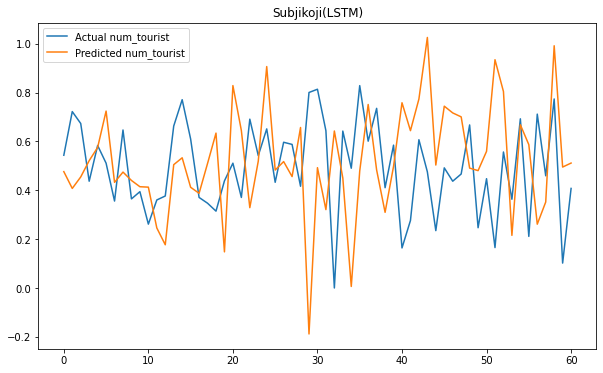

RMSE: 0.07668435571270694
Epoch: 0, loss: 0.26901
Epoch: 100, loss: 0.04870
Epoch: 200, loss: 0.05739
Epoch: 300, loss: 0.05793
Epoch: 400, loss: 0.05207
Epoch: 500, loss: 0.04711
Epoch: 600, loss: 0.04153
Epoch: 700, loss: 0.03642
Epoch: 800, loss: 0.03395
Epoch: 900, loss: 0.04529
Epoch: 1000, loss: 0.04690
Epoch: 1100, loss: 0.03424
Epoch: 1200, loss: 0.02700
Epoch: 1300, loss: 0.03149
Epoch: 1400, loss: 0.02812
Epoch: 1500, loss: 0.03566
Epoch: 1600, loss: 0.02675
Epoch: 1700, loss: 0.01669
Epoch: 1800, loss: 0.02554
Epoch: 1900, loss: 0.04092
Epoch: 2000, loss: 0.02248
Epoch: 2100, loss: 0.02690
Epoch: 2200, loss: 0.02749
Epoch: 2300, loss: 0.02612
Epoch: 2400, loss: 0.01896
Epoch: 2500, loss: 0.02605
Epoch: 2600, loss: 0.04112
Epoch: 2700, loss: 0.02871
Epoch: 2800, loss: 0.02924
Epoch: 2900, loss: 0.01478
Epoch: 3000, loss: 0.02876
Epoch: 3100, loss: 0.02233
Epoch: 3200, loss: 0.02285
Epoch: 3300, loss: 0.04246
Epoch: 3400, loss: 0.03241
Epoch: 3500, loss: 0.02830
Epoch: 3600, l

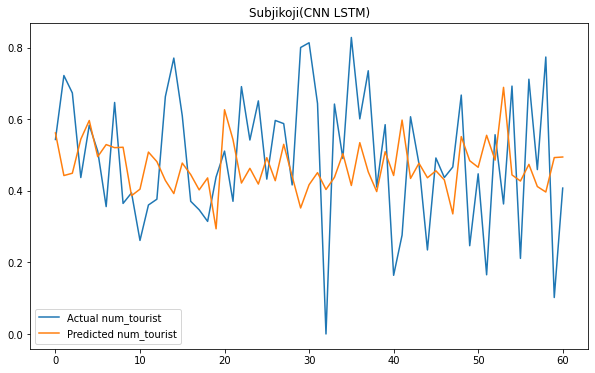

RMSE: 0.16175819758959184
Epoch: 0, loss: 0.07186
Epoch: 100, loss: 0.02661
Epoch: 200, loss: 0.02172
Epoch: 300, loss: 0.01870
Epoch: 400, loss: 0.01679
Epoch: 500, loss: 0.01563
Epoch: 600, loss: 0.01468
Epoch: 700, loss: 0.01383
Epoch: 800, loss: 0.01320
Epoch: 900, loss: 0.01274
Epoch: 1000, loss: 0.01242
Epoch: 1100, loss: 0.01224
Epoch: 1200, loss: 0.01171
Epoch: 1300, loss: 0.01152
Epoch: 1400, loss: 0.01128
Epoch: 1500, loss: 0.01104
Epoch: 1600, loss: 0.01092
Epoch: 1700, loss: 0.01089
Epoch: 1800, loss: 0.01071
Epoch: 1900, loss: 0.01063
Epoch: 2000, loss: 0.01062
Epoch: 2100, loss: 0.01056
Epoch: 2200, loss: 0.01051
Epoch: 2300, loss: 0.01048
Epoch: 2400, loss: 0.01047
Epoch: 2500, loss: 0.01036
Epoch: 2600, loss: 0.01050
Epoch: 2700, loss: 0.01039
Epoch: 2800, loss: 0.01023
Epoch: 2900, loss: 0.01031
Epoch: 3000, loss: 0.01015
Epoch: 3100, loss: 0.01015
Epoch: 3200, loss: 0.01013
Epoch: 3300, loss: 0.01015
Epoch: 3400, loss: 0.01003
Epoch: 3500, loss: 0.00999
Epoch: 3600, l

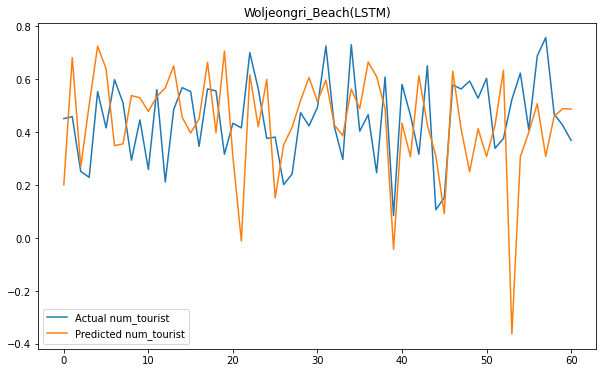

RMSE: 0.08577792839140469
Epoch: 0, loss: 0.11127
Epoch: 100, loss: 0.04924
Epoch: 200, loss: 0.04976
Epoch: 300, loss: 0.04282
Epoch: 400, loss: 0.03218
Epoch: 500, loss: 0.03181
Epoch: 600, loss: 0.02922
Epoch: 700, loss: 0.02683
Epoch: 800, loss: 0.02846
Epoch: 900, loss: 0.03263
Epoch: 1000, loss: 0.02552
Epoch: 1100, loss: 0.02318
Epoch: 1200, loss: 0.03274
Epoch: 1300, loss: 0.02740
Epoch: 1400, loss: 0.01767
Epoch: 1500, loss: 0.03530
Epoch: 1600, loss: 0.03298
Epoch: 1700, loss: 0.02835
Epoch: 1800, loss: 0.02030
Epoch: 1900, loss: 0.02380
Epoch: 2000, loss: 0.02868
Epoch: 2100, loss: 0.01868
Epoch: 2200, loss: 0.02674
Epoch: 2300, loss: 0.02778
Epoch: 2400, loss: 0.02120
Epoch: 2500, loss: 0.02753
Epoch: 2600, loss: 0.02616
Epoch: 2700, loss: 0.03409
Epoch: 2800, loss: 0.02240
Epoch: 2900, loss: 0.02999
Epoch: 3000, loss: 0.02485
Epoch: 3100, loss: 0.02460
Epoch: 3200, loss: 0.01902
Epoch: 3300, loss: 0.02885
Epoch: 3400, loss: 0.03196
Epoch: 3500, loss: 0.02092
Epoch: 3600, l

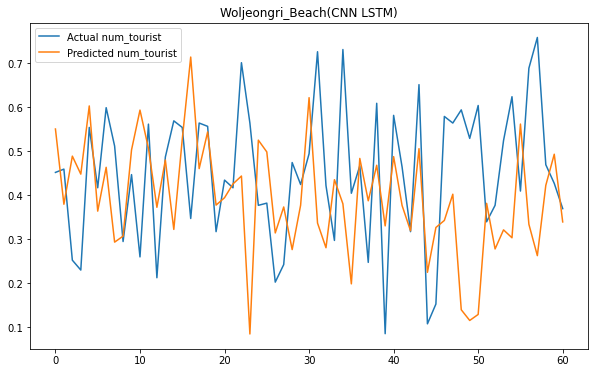

RMSE: 0.1570477683361007
Epoch: 0, loss: 0.27141
Epoch: 100, loss: 0.02637
Epoch: 200, loss: 0.02480
Epoch: 300, loss: 0.02309
Epoch: 400, loss: 0.01967
Epoch: 500, loss: 0.01827
Epoch: 600, loss: 0.01751
Epoch: 700, loss: 0.01699
Epoch: 800, loss: 0.01667
Epoch: 900, loss: 0.01647
Epoch: 1000, loss: 0.01621
Epoch: 1100, loss: 0.01615
Epoch: 1200, loss: 0.01585
Epoch: 1300, loss: 0.01569
Epoch: 1400, loss: 0.01559
Epoch: 1500, loss: 0.01544
Epoch: 1600, loss: 0.01530
Epoch: 1700, loss: 0.01521
Epoch: 1800, loss: 0.01507
Epoch: 1900, loss: 0.01496
Epoch: 2000, loss: 0.01485
Epoch: 2100, loss: 0.01476
Epoch: 2200, loss: 0.01476
Epoch: 2300, loss: 0.01451
Epoch: 2400, loss: 0.01441
Epoch: 2500, loss: 0.01438
Epoch: 2600, loss: 0.01437
Epoch: 2700, loss: 0.01426
Epoch: 2800, loss: 0.01421
Epoch: 2900, loss: 0.01417
Epoch: 3000, loss: 0.01417
Epoch: 3100, loss: 0.01407
Epoch: 3200, loss: 0.01403
Epoch: 3300, loss: 0.01398
Epoch: 3400, loss: 0.01396
Epoch: 3500, loss: 0.01397
Epoch: 3600, lo

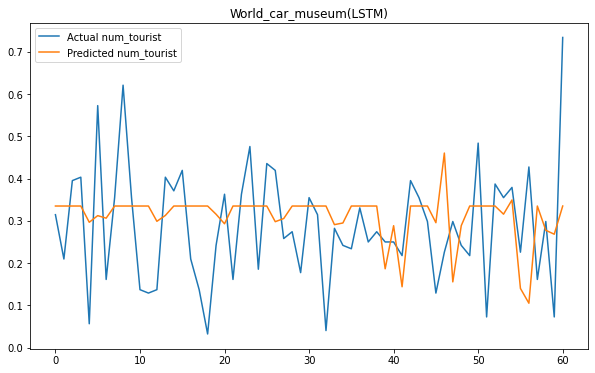

RMSE: 0.11353696948653763
Epoch: 0, loss: 0.13608
Epoch: 100, loss: 0.03653
Epoch: 200, loss: 0.03599
Epoch: 300, loss: 0.03465
Epoch: 400, loss: 0.02759
Epoch: 500, loss: 0.02421
Epoch: 600, loss: 0.01737
Epoch: 700, loss: 0.02662
Epoch: 800, loss: 0.01596
Epoch: 900, loss: 0.01071
Epoch: 1000, loss: 0.01962
Epoch: 1100, loss: 0.01638
Epoch: 1200, loss: 0.01408
Epoch: 1300, loss: 0.01615
Epoch: 1400, loss: 0.01265
Epoch: 1500, loss: 0.01456
Epoch: 1600, loss: 0.01660
Epoch: 1700, loss: 0.01635
Epoch: 1800, loss: 0.01602
Epoch: 1900, loss: 0.01987
Epoch: 2000, loss: 0.01337
Epoch: 2100, loss: 0.01175
Epoch: 2200, loss: 0.01537
Epoch: 2300, loss: 0.01416
Epoch: 2400, loss: 0.01321
Epoch: 2500, loss: 0.01683
Epoch: 2600, loss: 0.01747
Epoch: 2700, loss: 0.01981
Epoch: 2800, loss: 0.01518
Epoch: 2900, loss: 0.01566
Epoch: 3000, loss: 0.02077
Epoch: 3100, loss: 0.01467
Epoch: 3200, loss: 0.01382
Epoch: 3300, loss: 0.01264
Epoch: 3400, loss: 0.01820
Epoch: 3500, loss: 0.01864
Epoch: 3600, l

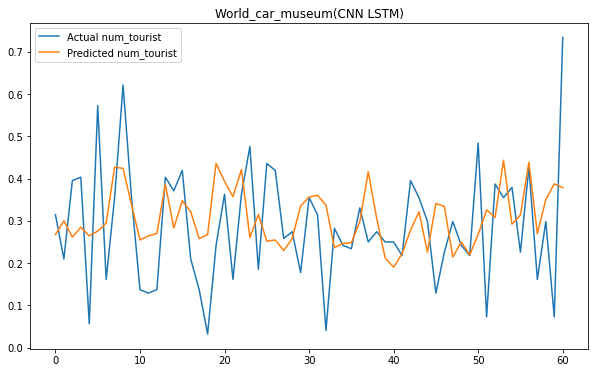

RMSE: 0.1209663790283476
Epoch: 0, loss: 0.01643
Epoch: 100, loss: 0.00544
Epoch: 200, loss: 0.00432
Epoch: 300, loss: 0.00368
Epoch: 400, loss: 0.00328
Epoch: 500, loss: 0.00300
Epoch: 600, loss: 0.00279
Epoch: 700, loss: 0.00264
Epoch: 800, loss: 0.00255
Epoch: 900, loss: 0.00246
Epoch: 1000, loss: 0.00240
Epoch: 1100, loss: 0.00231
Epoch: 1200, loss: 0.00226
Epoch: 1300, loss: 0.00220
Epoch: 1400, loss: 0.00229
Epoch: 1500, loss: 0.00220
Epoch: 1600, loss: 0.00209
Epoch: 1700, loss: 0.00208
Epoch: 1800, loss: 0.00206
Epoch: 1900, loss: 0.00212
Epoch: 2000, loss: 0.00209
Epoch: 2100, loss: 0.00197
Epoch: 2200, loss: 0.00197
Epoch: 2300, loss: 0.00194
Epoch: 2400, loss: 0.00195
Epoch: 2500, loss: 0.00190
Epoch: 2600, loss: 0.00189
Epoch: 2700, loss: 0.00187
Epoch: 2800, loss: 0.00184
Epoch: 2900, loss: 0.00186
Epoch: 3000, loss: 0.00180
Epoch: 3100, loss: 0.00177
Epoch: 3200, loss: 0.00174
Epoch: 3300, loss: 0.00168
Epoch: 3400, loss: 0.00181
Epoch: 3500, loss: 0.00161
Epoch: 3600, lo

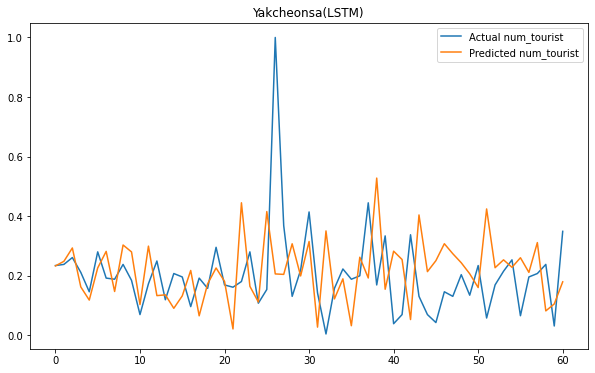

RMSE: 0.030490327112126365
Epoch: 0, loss: 0.01458
Epoch: 100, loss: 0.01123
Epoch: 200, loss: 0.00967
Epoch: 300, loss: 0.00782
Epoch: 400, loss: 0.00626
Epoch: 500, loss: 0.00591
Epoch: 600, loss: 0.00546
Epoch: 700, loss: 0.00474
Epoch: 800, loss: 0.00259
Epoch: 900, loss: 0.00531
Epoch: 1000, loss: 0.00560
Epoch: 1100, loss: 0.00333
Epoch: 1200, loss: 0.00444
Epoch: 1300, loss: 0.00445
Epoch: 1400, loss: 0.00633
Epoch: 1500, loss: 0.00491
Epoch: 1600, loss: 0.00572
Epoch: 1700, loss: 0.00357
Epoch: 1800, loss: 0.00390
Epoch: 1900, loss: 0.00565
Epoch: 2000, loss: 0.00373
Epoch: 2100, loss: 0.00606
Epoch: 2200, loss: 0.00526
Epoch: 2300, loss: 0.00536
Epoch: 2400, loss: 0.00416
Epoch: 2500, loss: 0.00513
Epoch: 2600, loss: 0.00499
Epoch: 2700, loss: 0.00521
Epoch: 2800, loss: 0.00466
Epoch: 2900, loss: 0.00535
Epoch: 3000, loss: 0.00464
Epoch: 3100, loss: 0.00456
Epoch: 3200, loss: 0.00400
Epoch: 3300, loss: 0.00375
Epoch: 3400, loss: 0.00390
Epoch: 3500, loss: 0.00569
Epoch: 3600, 

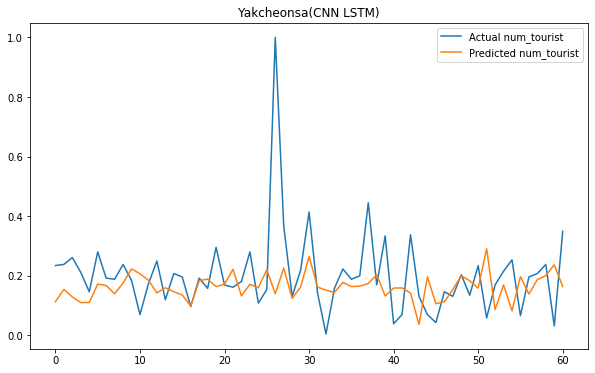

RMSE: 0.07783294267970339
Epoch: 0, loss: 0.24934
Epoch: 100, loss: 0.03045
Epoch: 200, loss: 0.02741
Epoch: 300, loss: 0.02279
Epoch: 400, loss: 0.02100
Epoch: 500, loss: 0.01924
Epoch: 600, loss: 0.01800
Epoch: 700, loss: 0.01718
Epoch: 800, loss: 0.01645
Epoch: 900, loss: 0.01580
Epoch: 1000, loss: 0.01526
Epoch: 1100, loss: 0.01479
Epoch: 1200, loss: 0.01426
Epoch: 1300, loss: 0.01388
Epoch: 1400, loss: 0.01354
Epoch: 1500, loss: 0.01319
Epoch: 1600, loss: 0.01290
Epoch: 1700, loss: 0.01256
Epoch: 1800, loss: 0.01224
Epoch: 1900, loss: 0.01193
Epoch: 2000, loss: 0.01165
Epoch: 2100, loss: 0.01136
Epoch: 2200, loss: 0.01114
Epoch: 2300, loss: 0.01090
Epoch: 2400, loss: 0.01067
Epoch: 2500, loss: 0.01038
Epoch: 2600, loss: 0.01018
Epoch: 2700, loss: 0.00947
Epoch: 2800, loss: 0.00912
Epoch: 2900, loss: 0.00896
Epoch: 3000, loss: 0.00888
Epoch: 3100, loss: 0.00875
Epoch: 3200, loss: 0.00871
Epoch: 3300, loss: 0.00868
Epoch: 3400, loss: 0.00859
Epoch: 3500, loss: 0.00852
Epoch: 3600, l

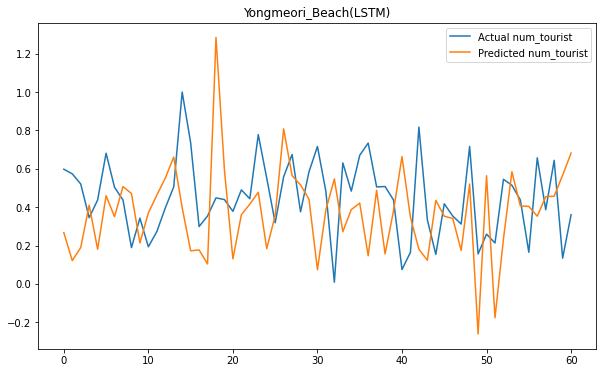

RMSE: 0.08379294235298787
Epoch: 0, loss: 0.14141
Epoch: 100, loss: 0.04519
Epoch: 200, loss: 0.05130
Epoch: 300, loss: 0.03565
Epoch: 400, loss: 0.03497
Epoch: 500, loss: 0.02612
Epoch: 600, loss: 0.03234
Epoch: 700, loss: 0.01722
Epoch: 800, loss: 0.03209
Epoch: 900, loss: 0.01962
Epoch: 1000, loss: 0.02853
Epoch: 1100, loss: 0.01567
Epoch: 1200, loss: 0.02998
Epoch: 1300, loss: 0.01547
Epoch: 1400, loss: 0.02853
Epoch: 1500, loss: 0.02120
Epoch: 1600, loss: 0.02262
Epoch: 1700, loss: 0.02498
Epoch: 1800, loss: 0.02163
Epoch: 1900, loss: 0.02099
Epoch: 2000, loss: 0.01893
Epoch: 2100, loss: 0.01788
Epoch: 2200, loss: 0.02313
Epoch: 2300, loss: 0.02116
Epoch: 2400, loss: 0.01791
Epoch: 2500, loss: 0.02786
Epoch: 2600, loss: 0.01628
Epoch: 2700, loss: 0.02274
Epoch: 2800, loss: 0.02237
Epoch: 2900, loss: 0.01703
Epoch: 3000, loss: 0.02248
Epoch: 3100, loss: 0.02652
Epoch: 3200, loss: 0.01781
Epoch: 3300, loss: 0.03016
Epoch: 3400, loss: 0.01969
Epoch: 3500, loss: 0.02184
Epoch: 3600, l

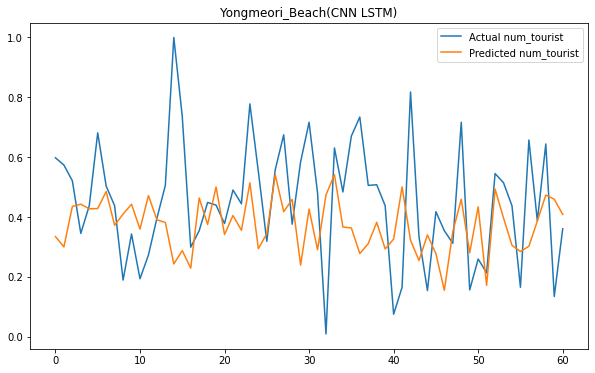

RMSE: 0.13646945022357942
Epoch: 0, loss: 0.39885
Epoch: 100, loss: 0.02747
Epoch: 200, loss: 0.02451
Epoch: 300, loss: 0.02080
Epoch: 400, loss: 0.01926
Epoch: 500, loss: 0.01841
Epoch: 600, loss: 0.01749
Epoch: 700, loss: 0.01694
Epoch: 800, loss: 0.01670
Epoch: 900, loss: 0.01646
Epoch: 1000, loss: 0.01627
Epoch: 1100, loss: 0.01611
Epoch: 1200, loss: 0.01599
Epoch: 1300, loss: 0.01587
Epoch: 1400, loss: 0.01580
Epoch: 1500, loss: 0.01572
Epoch: 1600, loss: 0.01565
Epoch: 1700, loss: 0.01557
Epoch: 1800, loss: 0.01547
Epoch: 1900, loss: 0.01522
Epoch: 2000, loss: 0.01496
Epoch: 2100, loss: 0.01481
Epoch: 2200, loss: 0.01453
Epoch: 2300, loss: 0.01441
Epoch: 2400, loss: 0.01419
Epoch: 2500, loss: 0.01399
Epoch: 2600, loss: 0.01386
Epoch: 2700, loss: 0.01375
Epoch: 2800, loss: 0.01367
Epoch: 2900, loss: 0.01359
Epoch: 3000, loss: 0.01352
Epoch: 3100, loss: 0.01348
Epoch: 3200, loss: 0.01342
Epoch: 3300, loss: 0.01340
Epoch: 3400, loss: 0.01330
Epoch: 3500, loss: 0.01323
Epoch: 3600, l

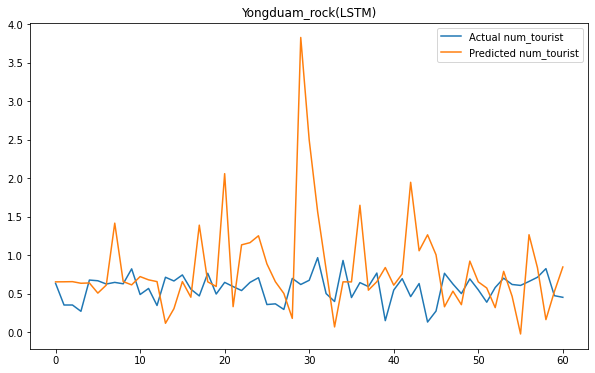

RMSE: 0.10599759639408021
Epoch: 0, loss: 0.33792
Epoch: 100, loss: 0.05689
Epoch: 200, loss: 0.05056
Epoch: 300, loss: 0.06672
Epoch: 400, loss: 0.05805
Epoch: 500, loss: 0.05097
Epoch: 600, loss: 0.05568
Epoch: 700, loss: 0.04132
Epoch: 800, loss: 0.04889
Epoch: 900, loss: 0.04453
Epoch: 1000, loss: 0.04552
Epoch: 1100, loss: 0.03519
Epoch: 1200, loss: 0.02661
Epoch: 1300, loss: 0.03775
Epoch: 1400, loss: 0.03118
Epoch: 1500, loss: 0.02668
Epoch: 1600, loss: 0.04583
Epoch: 1700, loss: 0.02210
Epoch: 1800, loss: 0.04593
Epoch: 1900, loss: 0.03598
Epoch: 2000, loss: 0.03213
Epoch: 2100, loss: 0.03049
Epoch: 2200, loss: 0.03825
Epoch: 2300, loss: 0.03736
Epoch: 2400, loss: 0.03708
Epoch: 2500, loss: 0.03310
Epoch: 2600, loss: 0.04712
Epoch: 2700, loss: 0.03210
Epoch: 2800, loss: 0.04392
Epoch: 2900, loss: 0.03817
Epoch: 3000, loss: 0.04738
Epoch: 3100, loss: 0.03472
Epoch: 3200, loss: 0.02732
Epoch: 3300, loss: 0.03448
Epoch: 3400, loss: 0.03691
Epoch: 3500, loss: 0.04232
Epoch: 3600, l

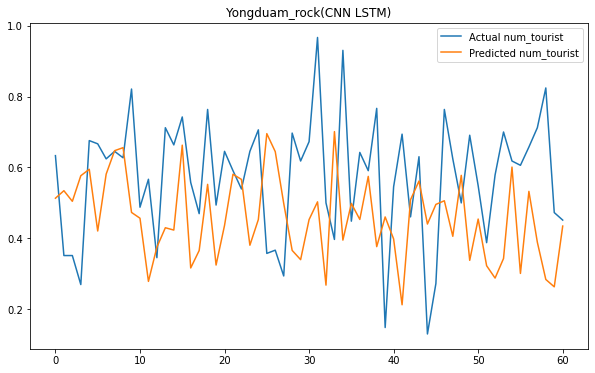

RMSE: 0.1895745271866245


In [ ]:
# feature별로 범위가 달라 scaler 사용
from sklearn.preprocessing import MinMaxScaler,StandardScaler

for i in os.listdir('./modeling_dataset/'):
    # 데이터셋 준비하기
    df = pd.read_csv('./modeling_dataset/'+i)
################ .ipynb_checkpoints 때문에 에러가 날 경우, 삭제하고 다시 실행 해주세요 #############################
    df = df.drop('poi', axis = 1)
    df.index = df['date']
    df = df.drop('date', axis = 1)
    X = df.drop(columns='num_of_search')
    y = df.iloc[:,8:9]

    mm = MinMaxScaler()
    ss = StandardScaler()

    X_ss = ss.fit_transform(X)
    y_mm = mm.fit_transform(y)

    # Train, Test 데이터셋 분리하기
    X_train = X_ss[:304,:]
    X_test = X_ss[304:,:]

    y_train = y_mm[:304,:]
    y_test = y_mm[304:,:]

    # 학습할 수 있는 tensor형태로 변환
    X_train_tensors = Variable(torch.Tensor(X_train))
    X_test_tensors = Variable(torch.Tensor(X_test))

    y_train_tensors = Variable(torch.Tensor(y_train))
    y_test_tensors = Variable(torch.Tensor(y_test))

    X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
    X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

    # model1 - LSTM
    # 네트워크 파라미터 구성하기
    num_epochs = 10000
    learning_rate = 0.005 

    # feature 개수
    input_size = 8 
    # hidden state의 feature 개수
    hidden_size = 4 
    # lstm layer 개수
    num_layers = 1 

    # output class 개수
    num_classes = 1 

    # 모델 구현
    lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

    # Mean-squared error for regression
    loss_function = torch.nn.MSELoss()   
    # Adam optimizer 
    optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)  

    # 학습하기
    lstm1.train()
    for epoch in range(num_epochs):
        # forward pass
        outputs = lstm1.forward(X_train_tensors_final.to(device)) 
        optimizer.zero_grad() 
        
        # loss function
        loss = loss_function(outputs, y_train_tensors.to(device))

        # loss function의 loss 계산
        loss.backward() 
        
        optimizer.step() 
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

    # 예측 할 수 있는 tensor형태로 변환
    X_test2 = Variable(torch.Tensor(X_test)) #converting to Tensors
    y_test2 = Variable(torch.Tensor(y_test))

    X_test2 = torch.reshape(X_test2, (X_test2.shape[0], 1, X_test2.shape[1]))
    lstm1.eval()
    # forward pass
    train_predict = lstm1(X_test2.to(device))
    data_predict = train_predict.data.detach().cpu().numpy() 
    dataY_plot = y_test2.data.numpy()

    # 결과 시각화
    data_predict_to_plot =  [i[0] for i in data_predict]
    dataY_plot_to_plot =  [i[0] for i in dataY_plot]
    plt.figure(figsize=(10,6)) 
    plt.plot(dataY_plot, label='Actual num_tourist') 
    plt.plot(data_predict, label='Predicted num_tourist') 
    name = i.split('.')[0]
    plt.title(name+ '(LSTM)')
    plt.legend()
    plt.savefig('./'+name+'_lstm')
    plt.show()

    lstm_temp.append(math.sqrt(loss))
    print("RMSE: %s" % math.sqrt(loss))



    # model2 - CNN LSTM
    # 네트워크 파라미터 구성하기
    num_epochs = 4000
    learning_rate = 0.005

    # feature 개수
    input_size = 8 
    # hidden state의 feature 개수
    hidden_size = 4 
    # lstm layer 개수
    num_layers = 1 

    num_classes = 1 #number of output classes 

    cnn_lstm = CNN_LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

    # Mean-squared error for regression
    loss_function = torch.nn.MSELoss()    
    # Adam optimizer
    optimizer = torch.optim.Adam(cnn_lstm.parameters(), lr=learning_rate) 

    # 학습하기
    cnn_lstm.train()
    for epoch in range(num_epochs):
        #forward pass
        outputs = cnn_lstm.forward(X_train_tensors_final.to(device)) 
        optimizer.zero_grad() 
        
        # loss function
        loss = loss_function(outputs, y_train_tensors.to(device))

        # loss function의 loss 계산
        loss.backward() 
        
        optimizer.step() 
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

    # 예측할 수 있는 tensor형태로 변환
    X_test2 = Variable(torch.Tensor(X_test)) 
    y_test2 = Variable(torch.Tensor(y_test))

    X_test2 = torch.reshape(X_test2, (X_test2.shape[0], 1, X_test2.shape[1]))
    cnn_lstm.eval()
    # forward pass
    train_predict = cnn_lstm(X_test2.to(device))
    data_predict = train_predict.data.detach().cpu().numpy() 
    dataY_plot = y_test2.data.numpy()

    # 결과 시각화
    data_predict_to_plot =  [i[0] for i in data_predict]
    dataY_plot_to_plot =  [i[0] for i in dataY_plot]

    plt.figure(figsize=(10,6)) 
    plt.plot(dataY_plot, label='Actual num_tourist') 
    plt.plot(data_predict, label='Predicted num_tourist') 
    plt.title(name+ '(CNN LSTM)')
    plt.legend()
    plt.savefig('./'+name+'_cnn')
    plt.show() 

    # MSE -> RMSE 바꾸기 위해 제곱근 계산
    cnn_temp.append(math.sqrt(loss))
    print("RMSE: %s" % math.sqrt(loss))

In [ ]:
# RMSE score, 모델 별 RMSE 평균 데이터프레임 생성
rmse['LSTM'] = pd.DataFrame(lstm_temp)
rmse['CNN_LSTM'] = pd.DataFrame(cnn_temp)
rmse = rmse.append({'LSTM' : np.mean(lstm_temp), 'CNN_LSTM' : np.mean(cnn_temp)}, ignore_index=True)

In [ ]:
rmse
# 41 : 평균

LSTM  CNN_LSTM
0   0.105103  0.217679
1   0.091030  0.133060
2   0.086172  0.131024
3   0.114989  0.117077
4   0.087816  0.165900
5   0.104429  0.172324
6   0.054492  0.102201
7   0.088728  0.138832
8   0.083517  0.197512
9   0.089069  0.104542
10  0.089023  0.159644
11  0.052884  0.117407
12  0.075931  0.139177
13  0.098243  0.130355
14  0.099728  0.147101
15  0.090308  0.161431
16  0.116403  0.212701
17  0.099223  0.191721
18  0.097051  0.167492
19  0.065367  0.099065
20  0.071579  0.155621
21  0.099241  0.167559
22  0.119212  0.158582
23  0.123608  0.140127
24  0.079578  0.139593
25  0.089180  0.097455
26  0.044694  0.112272
27  0.101550  0.159535
28  0.065500  0.141874
29  0.098912  0.208007
30  0.098100  0.130505
31  0.083371  0.127191
32  0.095264  0.189119
33  0.133094  0.153908
34  0.057232  0.154924
35  0.076684  0.161758
36  0.085778  0.157048
37  0.113537  0.120966
38  0.030490  0.077833
39  0.083793  0.136469
40  0.105998  0.189575
41  0.088924  0.148443